# Optimum and MT2TE Node Change

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.titleweight'] = 'bold'



In [3]:
# Define algorithm styles matching reference images
ALGORITHM_STYLES = {
    'Optimum': {
        'color': '#ff7f0e',  # Orange
        'pattern': '...',     # Dense dotted pattern
        'label': 'Optimum',
        'line_style': '--',    # Dashed for line chart
        'marker': 'o',         # Circle marker
        'line_color': '#9467bd'  # Purple for line chart
    },
    'EVRPBSS': {
        'color': '#2ca02c',   # Green
        'pattern': '///',      # Diagonal stripes
        'label': 'MT2TE',
        'line_style': '-',     # Solid line
        'marker': 'v',        # Downward triangle marker
        'line_color': '#2ca02c'  # Green for line chart
    }
}



In [4]:
def load_ch_data(metric_name, data_dir='node_change', x_axis_col=None):
    """
    Load CSV file from data_CH directory.
    
    Parameters:
    -----------
    metric_name : str
        Name of the metric (e.g., 'travelTime', 'energy', 'distance', 'runtime')
    data_dir : str
        Subdirectory name (e.g., 'node_change', 'module_change', 'swaptime_change', etc.)
    x_axis_col : str, optional
        Name of the x-axis column. If None, will be inferred from first column.
    
    Returns:
    --------
    tuple: (DataFrame with columns: x_axis_col, Optimum, EVRPBSS, x_axis_col_name)
    """
    # Resolve path - check if running from viz folder or project root
    base_path = Path.cwd()
    if base_path.name == 'viz':
        base_path = base_path.parent
    
    # Determine the CSV filename based on data_dir
    if data_dir == 'node_change':
        csv_filename = f'C&H_NodeChange_{metric_name}.csv'
    elif data_dir == 'module_change':
        csv_filename = f'C&H_ModulesChange_{metric_name}.csv'
    elif data_dir == 'swaptime_change':
        csv_filename = f'C&H_SwapTimeChange_{metric_name}.csv'
    elif data_dir == 'threshold_change':
        csv_filename = f'C&H_ThresholdChange_{metric_name}.csv'
    elif data_dir == 'traffic_change':
        csv_filename = f'C&H_Traffic_{metric_name}.csv'
    else:
        raise ValueError(f"Unknown data directory: {data_dir}")
    
    data_path = base_path / 'data_CH' / data_dir / csv_filename
    
    if not data_path.exists():
        raise FileNotFoundError(f"Data file not found: {data_path.absolute()}")
    
    # Load CSV
    df = pd.read_csv(data_path)
    
    # Rename columns: CPLEX -> Optimum, H -> EVRPBSS
    df = df.rename(columns={'CPLEX': 'Optimum', 'H': 'EVRPBSS'})
    
    # Get x-axis column name (first column that's not Optimum or EVRPBSS)
    if x_axis_col is None:
        x_axis_col = [col for col in df.columns if col not in ['Optimum', 'EVRPBSS']][0]
    
    # Sort by x-axis column for consistent ordering
    # Handle special case for traffic levels
    if x_axis_col == 'trafficLevel':
        traffic_order = {'Low': 1, 'Mid': 2, 'High': 3}
        df['_sort_order'] = df[x_axis_col].map(traffic_order)
        df = df.sort_values('_sort_order')
        df = df.drop(columns=['_sort_order'])
    else:
        df = df.sort_values(x_axis_col)
    
    return df, x_axis_col



In [5]:
def create_grouped_bar_chart(df, x_axis_col, ylabel, xlabel=None, title=None):
    """
    Create a grouped bar chart matching the reference image style.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with columns: x_axis_col, Optimum, EVRPBSS
    x_axis_col : str
        Name of the x-axis column
    ylabel : str
        Y-axis label
    xlabel : str, optional
        X-axis label. If None, uses x_axis_col
    title : str, optional
        Chart title
    """
    # Check if df is a tuple (common mistake from old load_ch_data calls)
    if isinstance(df, tuple):
        raise TypeError("df is a tuple. Please re-run the data loading cell to unpack it correctly: df, x_col = load_ch_data(...)")
    
    # Prepare data - ensure x-axis values are sorted and values align
    if x_axis_col == 'trafficLevel':
        traffic_order = {'Low': 1, 'Mid': 2, 'High': 3}
        df['_sort_order'] = df[x_axis_col].map(traffic_order)
        df_sorted = df.sort_values('_sort_order')
        df_sorted = df_sorted.drop(columns=['_sort_order'])
    else:
        df_sorted = df.sort_values(x_axis_col)
    
    x_values = df_sorted[x_axis_col].values
    x = np.arange(len(x_values))
    width = 0.35
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for each algorithm
    for i, algo in enumerate(['Optimum', 'EVRPBSS']):
        # Handle legacy column names if they don't exist
        column_name = algo
        if algo == 'Optimum' and 'Optimum' not in df_sorted.columns and 'OPL' in df_sorted.columns:
            column_name = 'OPL'
        elif algo == 'EVRPBSS' and 'EVRPBSS' not in df_sorted.columns and 'Heuristic' in df_sorted.columns:
            column_name = 'Heuristic'
        values = df_sorted[column_name].values
        style = ALGORITHM_STYLES[algo]
        
        bars = ax.bar(x + i * width, values, width,
                     label=style['label'],
                     color=style['color'],
                     edgecolor='black',
                     linewidth=0.5,
                     hatch=style['pattern'])
        
        # Add value labels on top of bars
        for j, (bar, val) in enumerate(zip(bars, values)):
            height = bar.get_height()
            # Format value - use 1 decimal place for small values, integer for large
            if val < 10:
                label_text = f'{val:.1f}'
            else:
                label_text = f'{int(val)}'
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   label_text,
                   ha='center', va='bottom',
                   fontsize=10, fontweight='normal')
    
    # Customize axes
    if xlabel is None:
        xlabel = x_axis_col.replace('_', ' ').title()
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(x_values)
    ax.legend(title='Algorithm', title_fontsize=11, fontsize=11, frameon=True, 
              loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.set_axisbelow(True)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for legend on the right
    plt.show()



In [6]:
def create_runtime_line_chart(df, ylabel, title=None):
    """
    Create a line chart for runtime matching the reference image style.
    Uses Y-axis scaled by 10³ to clearly show growth for smaller instances,
    with annotation for out-of-bounds values.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with columns: node, Optimum, EVRPBSS
    ylabel : str
        Y-axis label
    title : str, optional
        Chart title
    """
    # Prepare data - ensure nodes are sorted and values align
    df_sorted = df.sort_values('node')
    nodes = df_sorted['node'].values
    
    # Scale factor: divide by 1000 to show values in ×10³
    scale_factor = 1000
    
    # Determine Y-axis cap in scaled units (use 20 to show growth up to 24 nodes clearly)
    # This corresponds to 20000 seconds in original units
    y_axis_cap_scaled = 20
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Handle legacy column names
    optimum_col = 'Optimum' if 'Optimum' in df_sorted.columns else 'OPL'
    evrpbss_col = 'EVRPBSS' if 'EVRPBSS' in df_sorted.columns else 'Heuristic'
    
    # Get values for both algorithms (in original units)
    optimum_values = df_sorted[optimum_col].values
    evrpbss_values = df_sorted[evrpbss_col].values
    
    # Scale values for plotting (divide by scale_factor)
    optimum_values_scaled = optimum_values / scale_factor
    evrpbss_values_scaled = evrpbss_values / scale_factor
    
    # Check if node 28 exists and if Optimum value exceeds cap
    node_28_idx = None
    optimum_28_value_scaled = None
    optimum_28_value_original = None
    if 28 in nodes:
        node_28_idx = list(nodes).index(28)
        optimum_28_value_scaled = optimum_values_scaled[node_28_idx]
        optimum_28_value_original = optimum_values[node_28_idx]
    
    # Prepare data for plotting - cap values at y_axis_cap_scaled for visualization
    optimum_plot_values = optimum_values_scaled.copy()
    if node_28_idx is not None and optimum_28_value_scaled > y_axis_cap_scaled:
        # Cap the value at y_axis_cap_scaled so the line connects but shows it's out of bounds
        optimum_plot_values[node_28_idx] = y_axis_cap_scaled
    
    # Plot Optimum line (with node 28 capped at y_axis_cap_scaled if it exceeds)
    optimum_style = ALGORITHM_STYLES['Optimum']
    ax.plot(nodes, optimum_plot_values,
           color=optimum_style['line_color'],
           linestyle=optimum_style['line_style'],
           marker=optimum_style['marker'],
           label=optimum_style['label'],
           linewidth=2,
           markersize=8,
           markeredgecolor='black',
           markeredgewidth=0.5)
    
    # Plot EVRPBSS line (all nodes, scaled)
    evrpbss_style = ALGORITHM_STYLES['EVRPBSS']
    ax.plot(nodes, evrpbss_values_scaled,
           color=evrpbss_style['line_color'],
           linestyle=evrpbss_style['line_style'],
           marker=evrpbss_style['marker'],
           label=evrpbss_style['label'],
           linewidth=2,
           markersize=8,
           markeredgecolor='black',
           markeredgewidth=0.5)
    
    # Add "No Result" annotation at node 28 if it exceeds the cap
    if node_28_idx is not None and optimum_28_value_scaled > y_axis_cap_scaled:
        # Add annotation with the actual value in scaled units
        # Position text inside the graph area (upper right portion), higher to avoid line overlap
        annotation_text = f'No Result\n({optimum_28_value_scaled:.0f}×10³ sec)'
        ax.annotate(annotation_text,
                   xy=(28, y_axis_cap_scaled),
                   xytext=(23, y_axis_cap_scaled * 0.92),  # Positioned further left (x=23) and higher (92% of y-axis) to avoid overlap
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                   fontsize=10,
                   fontweight='bold',
                   ha='center',
                   va='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.8))
    
    # Customize axes
    ax.set_xlabel('Number of node', fontweight='bold')
    # Update ylabel to include ×10³ notation
    ax.set_ylabel('Execution Time (×10³ sec)', fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    
    ax.set_xticks(nodes)
    ax.legend(title='Algorithm', title_fontsize=11, fontsize=11, frameon=True, 
              loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Set Y-axis limits to show growth clearly for smaller instances (in scaled units)
    ax.set_ylim(bottom=0, top=y_axis_cap_scaled)
    
    # Format Y-axis ticks (show as decimals/integers since values are already scaled)
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{t:.2f}' if t < 1 else f'{int(t)}' if t == int(t) else f'{t:.1f}' for t in y_ticks])
    
    # Add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.set_axisbelow(True)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for legend on the right
    plt.show()



In [7]:
# Load travel time data
df_travel, x_col = load_ch_data('travelTime')


## (a) Total Travel Time Optimum and MT2TE Node Change

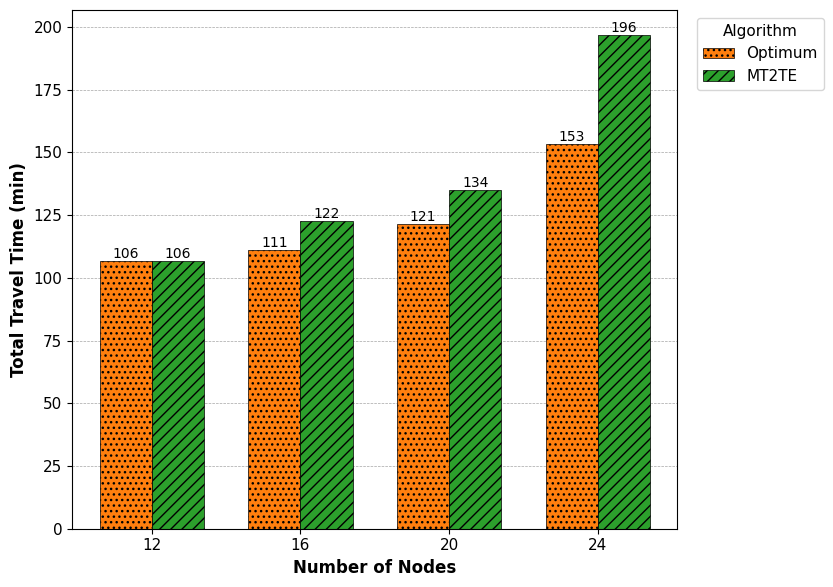

In [8]:
create_grouped_bar_chart(df_travel, x_col, 'Total Travel Time (min)', 'Number of Nodes')

In [9]:
# Load energy data
df_energy, x_col = load_ch_data('energy')




## (b) Total Energy Consumed Optimum and MT2TE Node Change

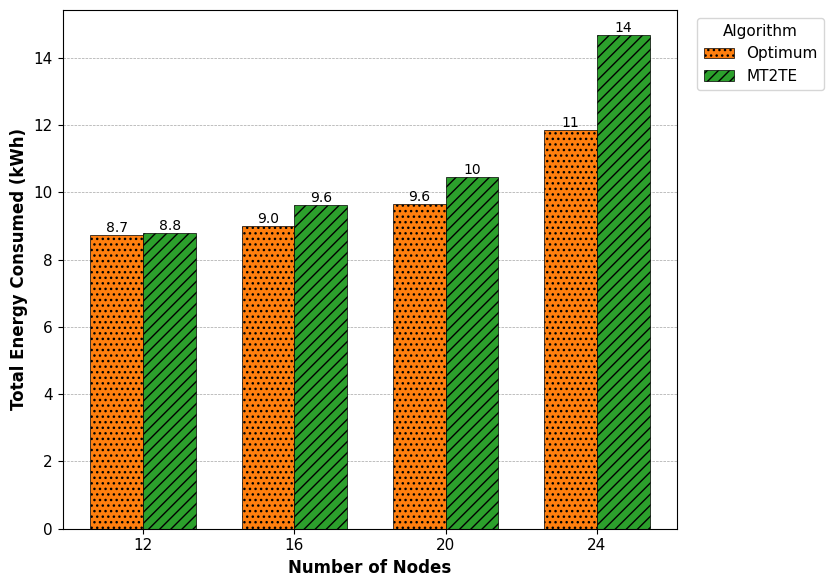

In [10]:
create_grouped_bar_chart(df_energy, x_col, 'Total Energy Consumed (kWh)', 'Number of Nodes')

In [11]:
# Load distance data
df_distance, x_col = load_ch_data('distance')



## (c) Total Distance Optimum and MT2TE Node Change

In [12]:
# Load runtime data
df_runtime, x_col_runtime = load_ch_data('runtime')


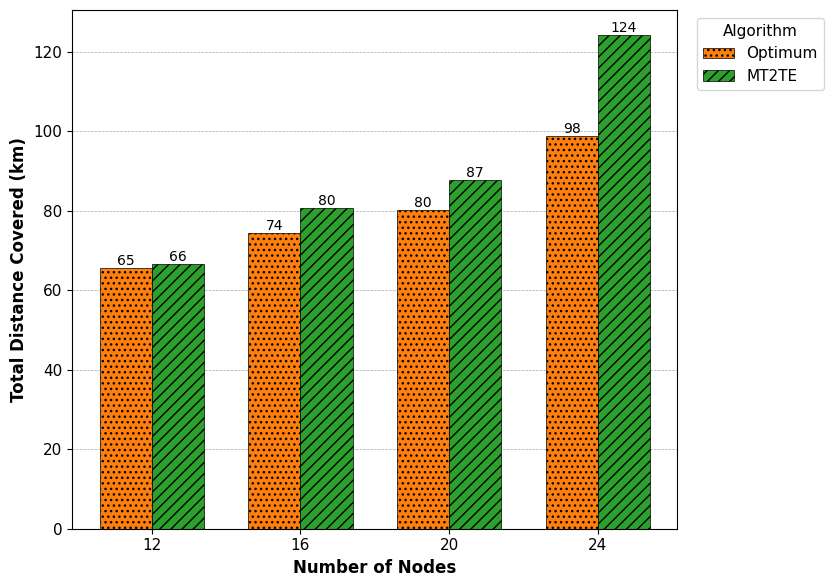

In [13]:
create_grouped_bar_chart(df_distance, x_col, 'Total Distance Covered (km)', 'Number of Nodes')

In [14]:
# Load runtime data
df_runtime, x_col_runtime = load_ch_data('runtime')



## (d) Execution Time Optimum and MT2TE Node Change

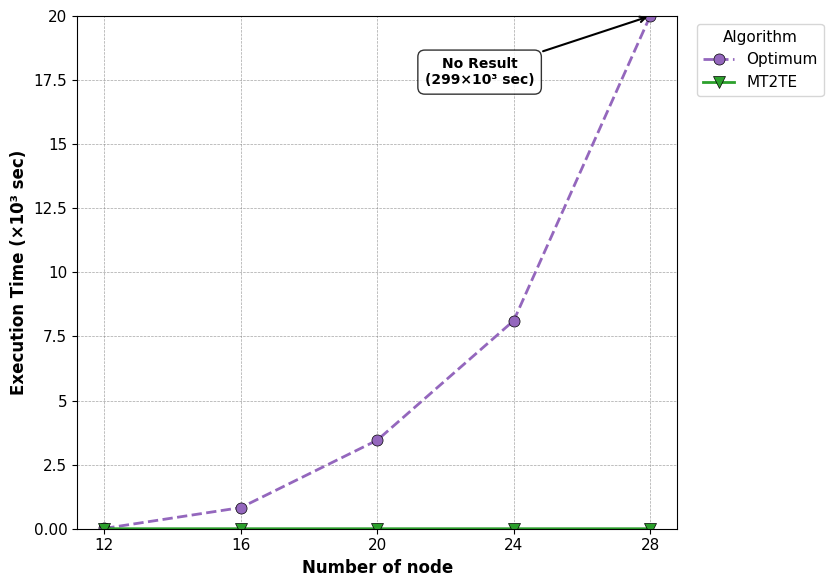

In [15]:
create_runtime_line_chart(df_runtime, 'Execution Time (sec)')

# Optimum and MT2TE Module Change

In [16]:
# Load Module Change travel time data
df_modules_travel, x_col_modules = load_ch_data('travelTime', 'module_change')
print("Module Change Travel Time Data:")
print(df_modules_travel)


Module Change Travel Time Data:
   module  Optimum  EVRPBSS
0       3    111.2    122.7
1       4    111.2    122.7
2       5    111.2    122.7
3       6    111.2    122.7


## (a) Travel Time

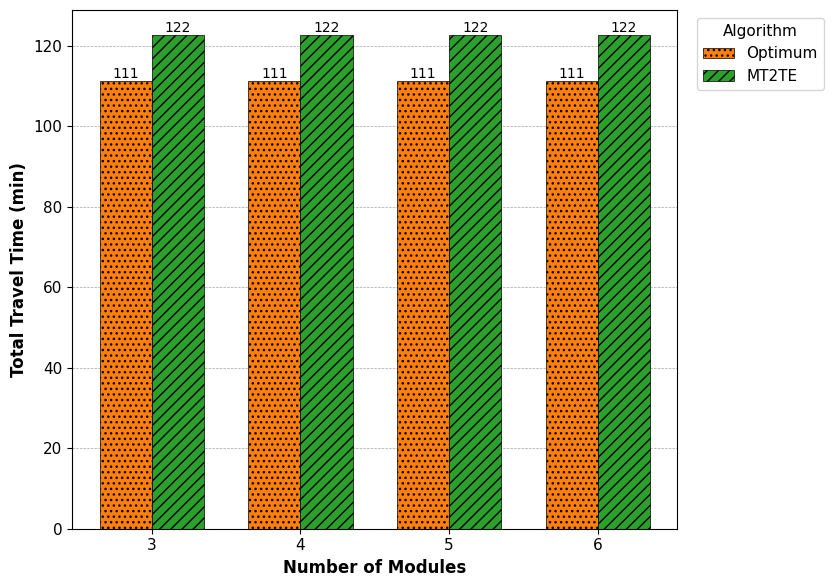

In [17]:
# Module Change - Total Travel Time bar chart
create_grouped_bar_chart(df_modules_travel, x_col_modules, 'Total Travel Time (min)', 'Number of Modules')


In [18]:
# Load Module Change energy data
df_modules_energy, _ = load_ch_data('energy', 'module_change')



## (b) Energy

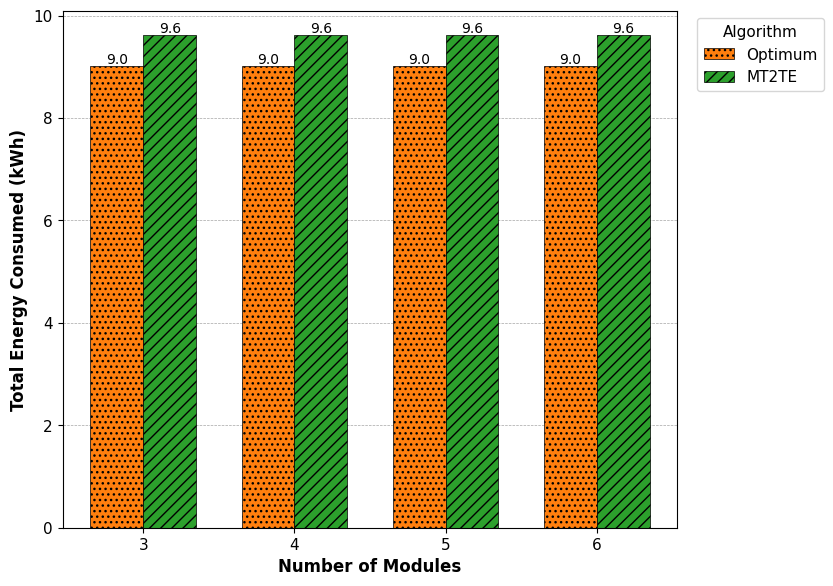

In [19]:
# Module Change - Total Energy Consumed bar chart
create_grouped_bar_chart(df_modules_energy, x_col_modules, 'Total Energy Consumed (kWh)', 'Number of Modules')


In [20]:
# Load Module Change distance data
df_modules_distance, _ = load_ch_data('distance', 'module_change')



## (c) Distance

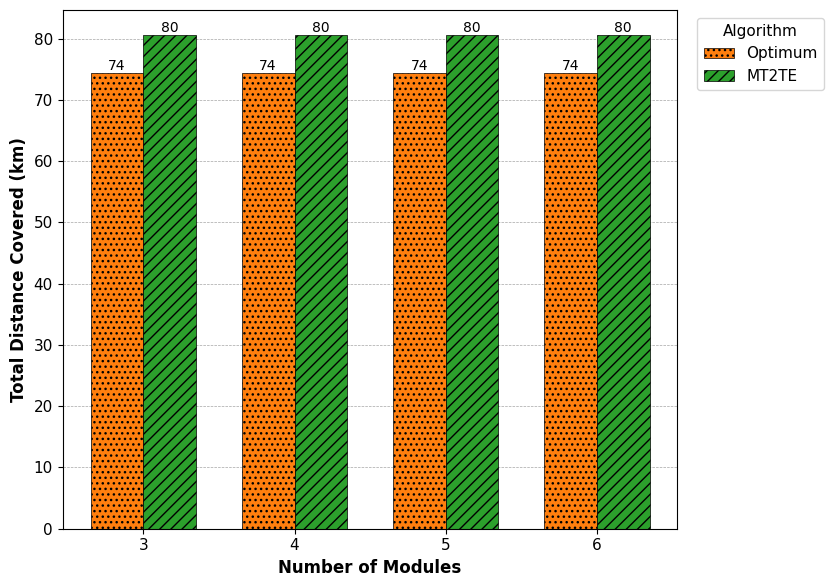

In [21]:
    # Module Change - Total Distance Covered bar chart
create_grouped_bar_chart(df_modules_distance, x_col_modules, 'Total Distance Covered (km)', 'Number of Modules')


# Optimum and MT2TE Swap Time Change

In [22]:
# Load Swap Time Change travel time data
df_swaptime_travel, x_col_swaptime = load_ch_data('travelTime', 'swaptime_change')



## (a) Travel Time

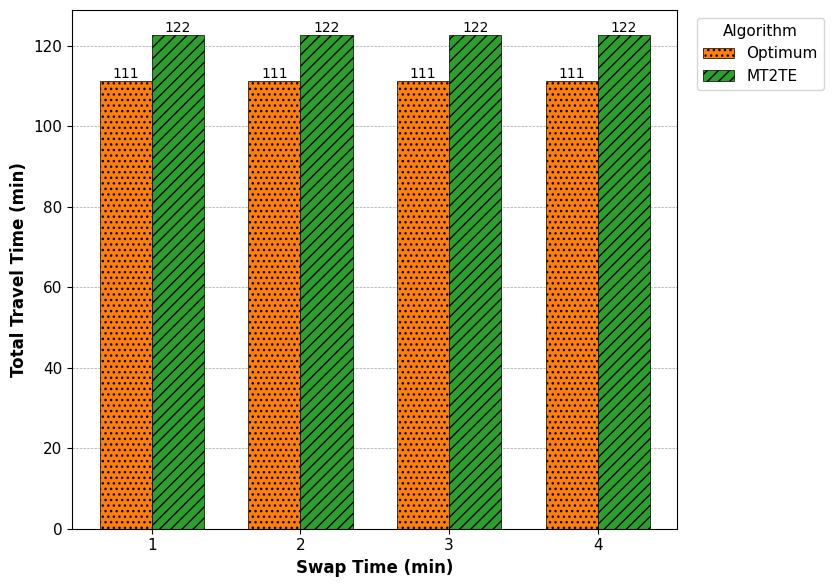

In [23]:
# Swap Time Change - Total Travel Time bar chart
create_grouped_bar_chart(df_swaptime_travel, x_col_swaptime, 'Total Travel Time (min)', 'Swap Time (min)')


In [24]:
# Load Swap Time Change energy data
df_swaptime_energy, _ = load_ch_data('energy', 'swaptime_change')



## (b) Energy

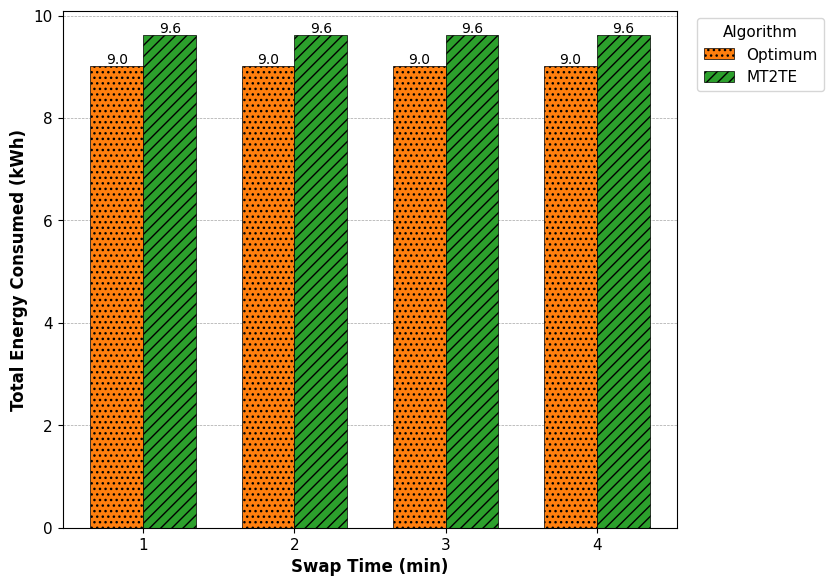

In [25]:
# Swap Time Change - Total Energy Consumed bar chart
create_grouped_bar_chart(df_swaptime_energy, x_col_swaptime, 'Total Energy Consumed (kWh)', 'Swap Time (min)')


In [26]:
# Load Swap Time Change distance data
df_swaptime_distance, _ = load_ch_data('distance', 'swaptime_change')



## (c) Distance

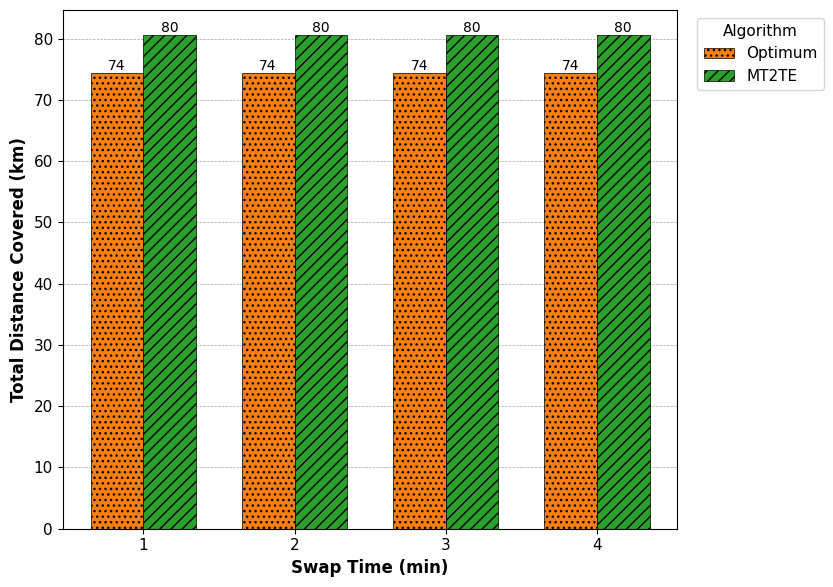

In [27]:
# Swap Time Change - Total Distance Covered bar chart
create_grouped_bar_chart(df_swaptime_distance, x_col_swaptime, 'Total Distance Covered (km)', 'Swap Time (min)')


# Optimum and MT2TE Threshold Change

In [28]:
# Load Threshold Change travel time data
df_threshold_travel, x_col_threshold = load_ch_data('travelTime', 'threshold_change')



## (a) Travel Time

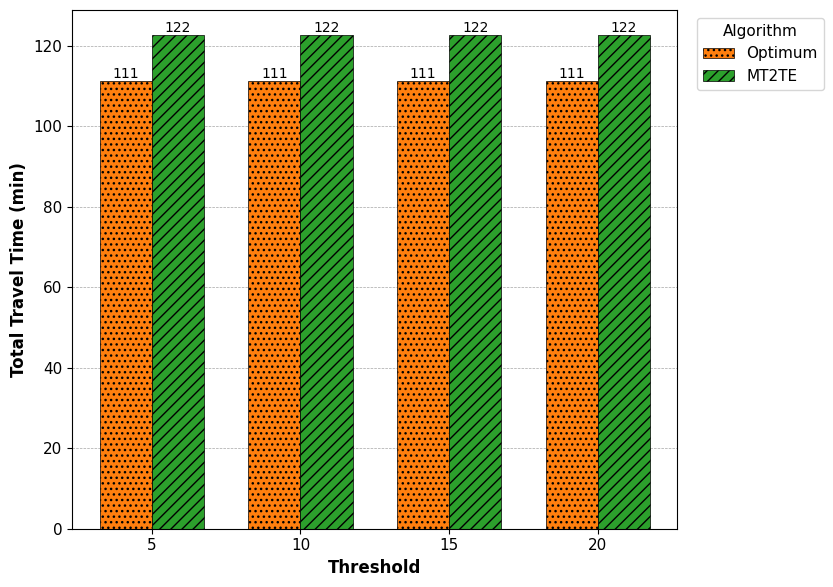

In [29]:
# Threshold Change - Total Travel Time bar chart
create_grouped_bar_chart(df_threshold_travel, x_col_threshold, 'Total Travel Time (min)', 'Threshold')


In [30]:
# Load Threshold Change energy data
df_threshold_energy, _ = load_ch_data('energy', 'threshold_change')



## (b) Energy

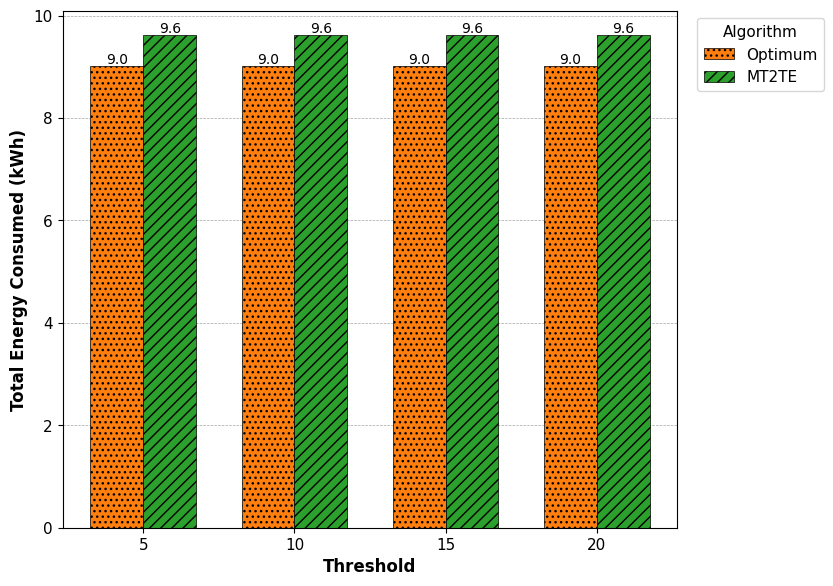

In [31]:
# Threshold Change - Total Energy Consumed bar chart
create_grouped_bar_chart(df_threshold_energy, x_col_threshold, 'Total Energy Consumed (kWh)', 'Threshold')


In [32]:
# Load Threshold Change distance data
df_threshold_distance, _ = load_ch_data('distance', 'threshold_change')


## (c) Distance

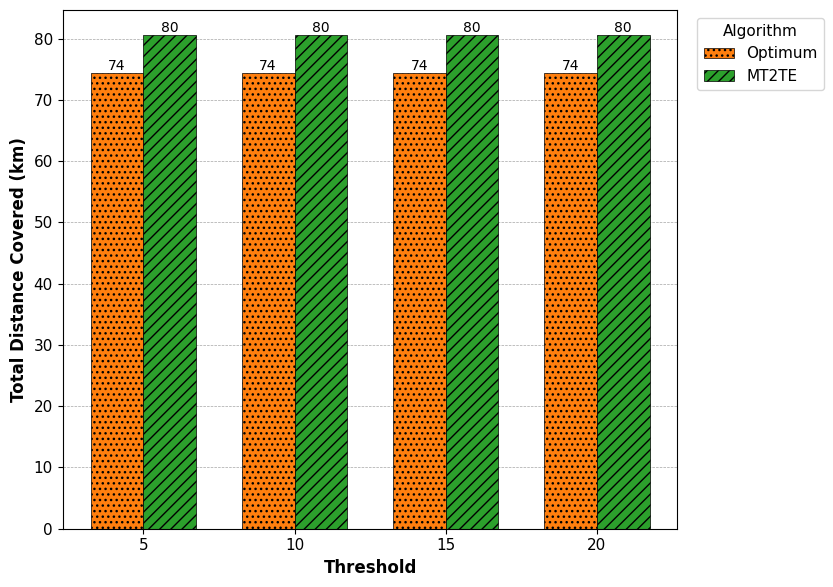

In [33]:
# Threshold Change - Total Distance Covered bar chart
create_grouped_bar_chart(df_threshold_distance, x_col_threshold, 'Total Distance Covered (km)', 'Threshold')


# Optimum and MT2TE Traffic Change

In [34]:
# Load Traffic Change travel time data
df_traffic_travel, x_col_traffic = load_ch_data('travelTime', 'traffic_change')



## (a) Travel Time

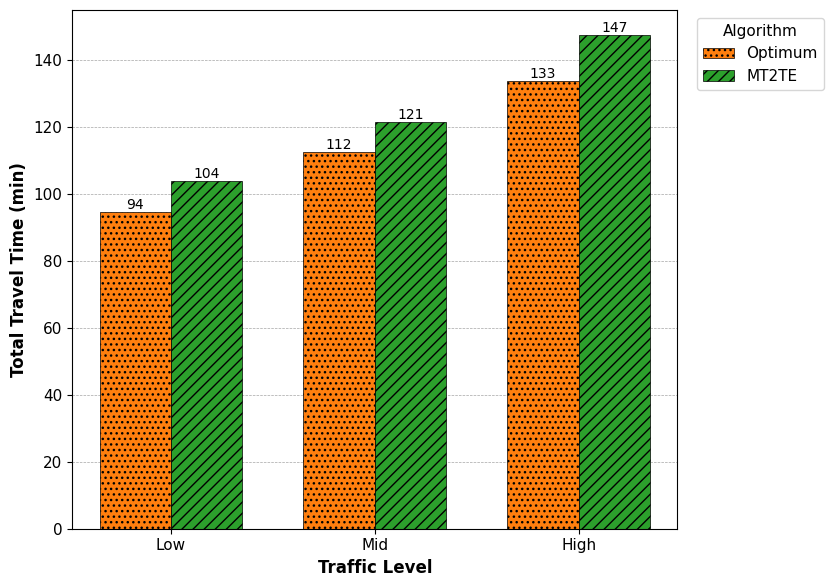

In [35]:
# Traffic Change - Total Travel Time bar chart
create_grouped_bar_chart(df_traffic_travel, x_col_traffic, 'Total Travel Time (min)', 'Traffic Level')


In [36]:
# Load Traffic Change energy data
df_traffic_energy, _ = load_ch_data('energy', 'traffic_change')
print("Traffic Change Energy Data:")
print(df_traffic_energy)


Traffic Change Energy Data:
  trafficLevel  Optimum  EVRPBSS
0          Low     7.68    9.992
1          Mid     9.39    9.542
2         High    11.09    9.138


## (b) Energy

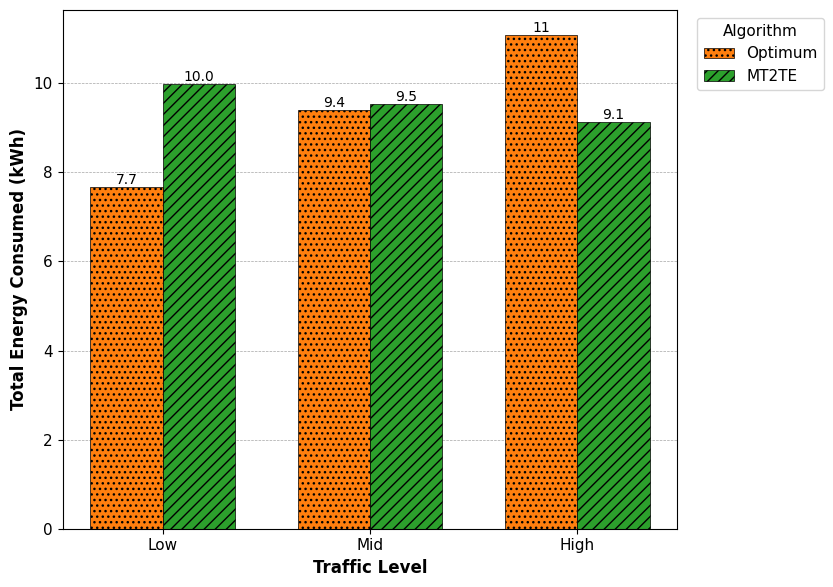

In [37]:
# Traffic Change - Total Energy Consumed bar chart
create_grouped_bar_chart(df_traffic_energy, x_col_traffic, 'Total Energy Consumed (kWh)', 'Traffic Level')


In [38]:
# Load Traffic Change distance data
df_traffic_distance, _ = load_ch_data('distance', 'traffic_change')
print("Traffic Change Distance Data:")
print(df_traffic_distance)


Traffic Change Distance Data:
  trafficLevel  Optimum  EVRPBSS
0          Low    73.83    80.65
1          Mid    74.38    80.65
2         High    73.89    80.65


## (c) Distance

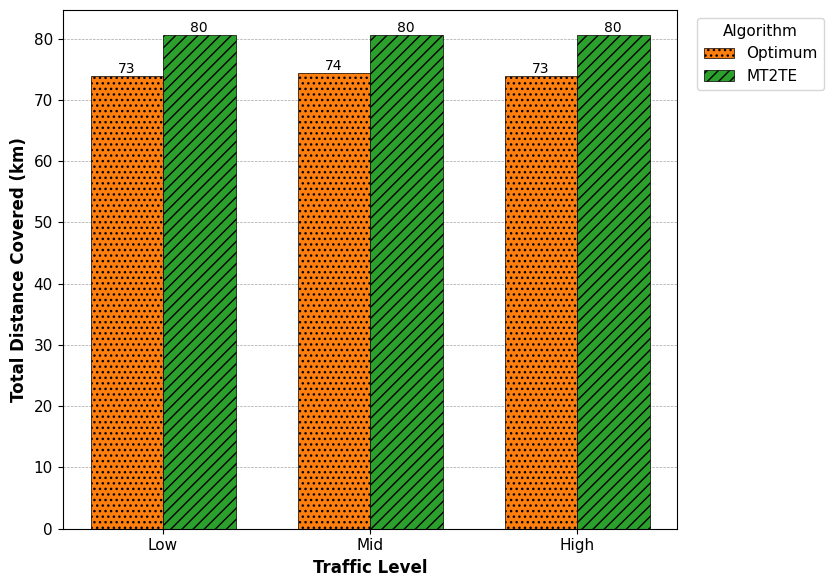

In [39]:
# Traffic Change - Total Distance Covered bar chart
create_grouped_bar_chart(df_traffic_distance, x_col_traffic, 'Total Distance Covered (km)', 'Traffic Level')


In [40]:
# Load distance data
df_distance, x_col = load_ch_data('distance')
print("Distance Data:")
print(df_distance)



Distance Data:
   node  Optimum  EVRPBSS
0    12    65.57    66.59
1    16    74.38    80.65
2    20    80.23    87.78
3    24    98.75   124.35


In [41]:
# Load runtime data
df_runtime, x_col_runtime = load_ch_data('runtime')
print("Runtime Data:")
print(df_runtime)

Runtime Data:
   node  Optimum  EVRPBSS
0    12       12    0.032
1    16      824    0.035
2    20     3454    0.048
3    24     8117    0.094
4    28   298800    0.095


Heuristic Data Visualizations


In [42]:
def load_heuristic_data(node_count, experiment_type):
    """
    Load heuristic data from data_heuristic folder.
    
    Parameters:
    -----------
    node_count : int
        Node count (500, 1000, 1500, 2000)
    experiment_type : str
        Experiment type: 'ModuleChange', 'SwappingTimeChange', 'ThresholdChange', 'TrafficChange'
    
    Returns:
    --------
    DataFrame with experiment data
    """
    # Resolve path - check if running from viz folder or project root
    base_path = Path.cwd()
    if base_path.name == 'viz':
        base_path = base_path.parent
    
    # Handle file naming inconsistencies
    node_str = str(node_count)
    if node_count == 500:
        prefix = f"{node_str}node_"
    elif node_count == 1000:
        # Try both variations
        prefix1 = f"{node_str}node_"
        prefix2 = f"{node_str}nodes_"
    elif node_count in [1500, 2000]:
        prefix = f"{node_str}nodes_"
    else:
        prefix = f"{node_str}node_"
    
    # Map experiment type to filename
    exp_map = {
        'ModuleChange': 'ModuleChange',
        'SwappingTimeChange': 'SwappingTimeChange',
        'ThresholdChange': 'ThresholdChange',
        'TrafficChange': 'TrafficChange'
    }
    
    filename = exp_map.get(experiment_type)
    if filename is None:
        raise ValueError(f"Unknown experiment type: {experiment_type}")
    
    # Try different file naming patterns
    if node_count == 1000:
        # Try both variations for 1000
        file_path1 = base_path / 'data_heuristic' / node_str / f"{prefix1}{filename}.csv"
        file_path2 = base_path / 'data_heuristic' / node_str / f"{prefix2}{filename}.csv"
        if file_path1.exists():
            file_path = file_path1
        elif file_path2.exists():
            file_path = file_path2
        else:
            # Try with underscore
            file_path3 = base_path / 'data_heuristic' / node_str / f"{node_str}_{filename}.csv"
            if file_path3.exists():
                file_path = file_path3
            else:
                raise FileNotFoundError(f"Could not find file for {node_count} nodes, {experiment_type}")
    else:
        file_path = base_path / 'data_heuristic' / node_str / f"{prefix}{filename}.csv"
        if not file_path.exists():
            # Try with underscore
            file_path = base_path / 'data_heuristic' / node_str / f"{node_str}_{filename}.csv"
            if not file_path.exists():
                raise FileNotFoundError(f"Could not find file: {file_path}")
    
    # Load CSV
    df = pd.read_csv(file_path)
    
    # Handle Traffic column name inconsistency and normalize values
    if experiment_type == 'TrafficChange':
        first_col = df.columns[0]
        # Always rename first column to 'Traffic' for TrafficChange experiments
        if first_col != 'Traffic':
            df = df.rename(columns={first_col: 'Traffic'})
        # Normalize traffic values: High_Traffic -> High, mid -> Mid, Low -> Low
        if df['Traffic'].dtype == 'object':
            df['Traffic'] = df['Traffic'].str.replace('High_Traffic', 'High', case=False)
            df['Traffic'] = df['Traffic'].str.replace('^mid$', 'Mid', case=False, regex=True)
            df['Traffic'] = df['Traffic'].str.replace('^low$', 'Low', case=False, regex=True)
    
    return df


In [43]:
def create_simple_bar_chart(df, x_column, y_column, title=None, ylabel=None, width=0.4):
    """
    Create a simple bar chart for heuristic data (single series, no algorithms).
    
    Parameters:
    -----------
    df : DataFrame
        Data with x_column and y_column
    x_column : str
        Name of the x-axis column
    y_column : str
        Name of the y-axis column to plot
    title : str, optional
        Chart title
    ylabel : str, optional
        Y-axis label (default: y_column)
    width : float, optional
        Width of bars (default: 0.6 for consistent slim bars)
    """
    # Handle Traffic ordering (Low, Mid, High)
    if x_column == 'Traffic' or (x_column in df.columns and set(df[x_column].values).issubset({'High', 'Mid', 'Low'})):
        traffic_order = {'Low': 1, 'Mid': 2, 'High': 3}
        df['_sort_order'] = df[x_column].map(traffic_order)
        df_sorted = df.sort_values('_sort_order')
        df_sorted = df_sorted.drop(columns=['_sort_order'])
    else:
        df_sorted = df.sort_values(x_column)
    
    x_values = df_sorted[x_column].values
    y_values = df_sorted[y_column].values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # For numeric x-axis values, use positions to ensure proper bar chart display
    if pd.api.types.is_numeric_dtype(df_sorted[x_column]):
        # Use positions for numeric x-axis to ensure bars display correctly
        x_positions = range(len(x_values))
        bars = ax.bar(x_positions, y_values, 
                      width=width,
                      color='#1f77b4',  # Blue color
                      edgecolor='black', 
                      linewidth=0.5)
        # Set x-axis ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_values)
    else:
        # For categorical/string values, use values directly
        bars = ax.bar(x_values, y_values, 
                      width=width,
                      color='#1f77b4',  # Blue color
                      edgecolor='black', 
                      linewidth=0.5)
        # Set x-axis ticks to only show values where bars exist
        ax.set_xticks(x_values)
    
    # Add value labels on top of bars
    for bar, val in zip(bars, y_values):
        height = bar.get_height()
        # Format value based on magnitude
        if val < 10:
            label_text = f'{val:.2f}'
        elif val < 100:
            label_text = f'{val:.1f}'
        else:
            label_text = f'{int(val)}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
               label_text,
               ha='center', va='bottom',
               fontsize=10, fontweight='normal')
    
    # Customize axes
    ax.set_xlabel(x_column, fontweight='bold')
    ax.set_ylabel(ylabel or y_column, fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    
    # Calculate smart y-axis range to make differences visible
    y_min = min(y_values)
    y_max = max(y_values)
    y_range = y_max - y_min
    
    # If all values are positive and range is significant, adjust bottom to show differences better
    if y_min > 0 and y_range > 0:
        # Use 5% of range as padding below minimum, but ensure we don't go below 0
        # If the minimum is large relative to range, use a percentage-based approach
        if y_min > y_range * 0.5:
            # Large minimum relative to range - use percentage of min
            y_bottom = max(0, y_min * 0.95)
        else:
            # Small minimum relative to range - use range-based padding
            y_bottom = max(0, y_min - (y_range * 0.1))
        
        # Set y-axis limits with calculated bottom
        ax.set_ylim(bottom=y_bottom, top=y_max * 1.05)
    else:
        # If values are close to zero or negative, start from 0
        ax.set_ylim(bottom=0, top=y_max * 1.05)
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax


In [44]:
def create_multi_line_chart(data_dict, metric_column, title=None, ylabel=None):
    """
    Create a multi-line chart showing how different parameter values change across node counts.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary with keys as line labels (e.g., '4 Module', '5 Threshold') 
        and values as lists of metric values for [500, 1000, 1500, 2000] nodes
    metric_column : str
        Name of the metric (for title/ylabel)
    title : str, optional
        Chart title
    ylabel : str, optional
        Y-axis label
    """
    node_counts = [500, 1000, 1500, 2000]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define colors and markers for different lines
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']
    
    # Plot each line
    for i, (label, values) in enumerate(data_dict.items()):
        if len(values) != len(node_counts):
            continue
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        ax.plot(node_counts, values, 
               marker=marker, 
               linewidth=2, 
               markersize=8,
               label=label,
               color=color)
    
    # Customize axes
    ax.set_xlabel('Number of Nodes', fontweight='bold')
    ax.set_ylabel(ylabel or metric_column, fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    
    ax.set_xticks(node_counts)
    ax.legend(title='Parameter', title_fontsize=11, fontsize=10, frameon=True, 
              loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.set_axisbelow(True)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for legend
    plt.show()
    
    return fig, ax


# 500 nodes Module Change


In [45]:
# Load 500 nodes Module Change data
df_500_module = load_heuristic_data(500, 'ModuleChange')



## (a) Travel Time bar chart


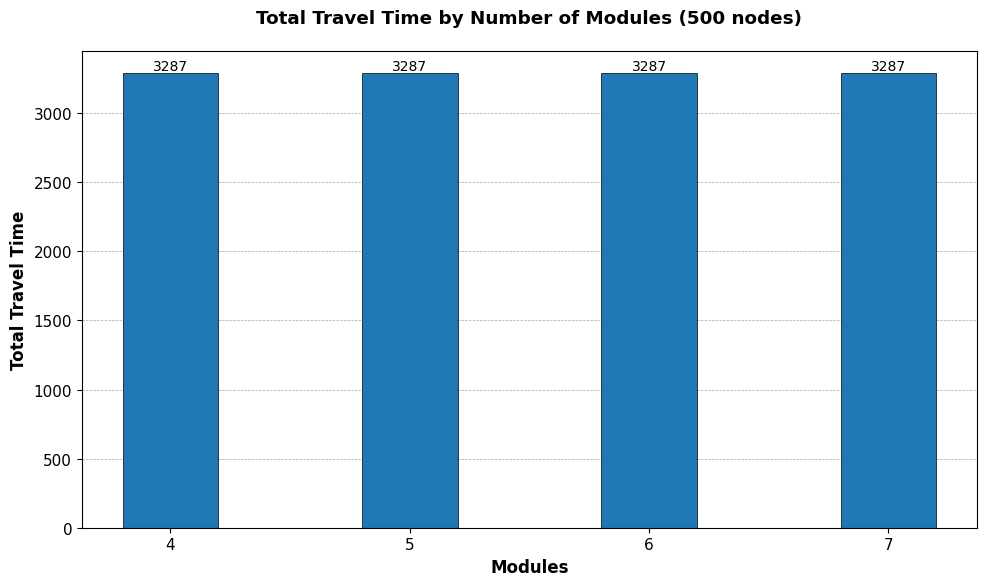

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Modules (500 nodes)'}, xlabel='Modules', ylabel='Total Travel Time'>)

In [46]:
create_simple_bar_chart(
    df_500_module,
    'Modules',
    'Total Travel Time',
    title='Total Travel Time by Number of Modules (500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


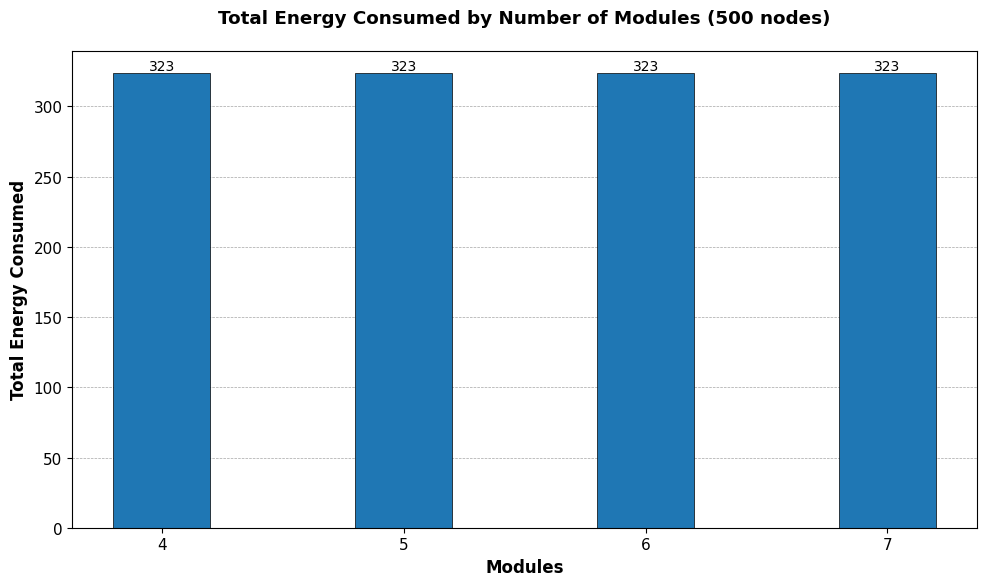

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Modules (500 nodes)'}, xlabel='Modules', ylabel='Total Energy Consumed'>)

In [47]:
create_simple_bar_chart(
    df_500_module,
    'Modules',
    'Total Energy Consumed',
    title='Total Energy Consumed by Number of Modules (500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


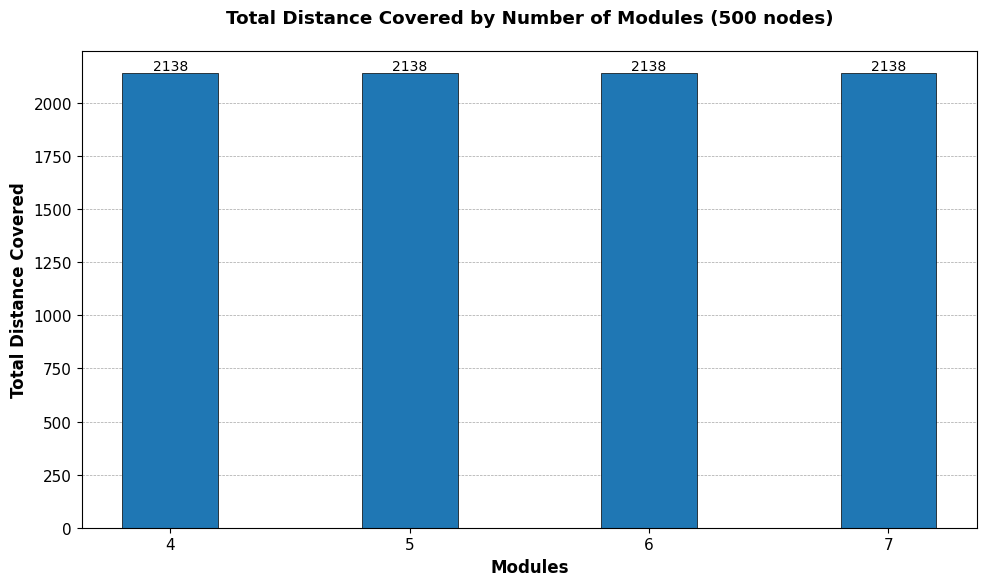

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Modules (500 nodes)'}, xlabel='Modules', ylabel='Total Distance Covered'>)

In [48]:
create_simple_bar_chart(
    df_500_module,
    'Modules',
    'Total Distance Covered',
    title='Total Distance Covered by Number of Modules (500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


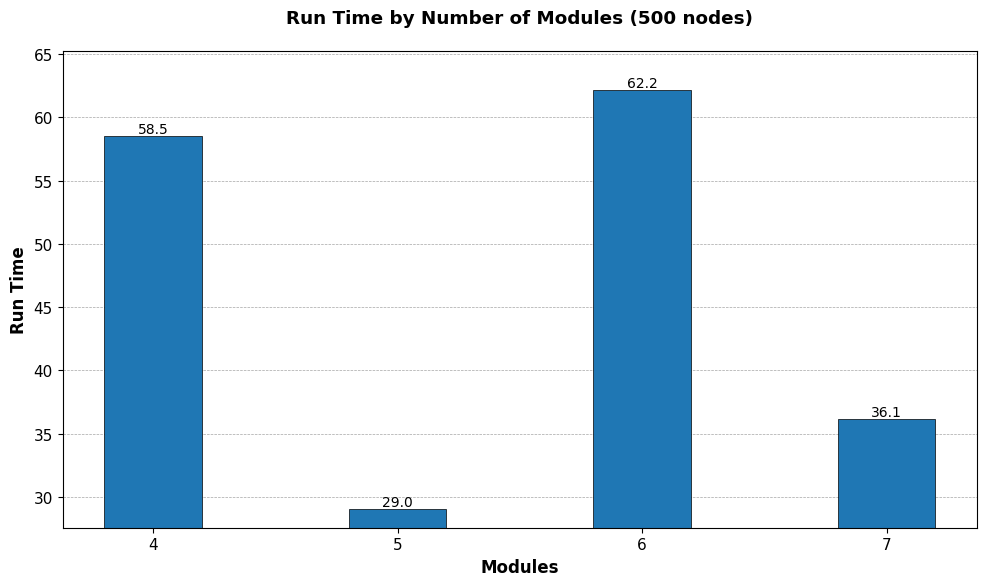

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Modules (500 nodes)'}, xlabel='Modules', ylabel='Run Time'>)

In [49]:
create_simple_bar_chart(
    df_500_module,
    'Modules',
    'Run Time',
    title='Run Time by Number of Modules (500 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


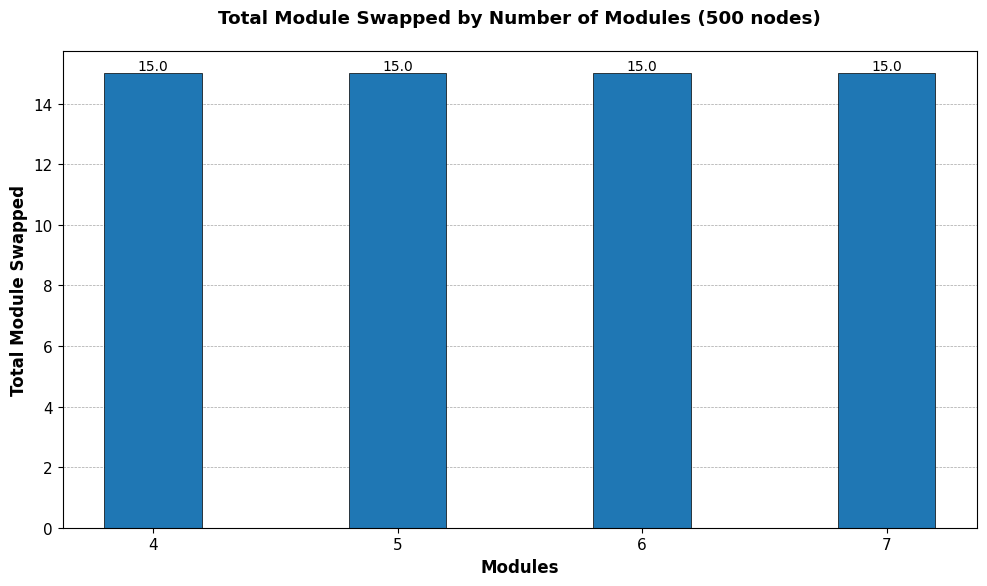

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Modules (500 nodes)'}, xlabel='Modules', ylabel='Total Module Swapped'>)

In [50]:
create_simple_bar_chart(
    df_500_module,
    'Modules',
    'Total Module Swapped',
    title='Total Module Swapped by Number of Modules (500 nodes)',
    ylabel='Total Module Swapped'
)


# 500 nodes Swapping Time


In [51]:
# Load 500 nodes Swapping Time data
df_500_swap = load_heuristic_data(500, 'SwappingTimeChange')
print("500 nodes Swapping Time Data:")
print(df_500_swap)


500 nodes Swapping Time Data:
   Swapping Time  Total Travel Time  Total Energy Consumed  \
0              1            3268.67                323.439   
1              2            3287.54                323.496   
2              3            3302.54                323.496   
3              4            3317.54                323.496   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 2138.07    27.754                    14  
1                 2138.91    29.015                    15  
2                 2138.91    27.731                    15  
3                 2138.91    28.572                    15  


## (a) Travel Time bar chart


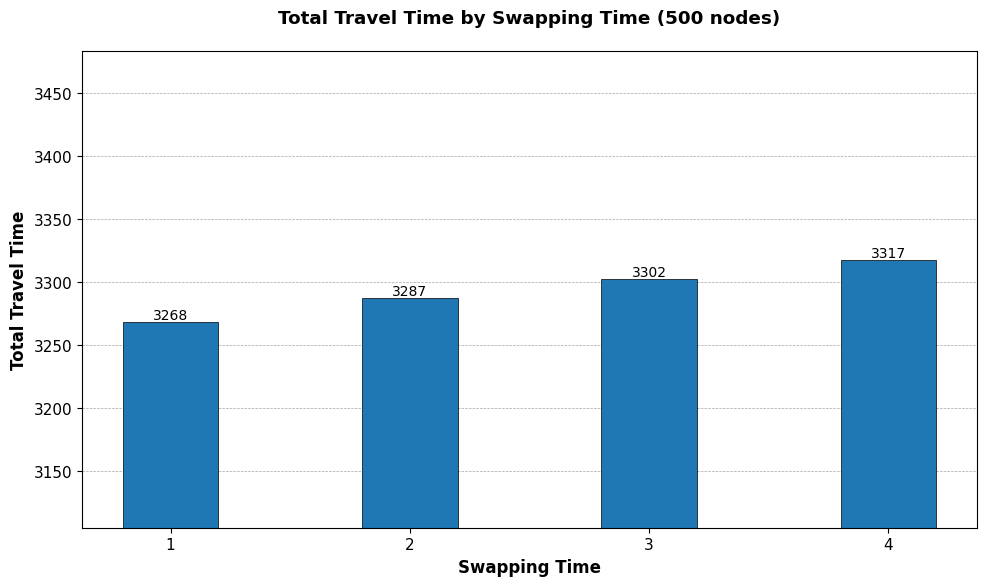

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Swapping Time (500 nodes)'}, xlabel='Swapping Time', ylabel='Total Travel Time'>)

In [52]:
create_simple_bar_chart(
    df_500_swap,
    'Swapping Time',
    'Total Travel Time',
    title='Total Travel Time by Swapping Time (500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


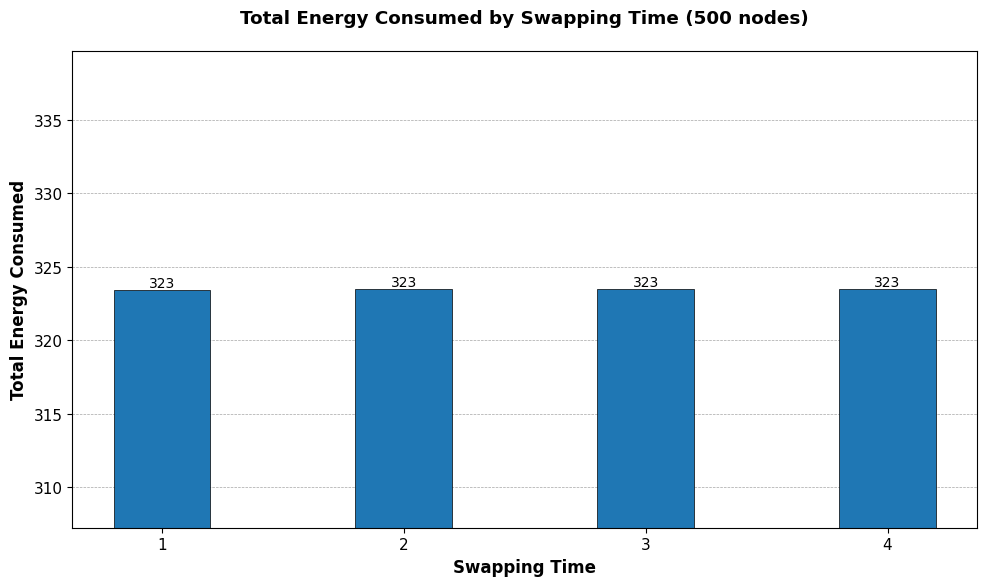

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Swapping Time (500 nodes)'}, xlabel='Swapping Time', ylabel='Total Energy Consumed'>)

In [53]:
create_simple_bar_chart(
    df_500_swap,
    'Swapping Time',
    'Total Energy Consumed',
    title='Total Energy Consumed by Swapping Time (500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


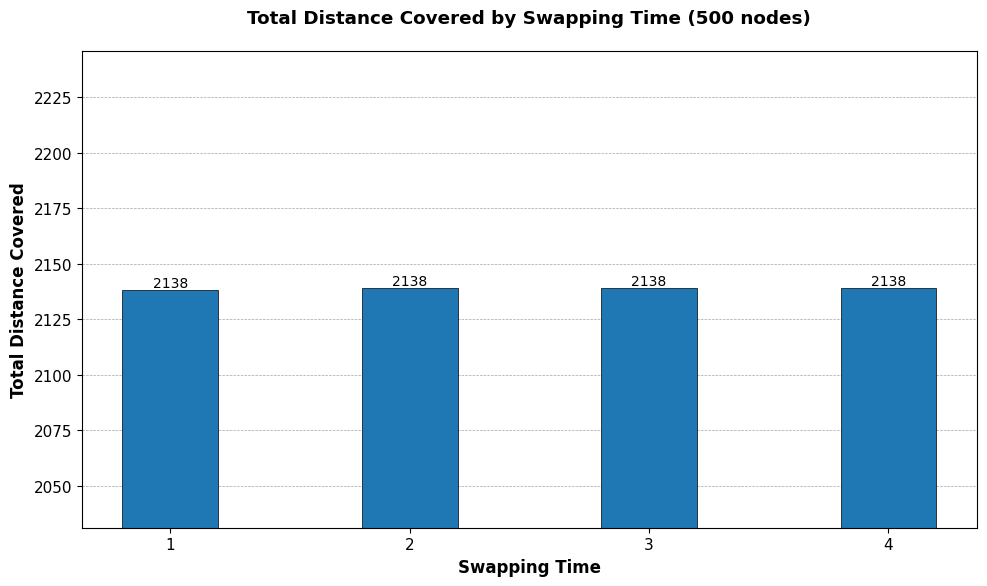

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Swapping Time (500 nodes)'}, xlabel='Swapping Time', ylabel='Total Distance Covered'>)

In [54]:
create_simple_bar_chart(
    df_500_swap,
    'Swapping Time',
    'Total Distance Covered',
    title='Total Distance Covered by Swapping Time (500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


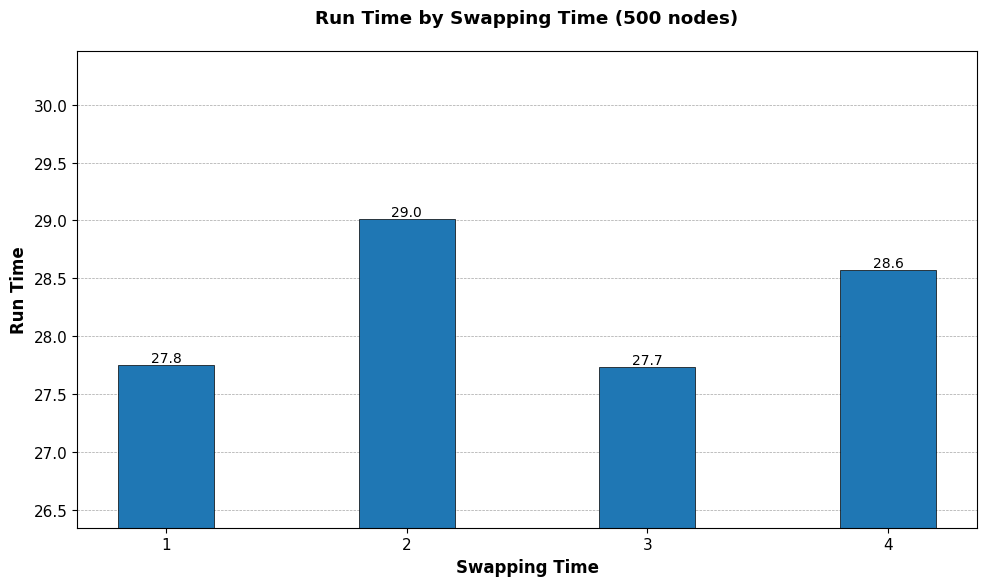

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Swapping Time (500 nodes)'}, xlabel='Swapping Time', ylabel='Run Time'>)

In [55]:
create_simple_bar_chart(
    df_500_swap,
    'Swapping Time',
    'Run Time',
    title='Run Time by Swapping Time (500 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


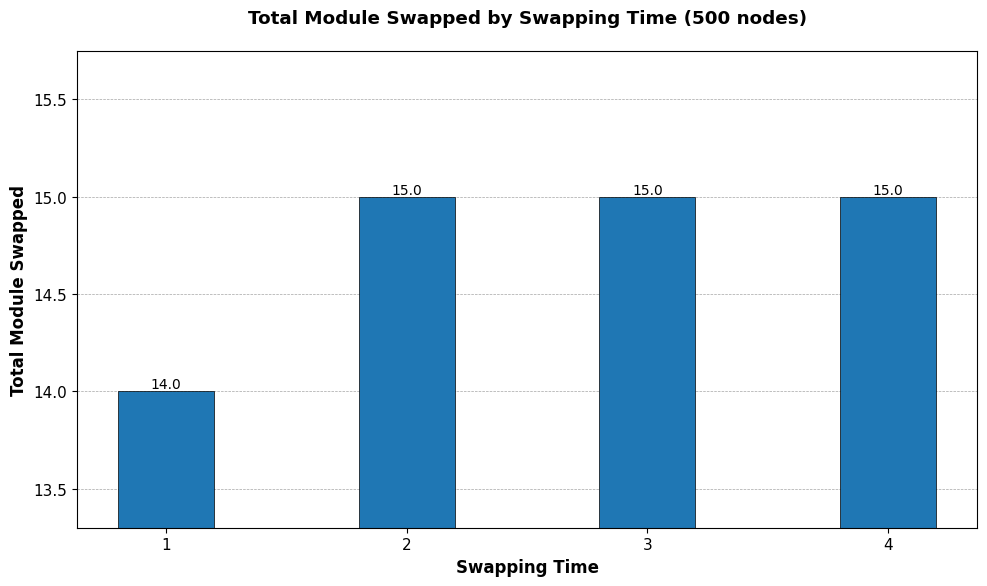

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Swapping Time (500 nodes)'}, xlabel='Swapping Time', ylabel='Total Module Swapped'>)

In [56]:
create_simple_bar_chart(
    df_500_swap,
    'Swapping Time',
    'Total Module Swapped',
    title='Total Module Swapped by Swapping Time (500 nodes)',
    ylabel='Total Module Swapped'
)


# 500 nodes Threshold


In [57]:
# Load 500 nodes Threshold data
df_500_threshold = load_heuristic_data(500, 'ThresholdChange')
print("500 nodes Threshold Data:")
print(df_500_threshold)


500 nodes Threshold Data:
   Threshold  Total Travel Time  Total Energy Consumed  \
0          5            3287.54                323.496   
1         10            3287.54                323.496   
2         15            3287.54                323.496   
3         20            3287.54                323.496   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 2138.91    58.342                    15  
1                 2138.91    66.469                    15  
2                 2138.91    30.661                    15  
3                 2138.91    29.015                    15  


## (a) Travel Time bar chart


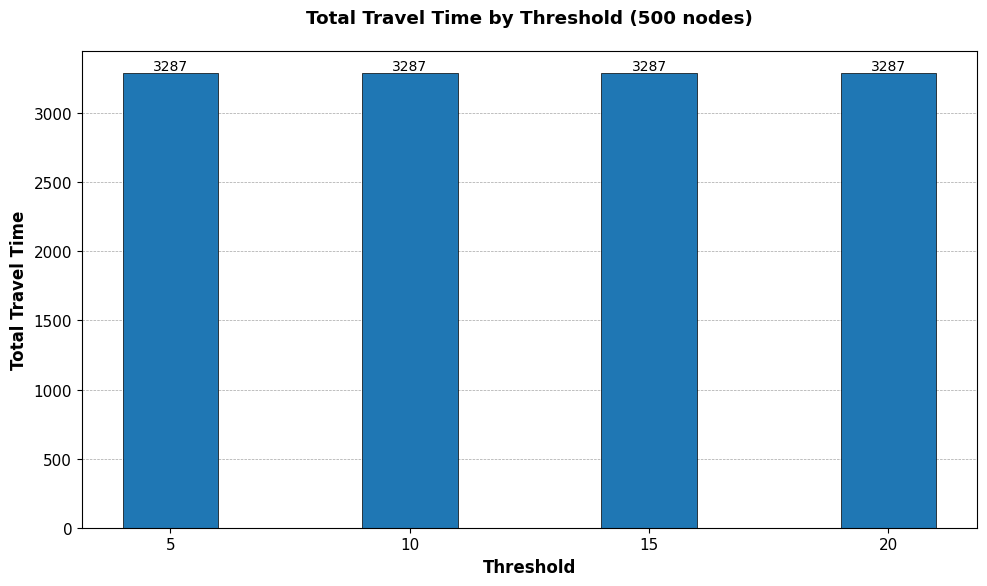

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Threshold (500 nodes)'}, xlabel='Threshold', ylabel='Total Travel Time'>)

In [58]:
create_simple_bar_chart(
    df_500_threshold,
    'Threshold',
    'Total Travel Time',
    title='Total Travel Time by Threshold (500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


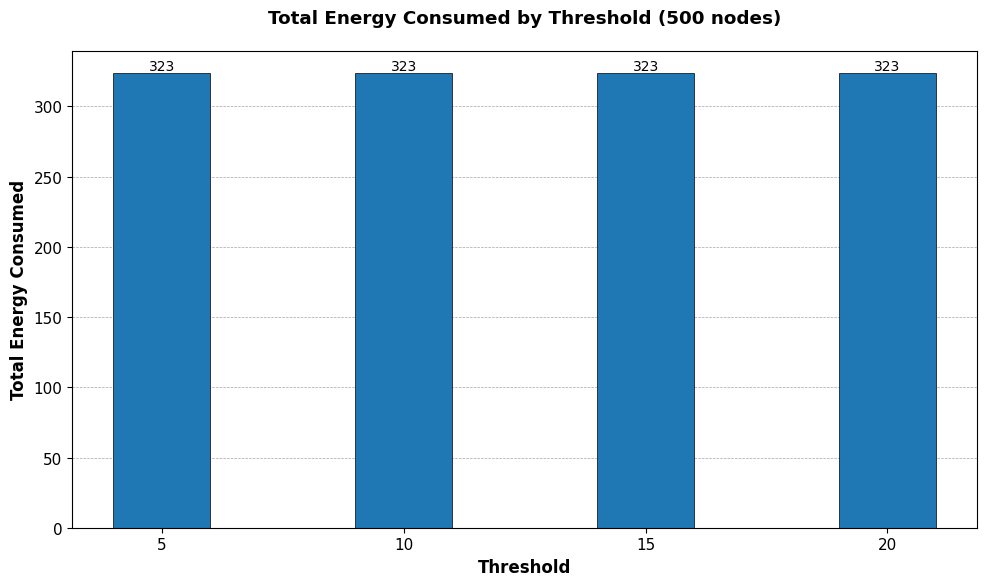

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Threshold (500 nodes)'}, xlabel='Threshold', ylabel='Total Energy Consumed'>)

In [59]:
create_simple_bar_chart(
    df_500_threshold,
    'Threshold',
    'Total Energy Consumed',
    title='Total Energy Consumed by Threshold (500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


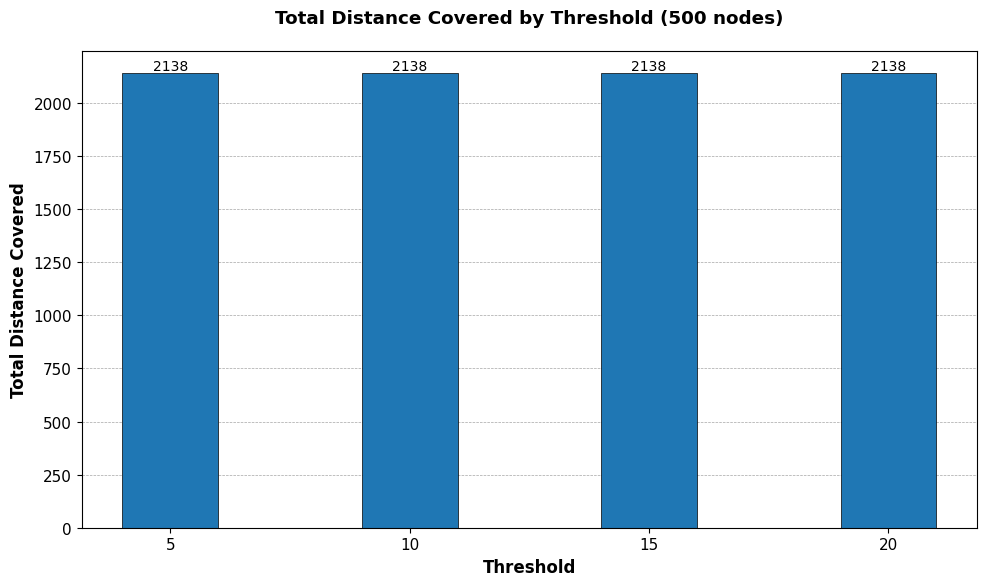

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Threshold (500 nodes)'}, xlabel='Threshold', ylabel='Total Distance Covered'>)

In [60]:
create_simple_bar_chart(
    df_500_threshold,
    'Threshold',
    'Total Distance Covered',
    title='Total Distance Covered by Threshold (500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


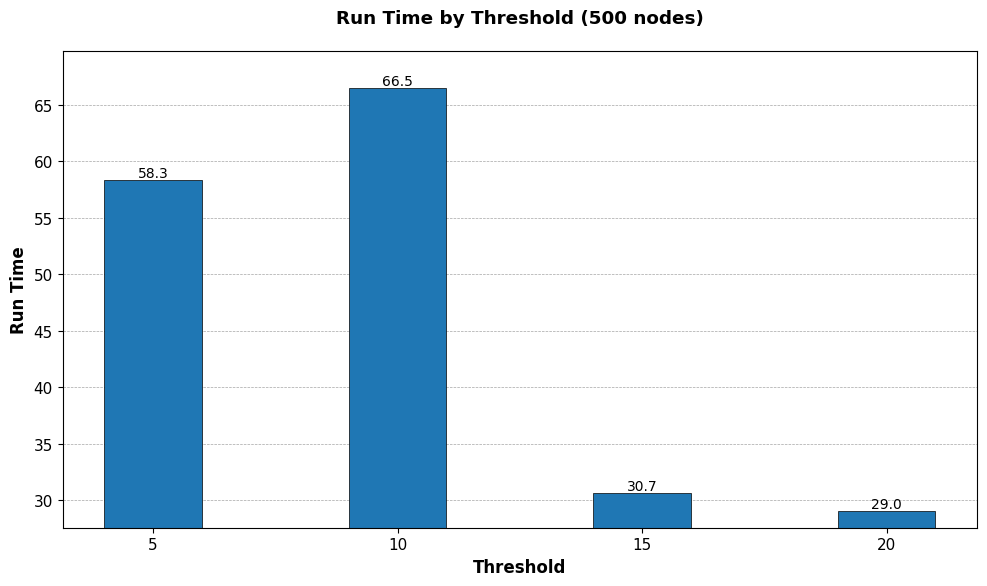

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Threshold (500 nodes)'}, xlabel='Threshold', ylabel='Run Time'>)

In [61]:
create_simple_bar_chart(
    df_500_threshold,
    'Threshold',
    'Run Time',
    title='Run Time by Threshold (500 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


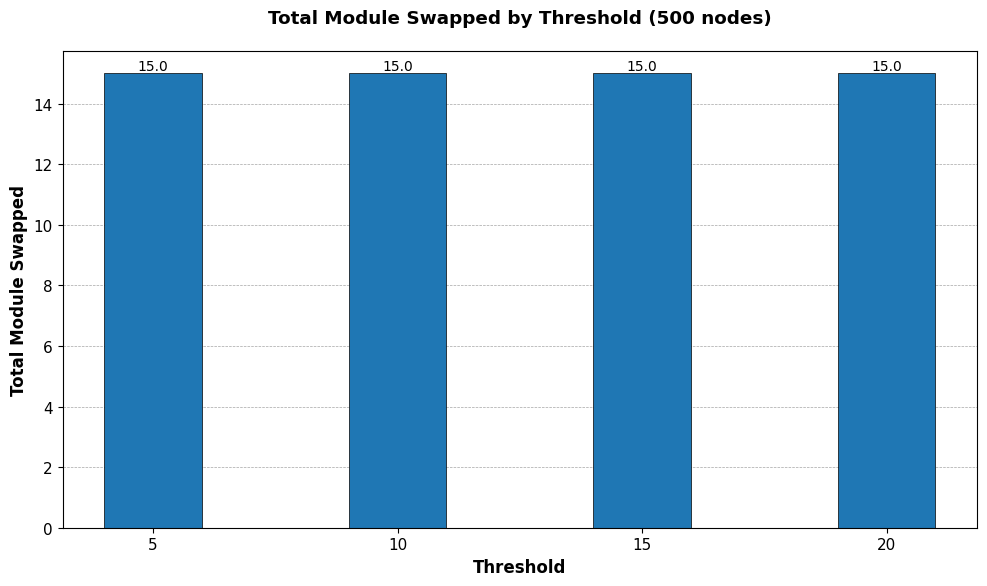

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Threshold (500 nodes)'}, xlabel='Threshold', ylabel='Total Module Swapped'>)

In [62]:
create_simple_bar_chart(
    df_500_threshold,
    'Threshold',
    'Total Module Swapped',
    title='Total Module Swapped by Threshold (500 nodes)',
    ylabel='Total Module Swapped'
)


# 500 nodes Traffic


In [63]:
# Load 500 nodes Traffic data
df_500_traffic = load_heuristic_data(500, 'TrafficChange')
print("500 nodes Traffic Data:")
print(df_500_traffic)


500 nodes Traffic Data:
  Traffic  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0    High            3618.28                287.802                 1986.78   
1     Mid            3049.93                299.981                 2004.56   
2     Low            2915.88                351.096                 2241.45   

   Run Time  Total Module Swapped  
0    37.233                    12  
1    46.990                    13  
2    54.488                    16  


## (a) Travel Time bar chart


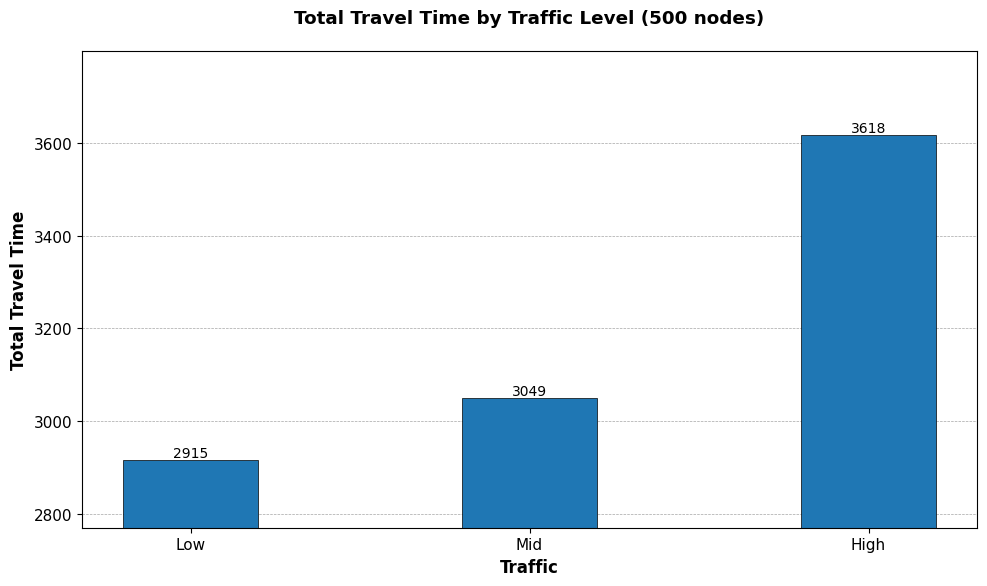

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Traffic Level (500 nodes)'}, xlabel='Traffic', ylabel='Total Travel Time'>)

In [64]:
create_simple_bar_chart(
    df_500_traffic,
    'Traffic',
    'Total Travel Time',
    title='Total Travel Time by Traffic Level (500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


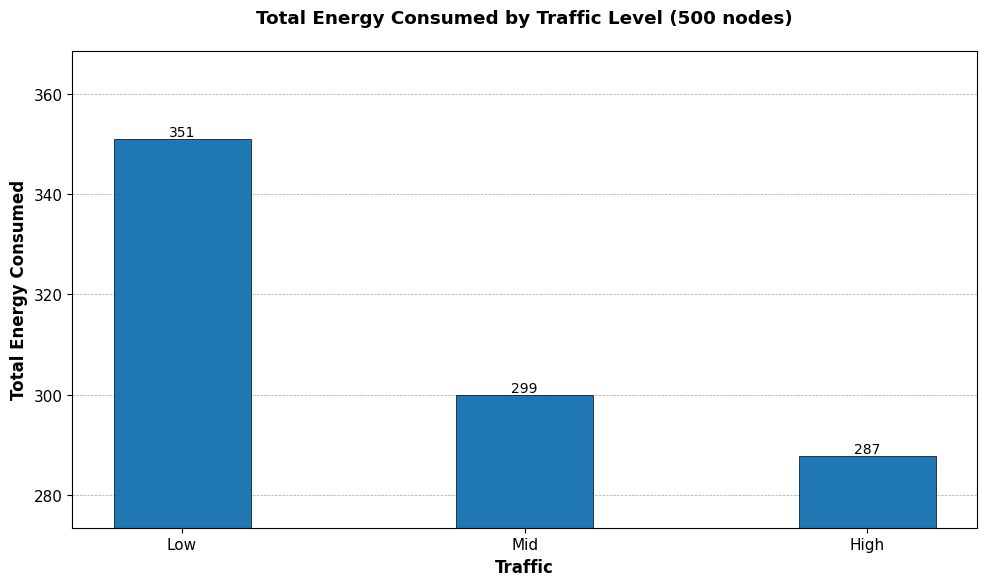

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Traffic Level (500 nodes)'}, xlabel='Traffic', ylabel='Total Energy Consumed'>)

In [65]:
create_simple_bar_chart(
    df_500_traffic,
    'Traffic',
    'Total Energy Consumed',
    title='Total Energy Consumed by Traffic Level (500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


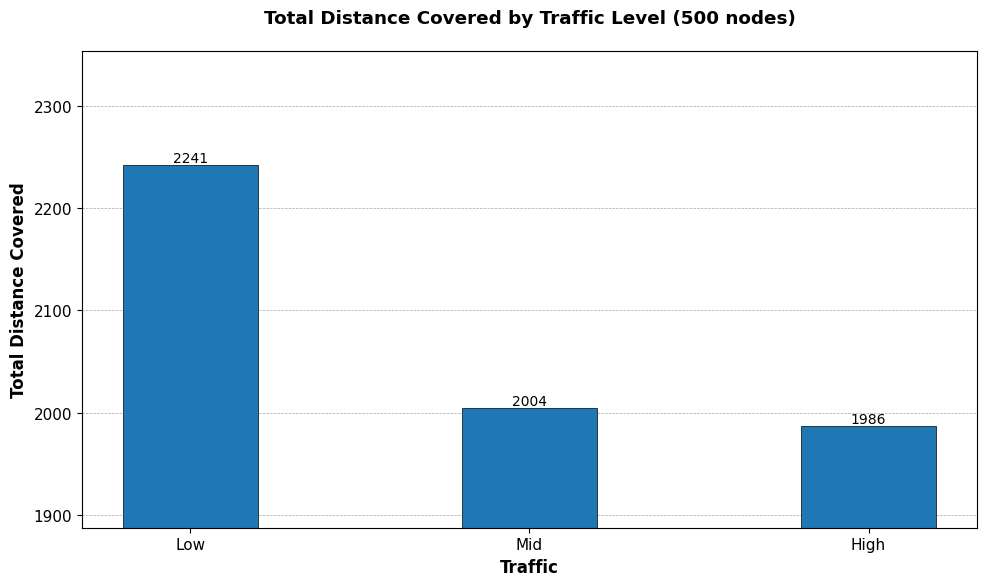

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Traffic Level (500 nodes)'}, xlabel='Traffic', ylabel='Total Distance Covered'>)

In [66]:
create_simple_bar_chart(
    df_500_traffic,
    'Traffic',
    'Total Distance Covered',
    title='Total Distance Covered by Traffic Level (500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


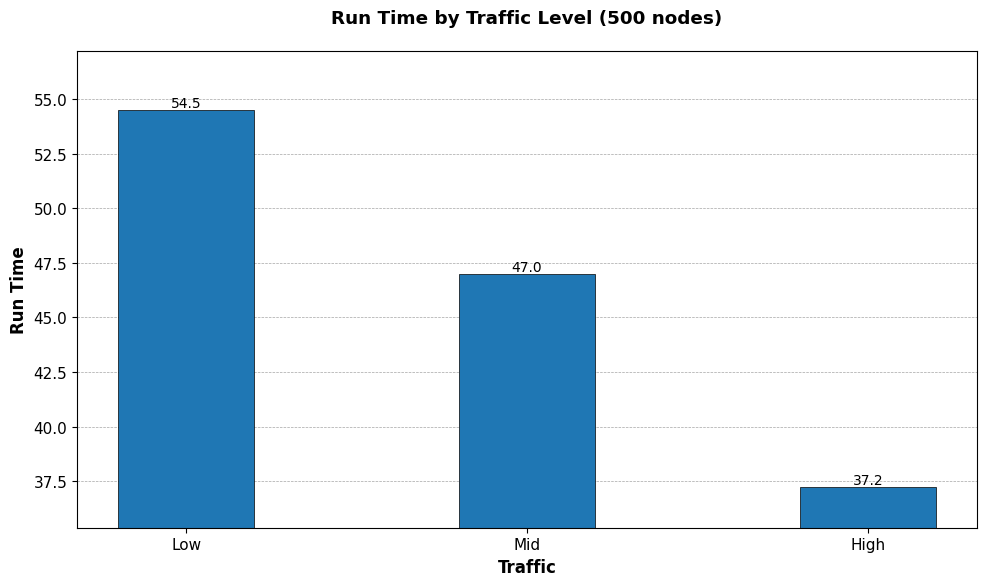

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Traffic Level (500 nodes)'}, xlabel='Traffic', ylabel='Run Time'>)

In [67]:
create_simple_bar_chart(
    df_500_traffic,
    'Traffic',
    'Run Time',
    title='Run Time by Traffic Level (500 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


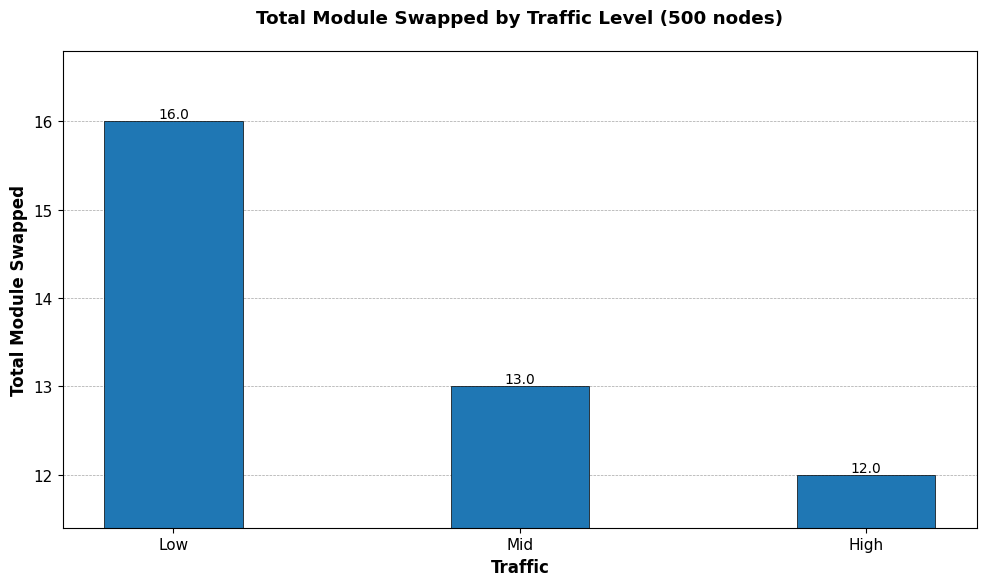

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Traffic Level (500 nodes)'}, xlabel='Traffic', ylabel='Total Module Swapped'>)

In [68]:
create_simple_bar_chart(
    df_500_traffic,
    'Traffic',
    'Total Module Swapped',
    title='Total Module Swapped by Traffic Level (500 nodes)',
    ylabel='Total Module Swapped'
)


# 1000 nodes Module Change


In [69]:
# Load 1000 nodes Module Change data
df_1000_module = load_heuristic_data(1000, 'ModuleChange')
print("1000 nodes Module Change Data:")
print(df_1000_module)


1000 nodes Module Change Data:
   Modules  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0        4            6779.83                793.935                 4422.50   
1        5            6808.90                795.158                 4437.52   
2        6            6808.90                795.158                 4437.52   
3        7            6808.90                795.158                 4437.52   

   Run Time  Total Module Swapped  
0   187.287                    39  
1   396.099                    37  
2   226.124                    37  
3   226.357                    37  


## (a) Travel Time bar chart


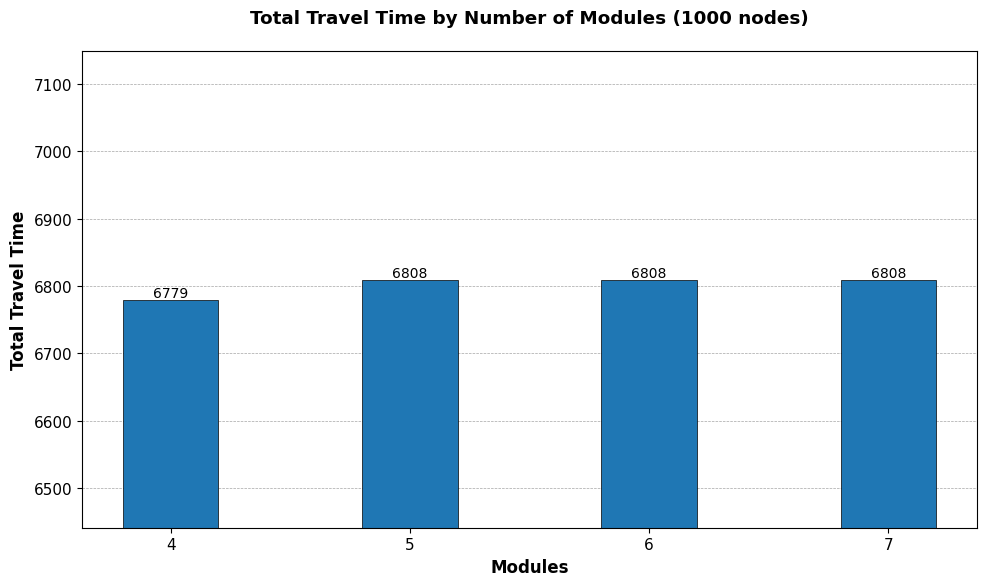

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Modules (1000 nodes)'}, xlabel='Modules', ylabel='Total Travel Time'>)

In [70]:
create_simple_bar_chart(
    df_1000_module,
    'Modules',
    'Total Travel Time',
    title='Total Travel Time by Number of Modules (1000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


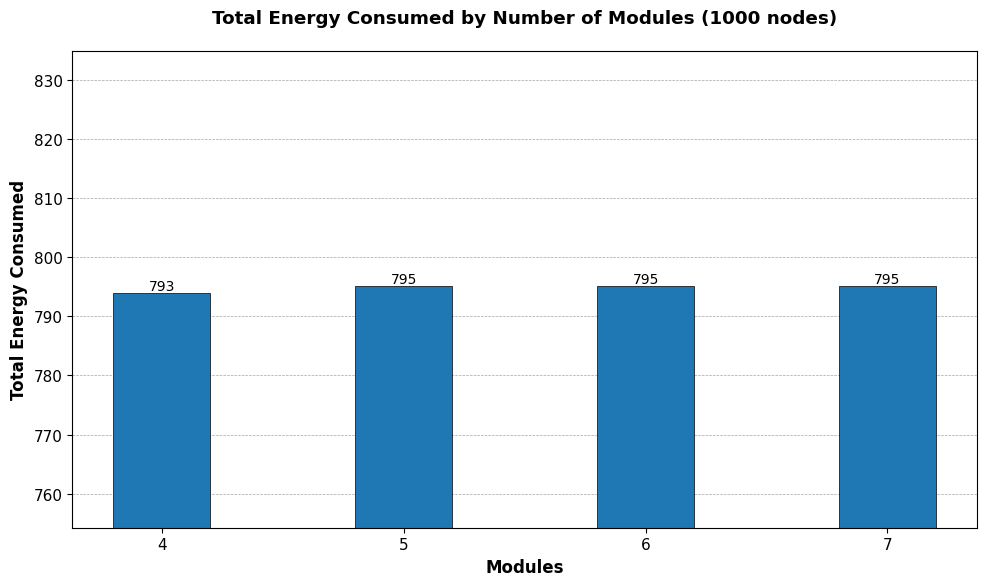

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Modules (1000 nodes)'}, xlabel='Modules', ylabel='Total Energy Consumed'>)

In [71]:
create_simple_bar_chart(
    df_1000_module,
    'Modules',
    'Total Energy Consumed',
    title='Total Energy Consumed by Number of Modules (1000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


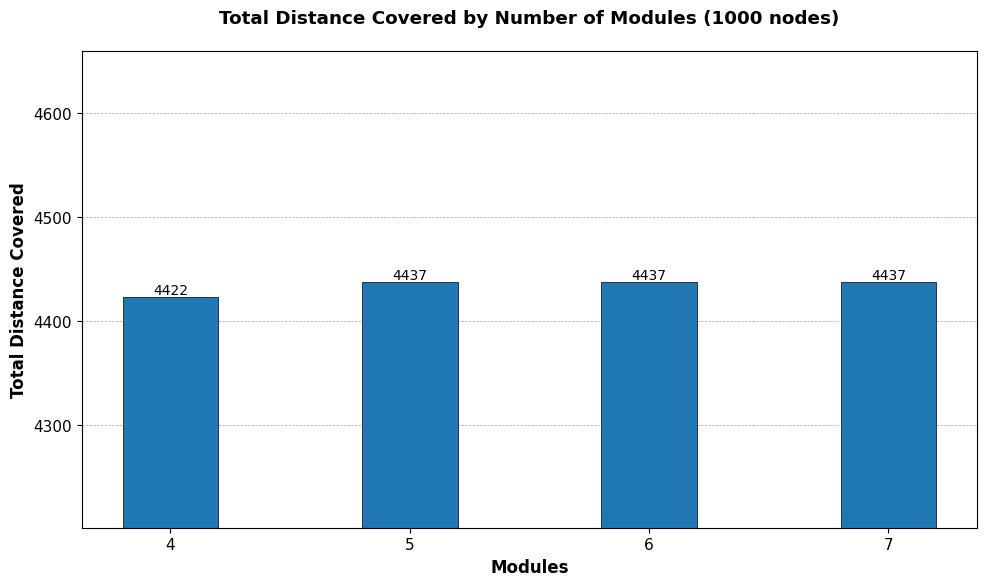

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Modules (1000 nodes)'}, xlabel='Modules', ylabel='Total Distance Covered'>)

In [72]:
create_simple_bar_chart(
    df_1000_module,
    'Modules',
    'Total Distance Covered',
    title='Total Distance Covered by Number of Modules (1000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


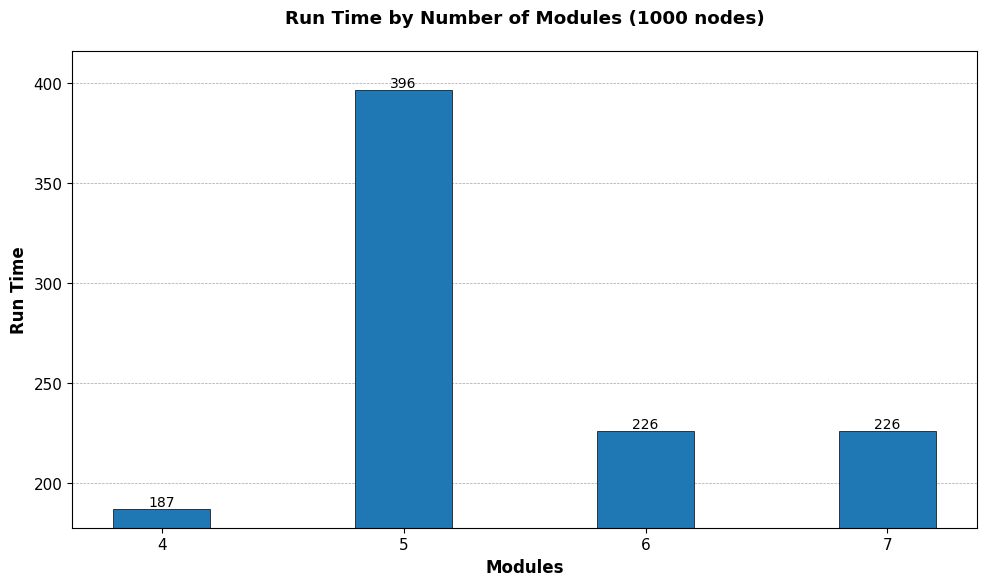

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Modules (1000 nodes)'}, xlabel='Modules', ylabel='Run Time'>)

In [73]:
create_simple_bar_chart(
    df_1000_module,
    'Modules',
    'Run Time',
    title='Run Time by Number of Modules (1000 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


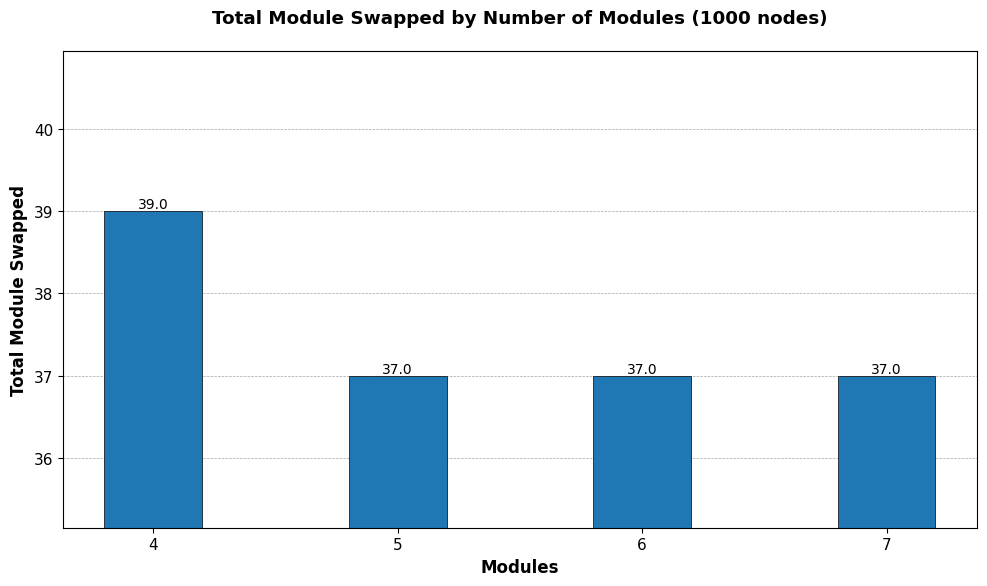

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Modules (1000 nodes)'}, xlabel='Modules', ylabel='Total Module Swapped'>)

In [74]:
create_simple_bar_chart(
    df_1000_module,
    'Modules',
    'Total Module Swapped',
    title='Total Module Swapped by Number of Modules (1000 nodes)',
    ylabel='Total Module Swapped'
)


# 1000 nodes Swapping Time


In [75]:
# Load 1000 nodes Swapping Time data
df_1000_swap = load_heuristic_data(1000, 'SwappingTimeChange')
# Handle "1min", "2min" format - extract numeric part (only if string type)
if 'Swapping Time' in df_1000_swap.columns:
    if df_1000_swap['Swapping Time'].dtype == 'object':
        df_1000_swap['Swapping Time'] = df_1000_swap['Swapping Time'].str.replace('min', '').astype(int)
    else:
        # Already numeric, just ensure it's int
        df_1000_swap['Swapping Time'] = df_1000_swap['Swapping Time'].astype(int)
print("1000 nodes Swapping Time Data:")
print(df_1000_swap)


1000 nodes Swapping Time Data:
   Swapping Time  Total Travel Time  Total Energy Consumed  \
0              1            6771.90                795.158   
1              2            6808.90                795.158   
2              3            6845.78                794.975   
3              4            6882.78                794.975   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 4437.52   363.281                    37  
1                 4437.52   396.099                    37  
2                 4436.55   190.963                    37  
3                 4436.55   399.385                    37  


## (a) Travel Time bar chart


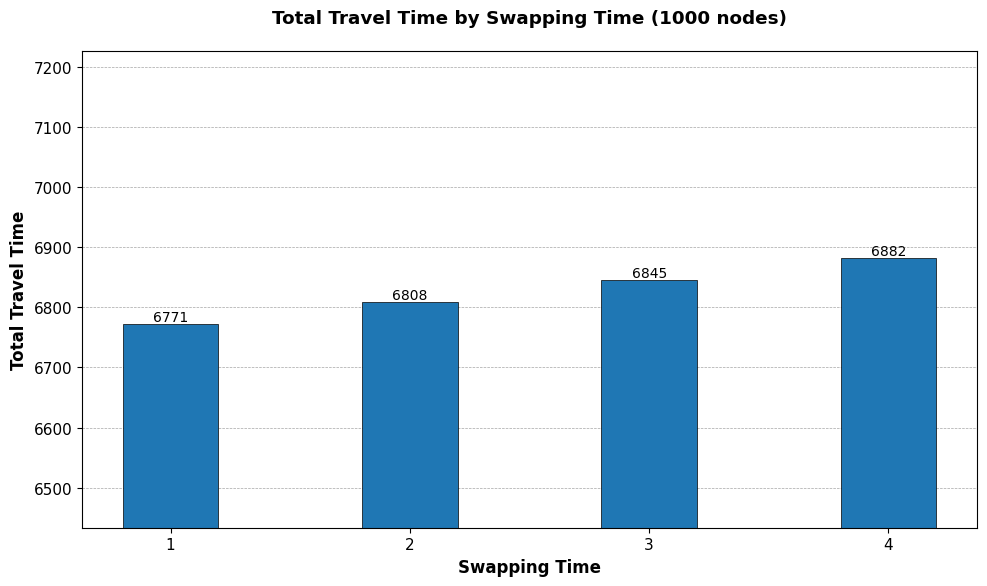

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Swapping Time (1000 nodes)'}, xlabel='Swapping Time', ylabel='Total Travel Time'>)

In [76]:
create_simple_bar_chart(
    df_1000_swap,
    'Swapping Time',
    'Total Travel Time',
    title='Total Travel Time by Swapping Time (1000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


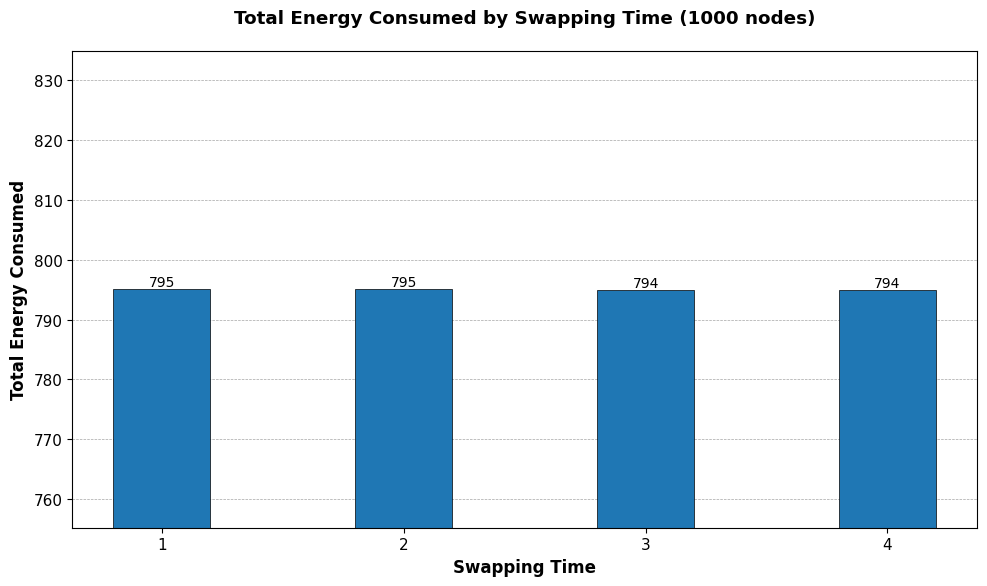

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Swapping Time (1000 nodes)'}, xlabel='Swapping Time', ylabel='Total Energy Consumed'>)

In [77]:
create_simple_bar_chart(
    df_1000_swap,
    'Swapping Time',
    'Total Energy Consumed',
    title='Total Energy Consumed by Swapping Time (1000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


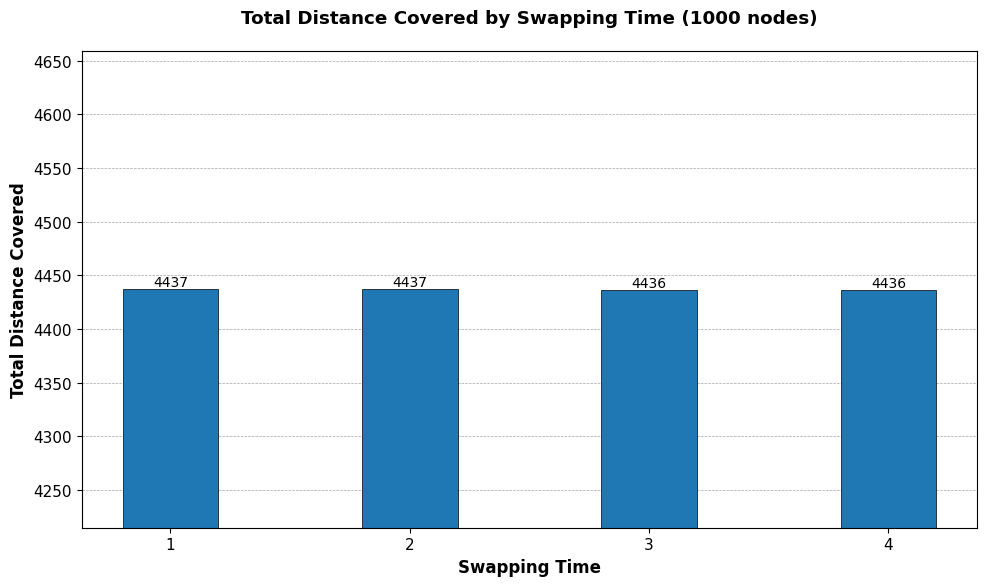

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Swapping Time (1000 nodes)'}, xlabel='Swapping Time', ylabel='Total Distance Covered'>)

In [78]:
create_simple_bar_chart(
    df_1000_swap,
    'Swapping Time',
    'Total Distance Covered',
    title='Total Distance Covered by Swapping Time (1000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


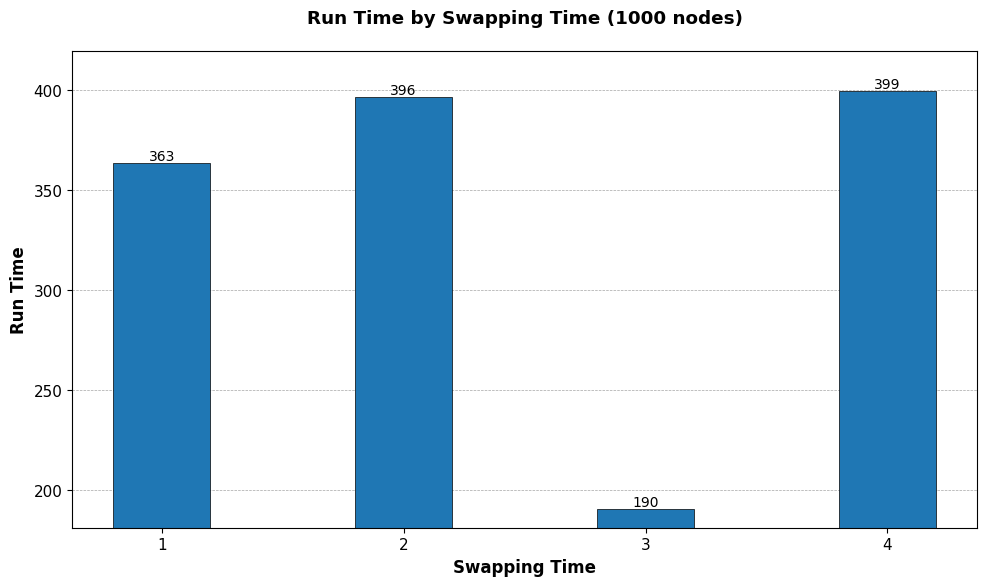

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Swapping Time (1000 nodes)'}, xlabel='Swapping Time', ylabel='Run Time'>)

In [79]:
create_simple_bar_chart(
    df_1000_swap,
    'Swapping Time',
    'Run Time',
    title='Run Time by Swapping Time (1000 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


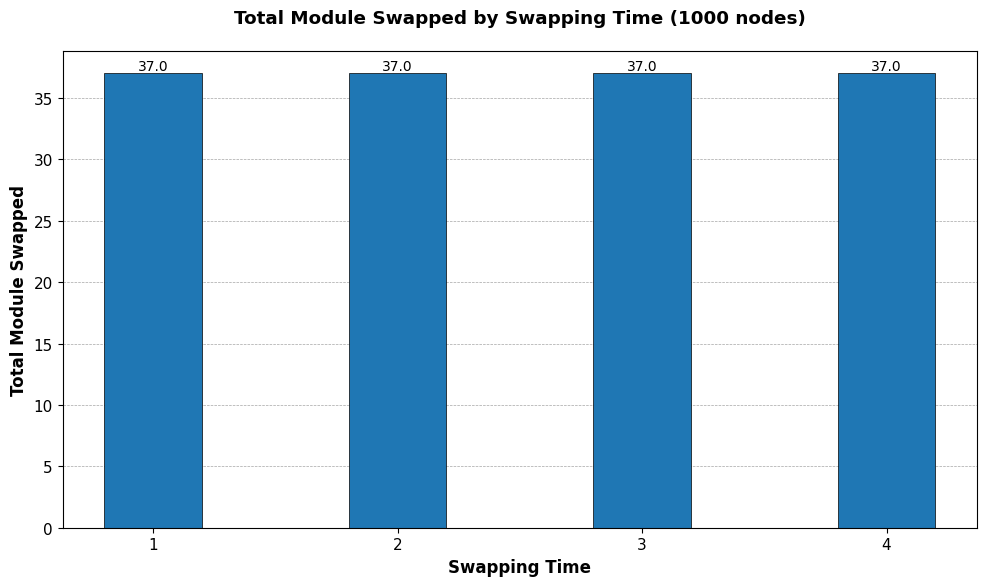

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Swapping Time (1000 nodes)'}, xlabel='Swapping Time', ylabel='Total Module Swapped'>)

In [80]:
create_simple_bar_chart(
    df_1000_swap,
    'Swapping Time',
    'Total Module Swapped',
    title='Total Module Swapped by Swapping Time (1000 nodes)',
    ylabel='Total Module Swapped'
)


# 1000 nodes Threshold


In [81]:
# Load 1000 nodes Threshold data
df_1000_threshold = load_heuristic_data(1000, 'ThresholdChange')
print("1000 nodes Threshold Data:")
print(df_1000_threshold)


1000 nodes Threshold Data:
   Threshold  Total Travel Time  Total Energy Consumed  \
0          5             6808.9                795.158   
1         10             6808.9                795.158   
2         15             6808.9                795.158   
3         20             6808.9                795.158   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 4437.52   287.889                    37  
1                 4437.52   338.988                    37  
2                 4437.52   225.322                    37  
3                 4437.52   396.099                    37  


## (a) Travel Time bar chart


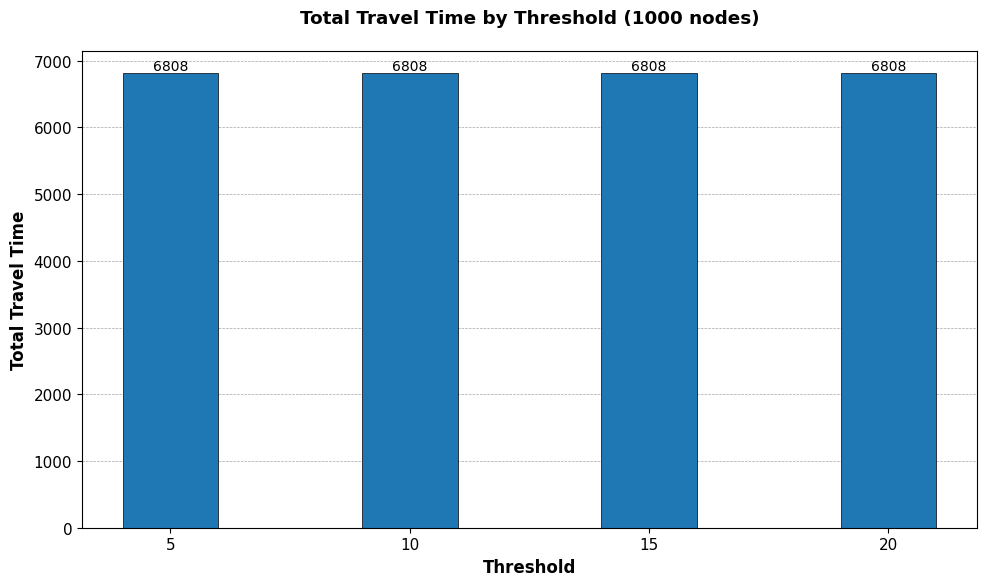

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Threshold (1000 nodes)'}, xlabel='Threshold', ylabel='Total Travel Time'>)

In [82]:
create_simple_bar_chart(
    df_1000_threshold,
    'Threshold',
    'Total Travel Time',
    title='Total Travel Time by Threshold (1000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


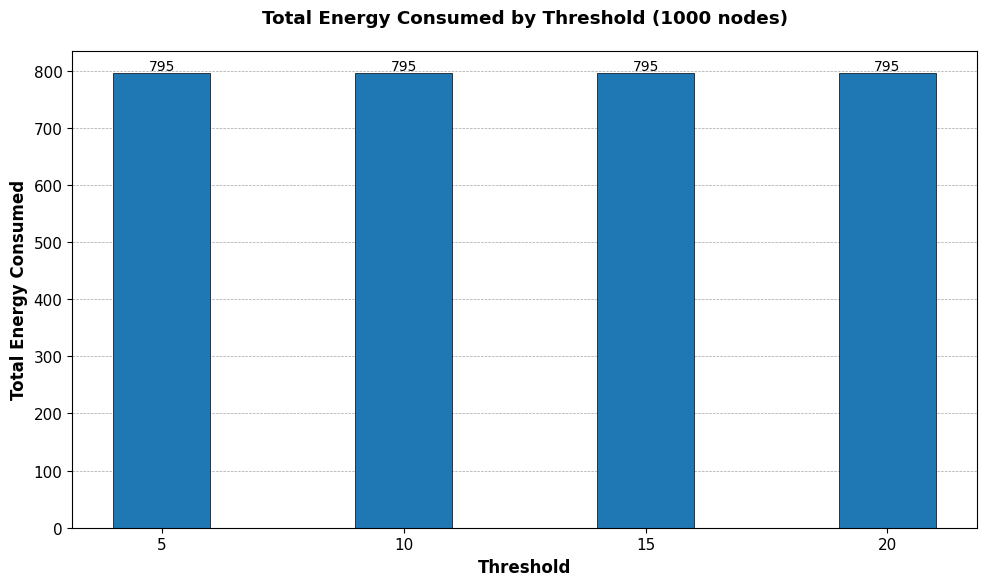

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Threshold (1000 nodes)'}, xlabel='Threshold', ylabel='Total Energy Consumed'>)

In [83]:
create_simple_bar_chart(
    df_1000_threshold,
    'Threshold',
    'Total Energy Consumed',
    title='Total Energy Consumed by Threshold (1000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


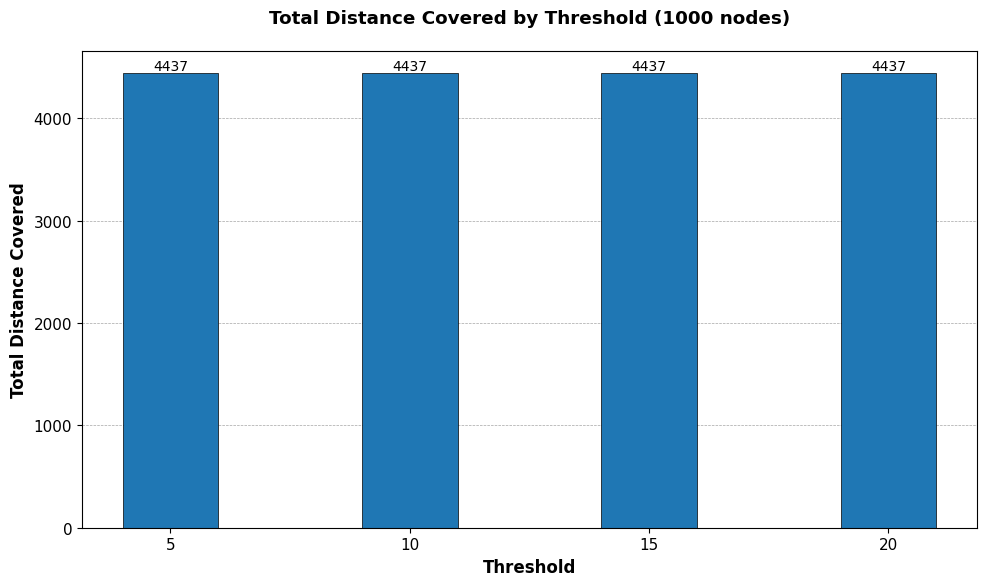

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Threshold (1000 nodes)'}, xlabel='Threshold', ylabel='Total Distance Covered'>)

In [84]:
create_simple_bar_chart(
    df_1000_threshold,
    'Threshold',
    'Total Distance Covered',
    title='Total Distance Covered by Threshold (1000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


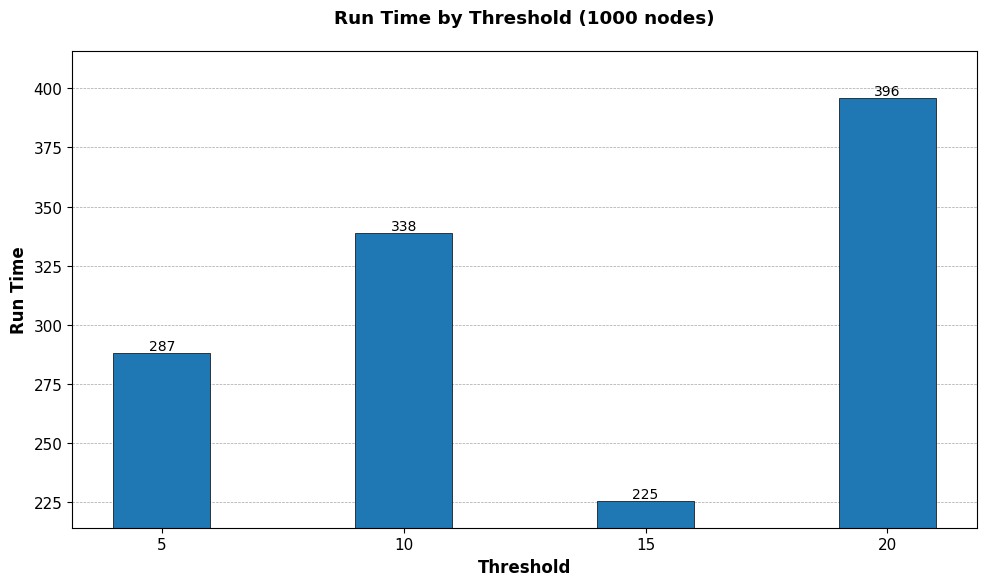

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Threshold (1000 nodes)'}, xlabel='Threshold', ylabel='Run Time'>)

In [85]:
create_simple_bar_chart(
    df_1000_threshold,
    'Threshold',
    'Run Time',
    title='Run Time by Threshold (1000 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


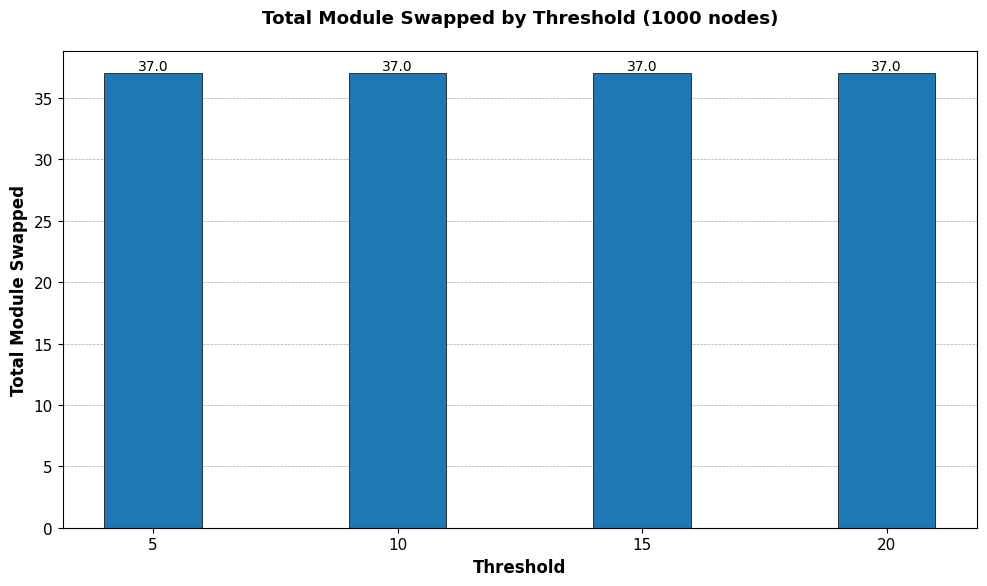

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Threshold (1000 nodes)'}, xlabel='Threshold', ylabel='Total Module Swapped'>)

In [86]:
create_simple_bar_chart(
    df_1000_threshold,
    'Threshold',
    'Total Module Swapped',
    title='Total Module Swapped by Threshold (1000 nodes)',
    ylabel='Total Module Swapped'
)


# 1000 nodes Traffic


In [87]:
# Load 1000 nodes Traffic data
df_1000_traffic = load_heuristic_data(1000, 'TrafficChange')
print("1000 nodes Traffic Data:")
print(df_1000_traffic)


1000 nodes Traffic Data:
  Traffic  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0    High            8004.34                757.044                 4374.17   
1     Mid            7032.58                805.335                 4619.51   
2     Low            6269.66                883.104                 4806.46   

   Run Time  Total Module Swapped  
0   368.030                    35  
1   407.246                    38  
2   382.141                    41  


## (a) Travel Time bar chart


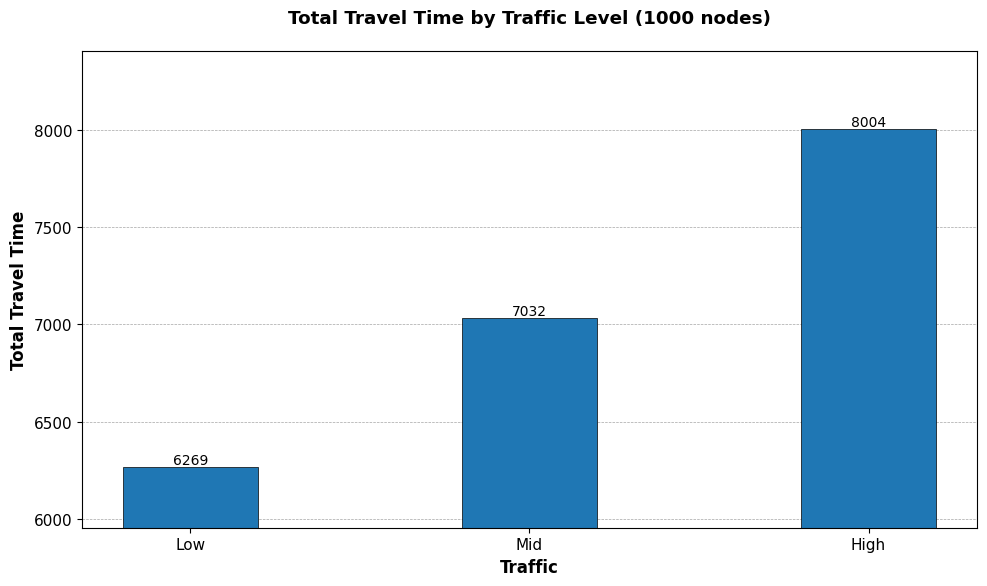

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Traffic Level (1000 nodes)'}, xlabel='Traffic', ylabel='Total Travel Time'>)

In [88]:
create_simple_bar_chart(
    df_1000_traffic,
    'Traffic',
    'Total Travel Time',
    title='Total Travel Time by Traffic Level (1000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumption bar chart


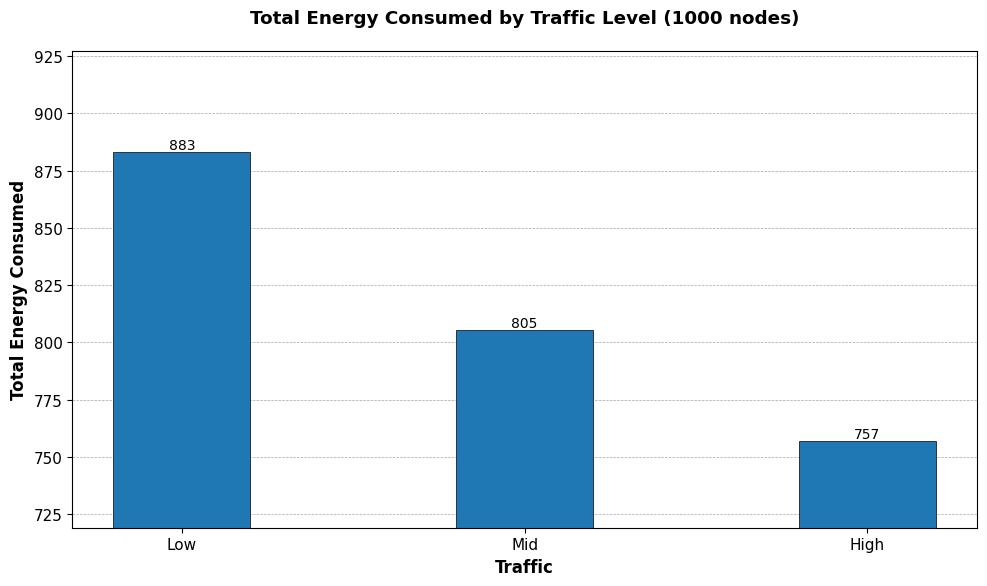

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Traffic Level (1000 nodes)'}, xlabel='Traffic', ylabel='Total Energy Consumed'>)

In [89]:
create_simple_bar_chart(
    df_1000_traffic,
    'Traffic',
    'Total Energy Consumed',
    title='Total Energy Consumed by Traffic Level (1000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


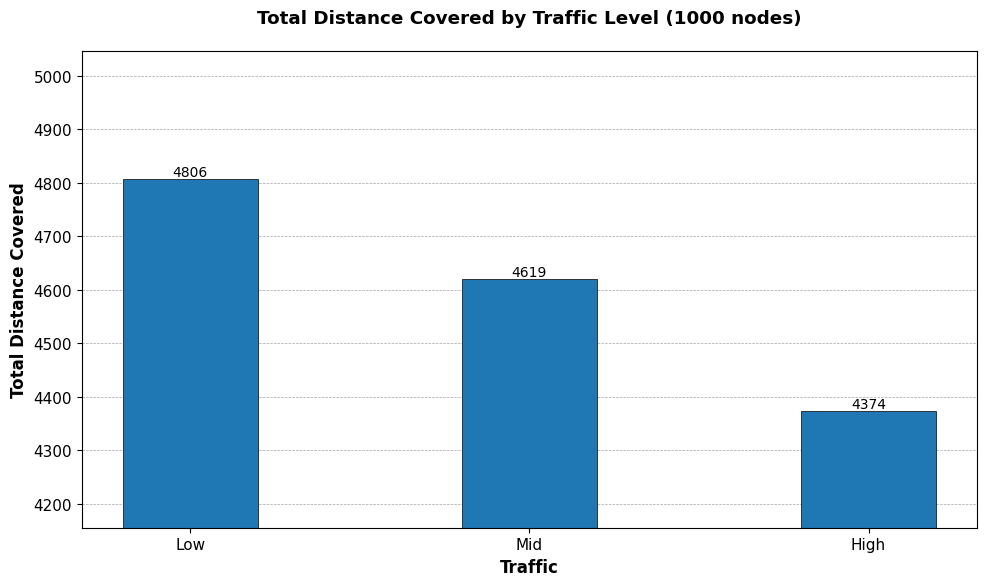

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Traffic Level (1000 nodes)'}, xlabel='Traffic', ylabel='Total Distance Covered'>)

In [90]:
create_simple_bar_chart(
    df_1000_traffic,
    'Traffic',
    'Total Distance Covered',
    title='Total Distance Covered by Traffic Level (1000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Runtime bar chart


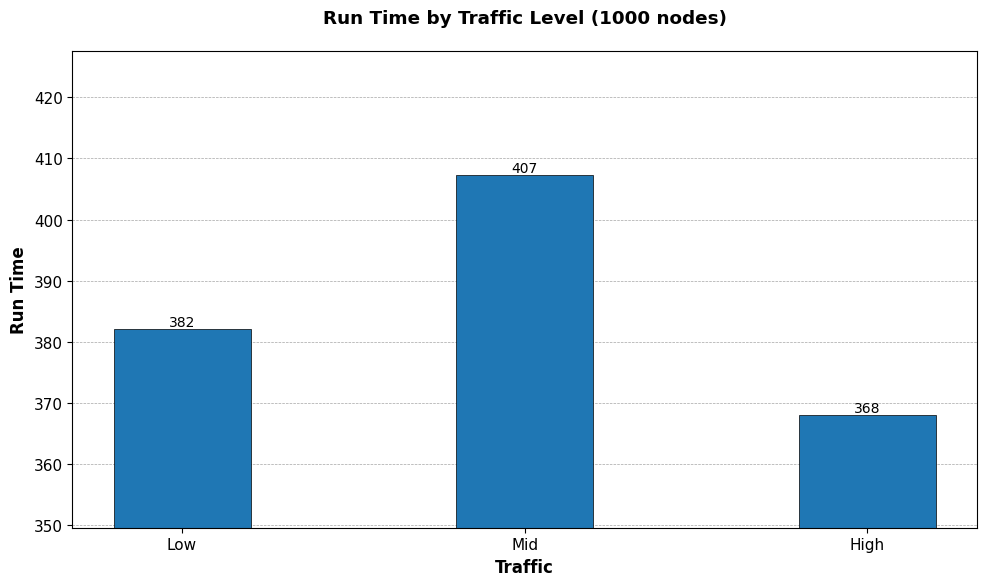

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Traffic Level (1000 nodes)'}, xlabel='Traffic', ylabel='Run Time'>)

In [91]:
create_simple_bar_chart(
    df_1000_traffic,
    'Traffic',
    'Run Time',
    title='Run Time by Traffic Level (1000 nodes)',
    ylabel='Run Time'
)


## (e) Number of module swapped bar chart


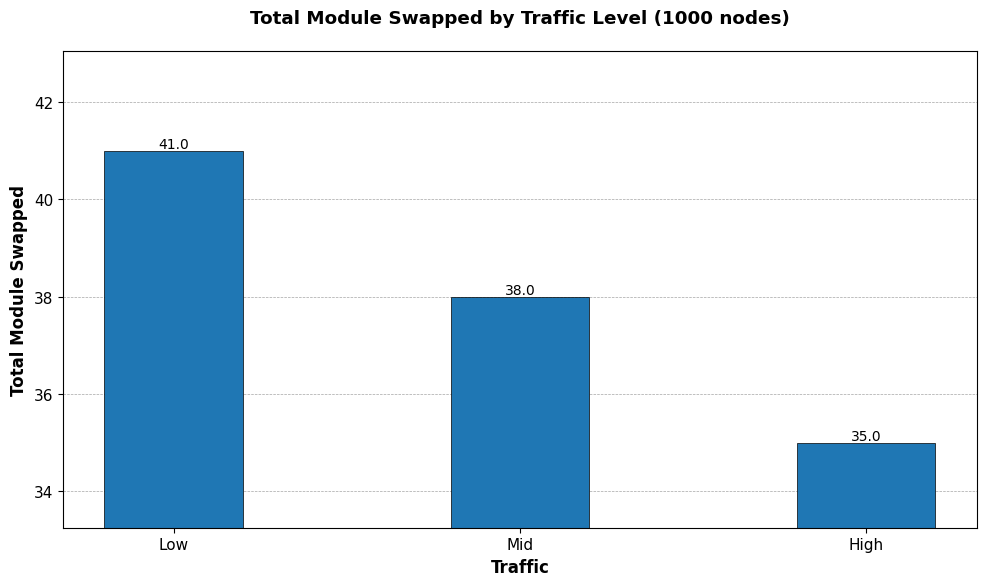

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Traffic Level (1000 nodes)'}, xlabel='Traffic', ylabel='Total Module Swapped'>)

In [92]:
create_simple_bar_chart(
    df_1000_traffic,
    'Traffic',
    'Total Module Swapped',
    title='Total Module Swapped by Traffic Level (1000 nodes)',
    ylabel='Total Module Swapped'
)


# 1500 nodes Module Change


In [93]:
# Load 1500 nodes Module Change data
df_1500_module = load_heuristic_data(1500, 'ModuleChange')
print("1500 nodes Module Change Data:")
print(df_1500_module)


1500 nodes Module Change Data:
   Modules  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0        4           10275.22               1351.125                 6628.04   
1        5           10133.53               1346.576                 6533.82   
2        6           10148.53               1347.934                 6545.22   
3        7           10148.53               1347.934                 6545.22   

   Run Time  Total Module Swapped  
0   474.606                    65  
1   660.925                    64  
2   608.308                    63  
3  1238.304                    63  


## (a) Travel time bar chart


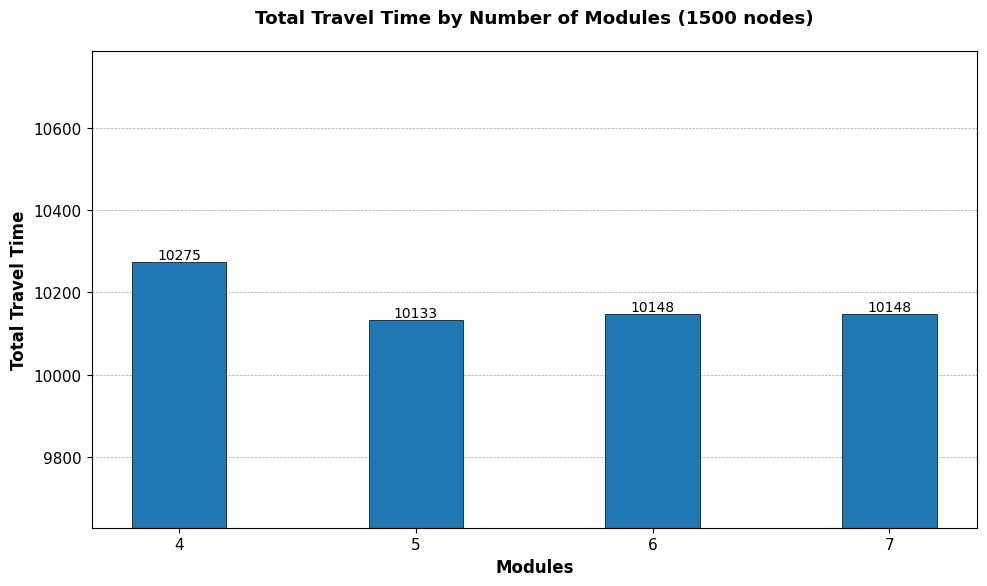

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Modules (1500 nodes)'}, xlabel='Modules', ylabel='Total Travel Time'>)

In [94]:
create_simple_bar_chart(
    df_1500_module,
    'Modules',
    'Total Travel Time',
    title='Total Travel Time by Number of Modules (1500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


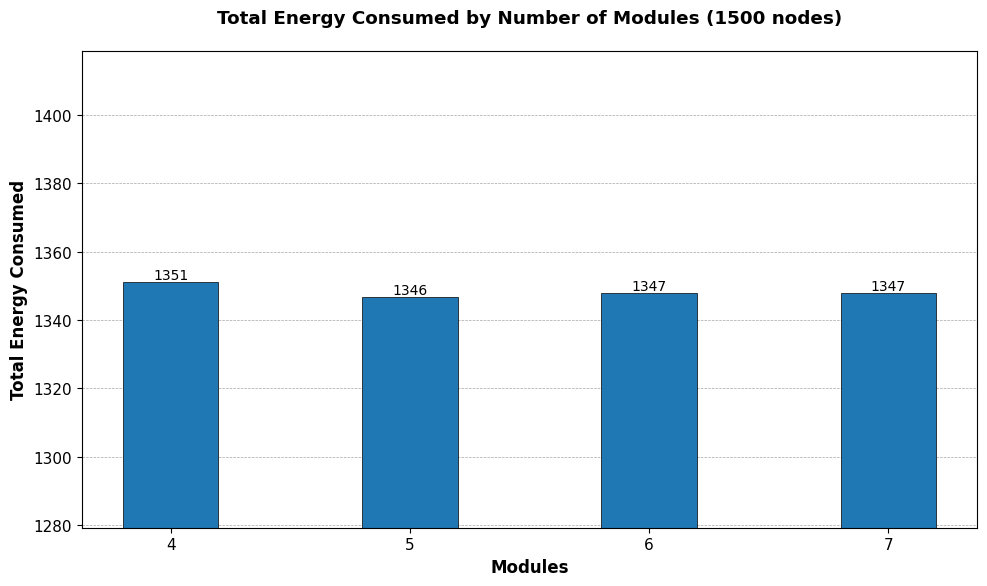

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Modules (1500 nodes)'}, xlabel='Modules', ylabel='Total Energy Consumed'>)

In [95]:
create_simple_bar_chart(
    df_1500_module,
    'Modules',
    'Total Energy Consumed',
    title='Total Energy Consumed by Number of Modules (1500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


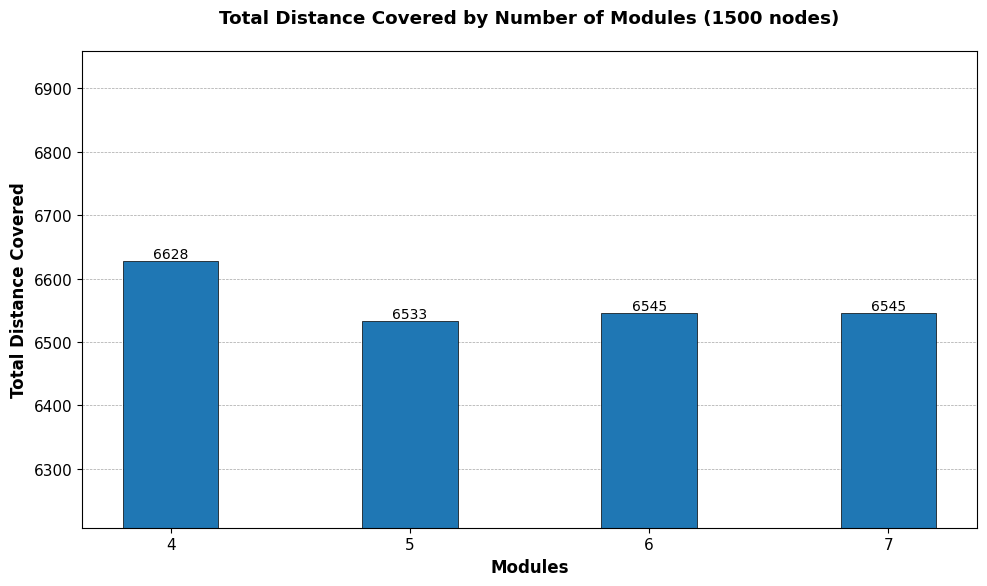

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Modules (1500 nodes)'}, xlabel='Modules', ylabel='Total Distance Covered'>)

In [96]:
create_simple_bar_chart(
    df_1500_module,
    'Modules',
    'Total Distance Covered',
    title='Total Distance Covered by Number of Modules (1500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


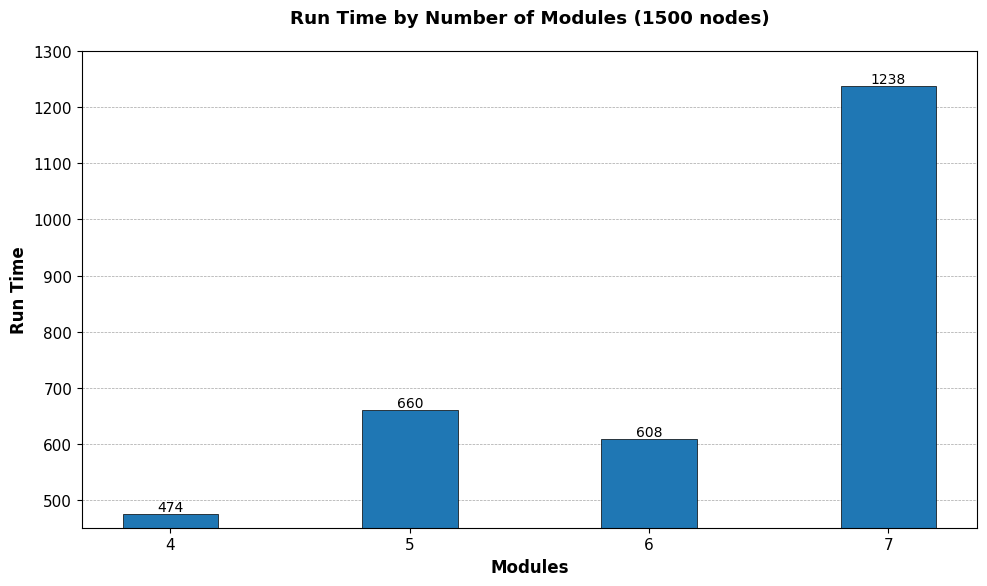

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Modules (1500 nodes)'}, xlabel='Modules', ylabel='Run Time'>)

In [97]:
create_simple_bar_chart(
    df_1500_module,
    'Modules',
    'Run Time',
    title='Run Time by Number of Modules (1500 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


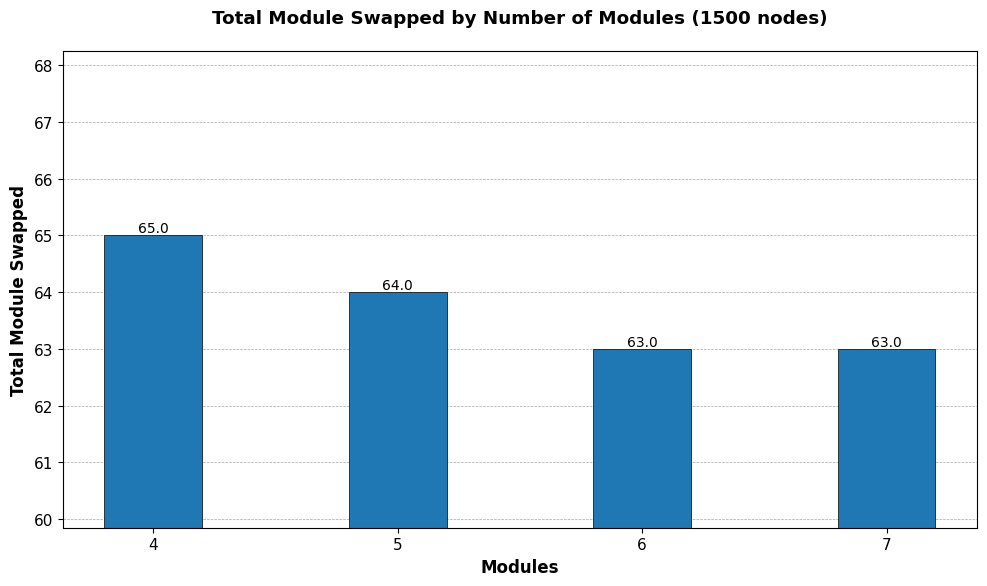

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Modules (1500 nodes)'}, xlabel='Modules', ylabel='Total Module Swapped'>)

In [98]:
create_simple_bar_chart(
    df_1500_module,
    'Modules',
    'Total Module Swapped',
    title='Total Module Swapped by Number of Modules (1500 nodes)',
    ylabel='Total Module Swapped'
)


# 1500 nodes Swapping Time


In [99]:
# Load 1500 nodes Swapping Time data
df_1500_swappingtime = load_heuristic_data(1500, 'SwappingTimeChange')
# Handle '1min', '2min' format - extract numeric part (only if string type)
if 'Swapping Time' in df_1500_swappingtime.columns:
    if df_1500_swappingtime['Swapping Time'].dtype == 'object':
        df_1500_swappingtime['Swapping Time'] = df_1500_swappingtime['Swapping Time'].str.replace('min', '').astype(int)
    else:
        # Already numeric, just ensure it's int
        df_1500_swappingtime['Swapping Time'] = df_1500_swappingtime['Swapping Time'].astype(int)
print("1500 nodes Swapping Time Data:")
print(df_1500_swappingtime)


1500 nodes Swapping Time Data:
   Swapping Time  Total Travel Time  Total Energy Consumed  \
0              1           10089.02               1349.758   
1              2           10133.53               1346.576   
2              3           10197.53               1346.576   
3              4           10262.19               1346.594   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 6552.92   651.441                    64  
1                 6533.82   660.925                    64  
2                 6533.82   655.111                    64  
3                 6534.02   627.857                    64  


## (a) Travel time bar chart


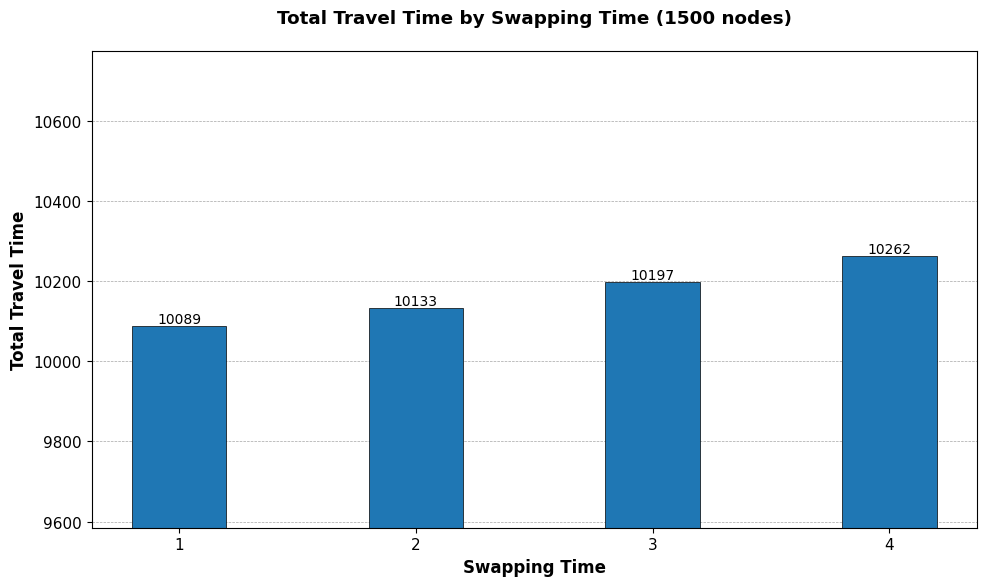

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Swapping Time (1500 nodes)'}, xlabel='Swapping Time', ylabel='Total Travel Time'>)

In [100]:
create_simple_bar_chart(
    df_1500_swappingtime,
    'Swapping Time',
    'Total Travel Time',
    title='Total Travel Time by Swapping Time (1500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


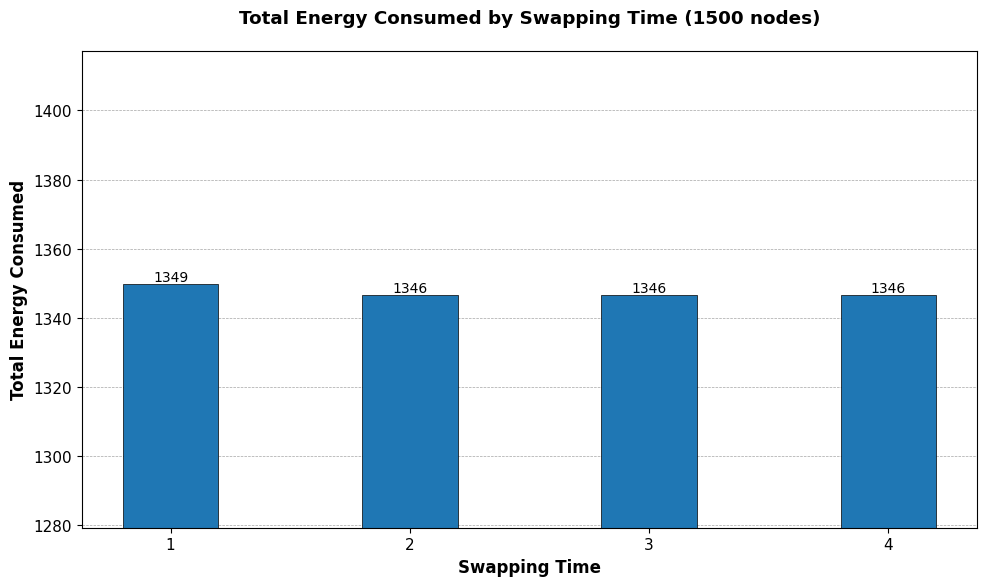

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Swapping Time (1500 nodes)'}, xlabel='Swapping Time', ylabel='Total Energy Consumed'>)

In [101]:
create_simple_bar_chart(
    df_1500_swappingtime,
    'Swapping Time',
    'Total Energy Consumed',
    title='Total Energy Consumed by Swapping Time (1500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


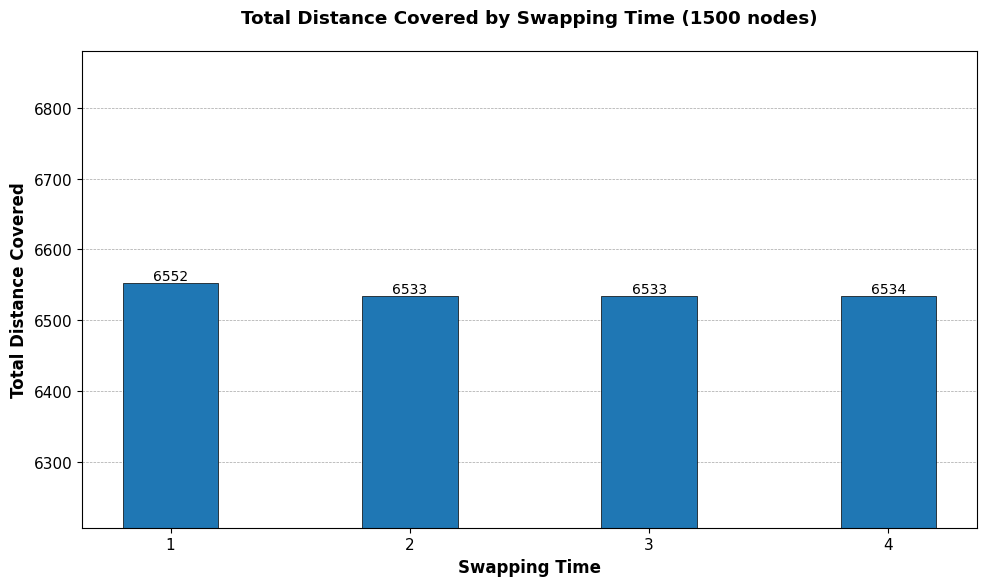

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Swapping Time (1500 nodes)'}, xlabel='Swapping Time', ylabel='Total Distance Covered'>)

In [102]:
create_simple_bar_chart(
    df_1500_swappingtime,
    'Swapping Time',
    'Total Distance Covered',
    title='Total Distance Covered by Swapping Time (1500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


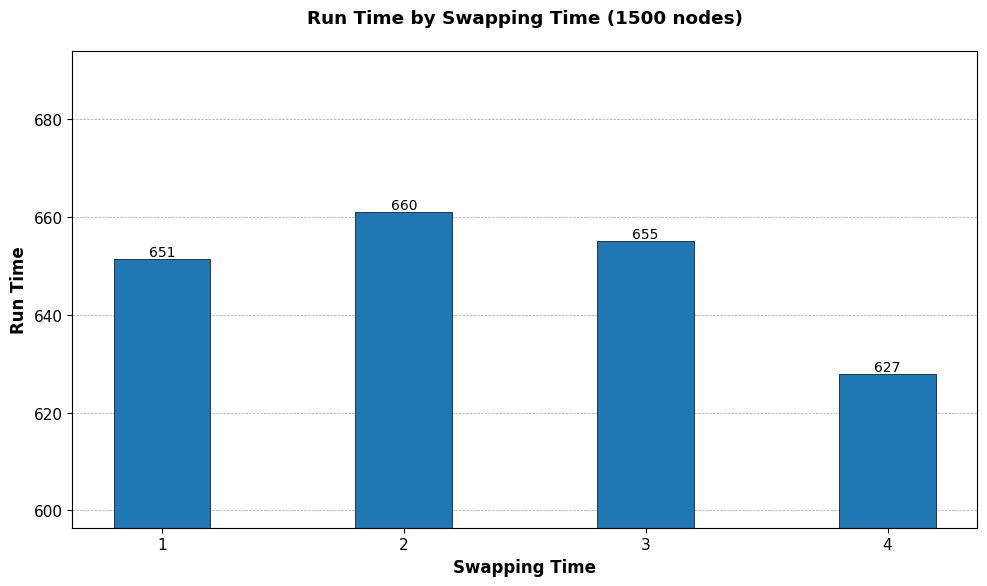

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Swapping Time (1500 nodes)'}, xlabel='Swapping Time', ylabel='Run Time'>)

In [103]:
create_simple_bar_chart(
    df_1500_swappingtime,
    'Swapping Time',
    'Run Time',
    title='Run Time by Swapping Time (1500 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


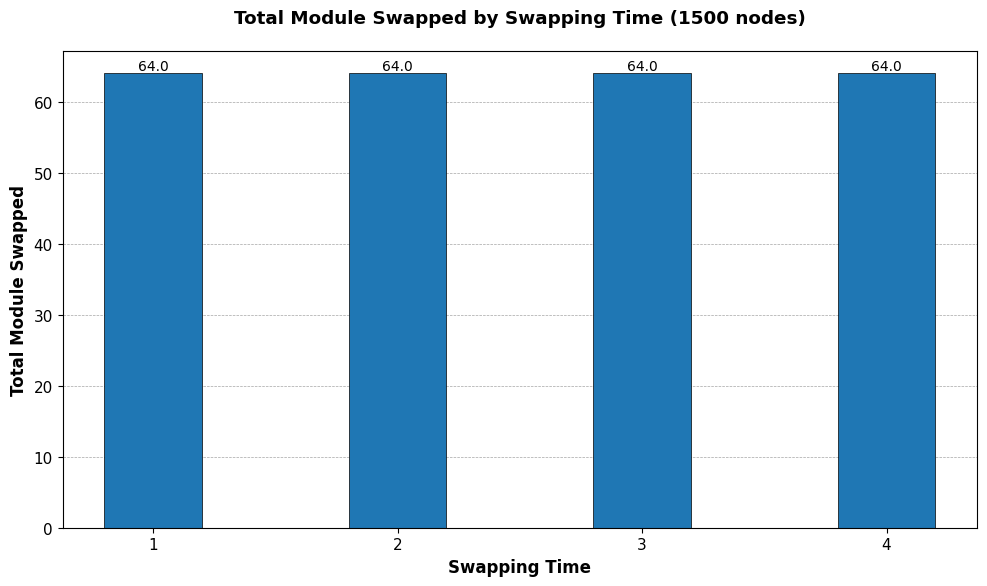

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Swapping Time (1500 nodes)'}, xlabel='Swapping Time', ylabel='Total Module Swapped'>)

In [104]:
create_simple_bar_chart(
    df_1500_swappingtime,
    'Swapping Time',
    'Total Module Swapped',
    title='Total Module Swapped by Swapping Time (1500 nodes)',
    ylabel='Total Module Swapped'
)


# 1500 nodes Threshold


In [105]:
# Load 1500 nodes Threshold data
df_1500_threshold = load_heuristic_data(1500, 'ThresholdChange')
print("1500 nodes Threshold Data:")
print(df_1500_threshold)


1500 nodes Threshold Data:
   Threshold  Total Travel Time  Total Energy Consumed  \
0          5           10148.53               1347.934   
1         10           10133.53               1346.576   
2         15           10133.53               1346.576   
3         20           10133.53               1346.576   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 6545.22   559.511                    63  
1                 6533.82   568.130                    64  
2                 6533.82   565.352                    64  
3                 6533.82   660.925                    64  


## (a) Travel time bar chart


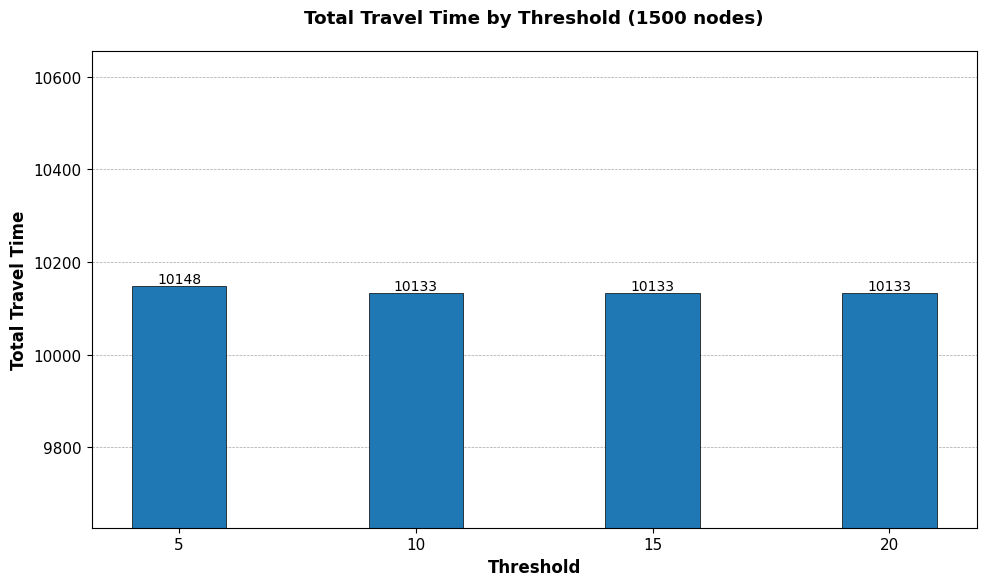

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Threshold (1500 nodes)'}, xlabel='Threshold', ylabel='Total Travel Time'>)

In [106]:
create_simple_bar_chart(
    df_1500_threshold,
    'Threshold',
    'Total Travel Time',
    title='Total Travel Time by Threshold (1500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


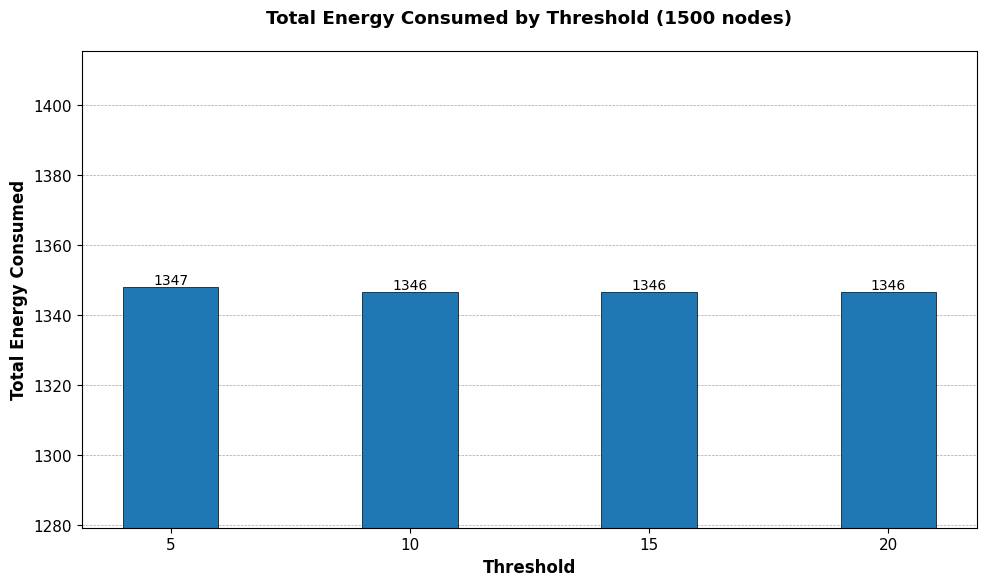

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Threshold (1500 nodes)'}, xlabel='Threshold', ylabel='Total Energy Consumed'>)

In [107]:
create_simple_bar_chart(
    df_1500_threshold,
    'Threshold',
    'Total Energy Consumed',
    title='Total Energy Consumed by Threshold (1500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


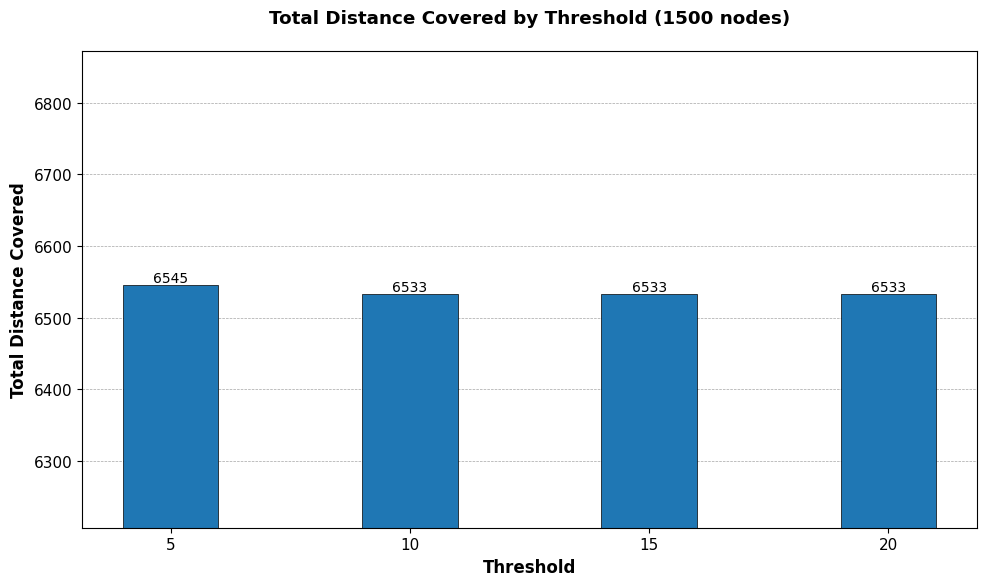

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Threshold (1500 nodes)'}, xlabel='Threshold', ylabel='Total Distance Covered'>)

In [108]:
create_simple_bar_chart(
    df_1500_threshold,
    'Threshold',
    'Total Distance Covered',
    title='Total Distance Covered by Threshold (1500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


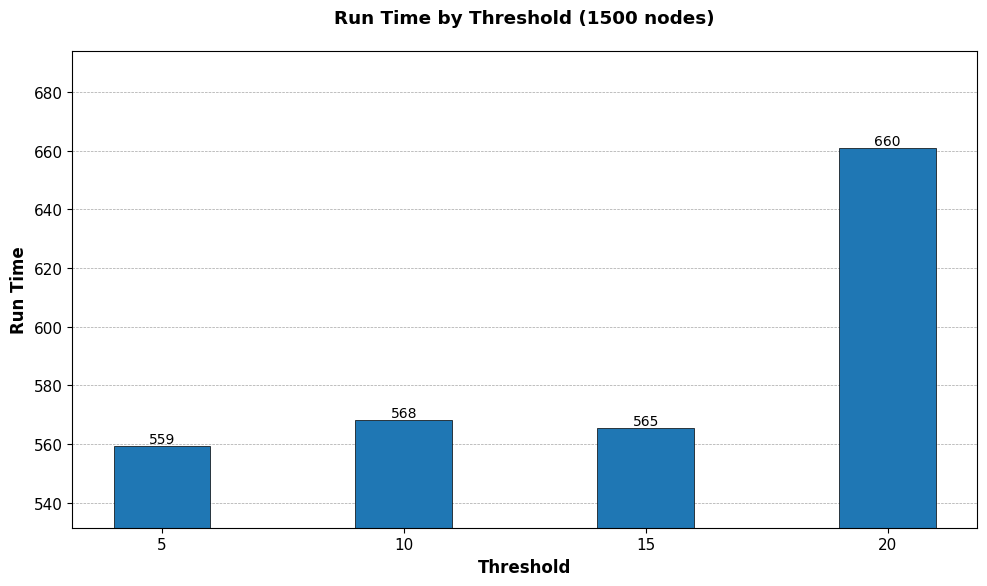

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Threshold (1500 nodes)'}, xlabel='Threshold', ylabel='Run Time'>)

In [109]:
create_simple_bar_chart(
    df_1500_threshold,
    'Threshold',
    'Run Time',
    title='Run Time by Threshold (1500 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


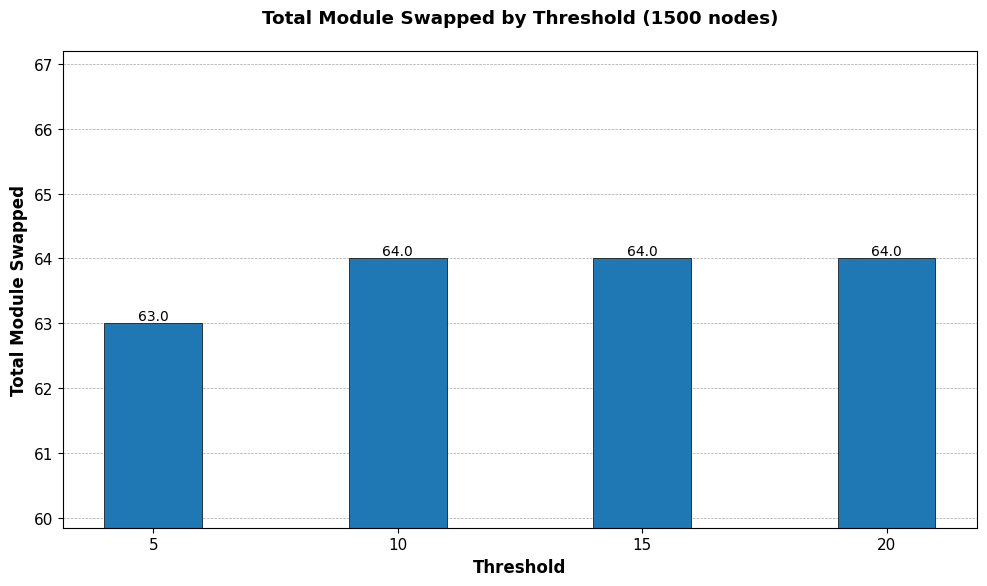

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Threshold (1500 nodes)'}, xlabel='Threshold', ylabel='Total Module Swapped'>)

In [110]:
create_simple_bar_chart(
    df_1500_threshold,
    'Threshold',
    'Total Module Swapped',
    title='Total Module Swapped by Threshold (1500 nodes)',
    ylabel='Total Module Swapped'
)


# 1500 nodes Traffic


In [111]:
# Load 1500 nodes Traffic data
df_1500_traffic = load_heuristic_data(1500, 'TrafficChange')
print("1500 nodes Traffic Data:")
print(df_1500_traffic)


1500 nodes Traffic Data:
  Traffic  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0    High           11868.31               1303.585                 6493.82   
1     Mid            9841.03               1337.106                 6463.22   
2     Low            8682.70               1443.984                 6661.07   

   Run Time  Total Module Swapped  
0  1584.591                    63  
1  1272.888                    65  
2  1445.247                    69  


## (a) Travel time bar chart


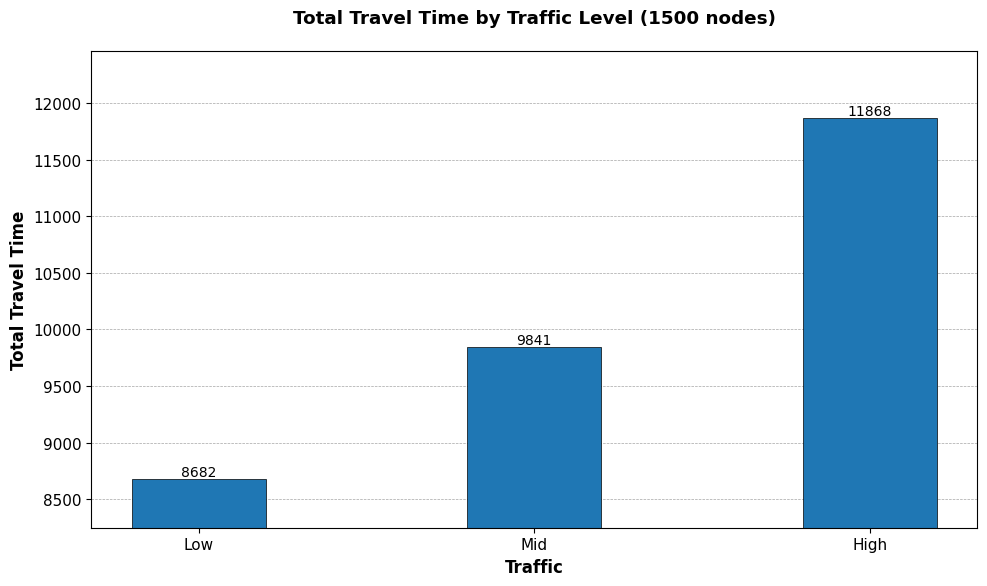

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Traffic Level (1500 nodes)'}, xlabel='Traffic', ylabel='Total Travel Time'>)

In [112]:
create_simple_bar_chart(
    df_1500_traffic,
    'Traffic',
    'Total Travel Time',
    title='Total Travel Time by Traffic Level (1500 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


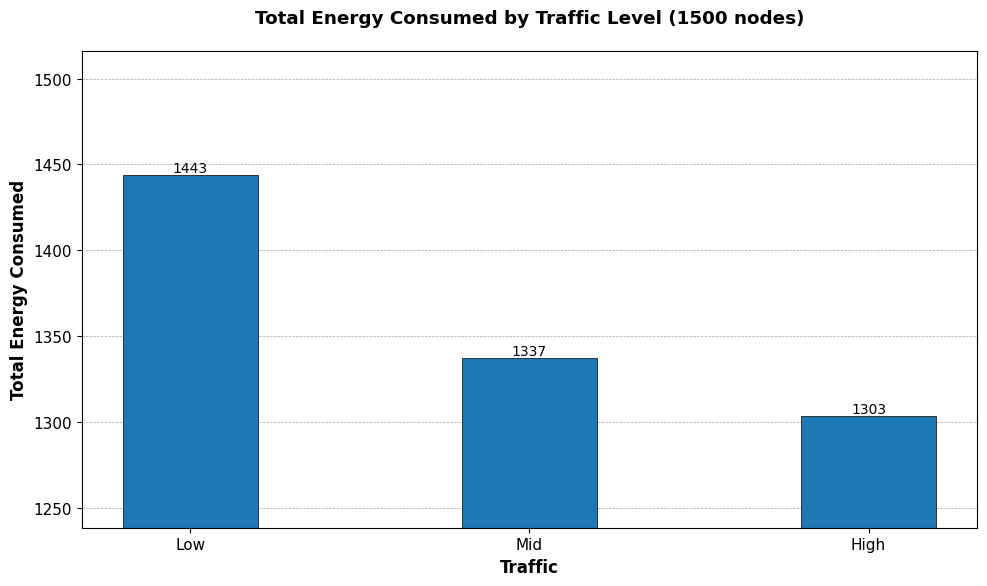

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Traffic Level (1500 nodes)'}, xlabel='Traffic', ylabel='Total Energy Consumed'>)

In [113]:
create_simple_bar_chart(
    df_1500_traffic,
    'Traffic',
    'Total Energy Consumed',
    title='Total Energy Consumed by Traffic Level (1500 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


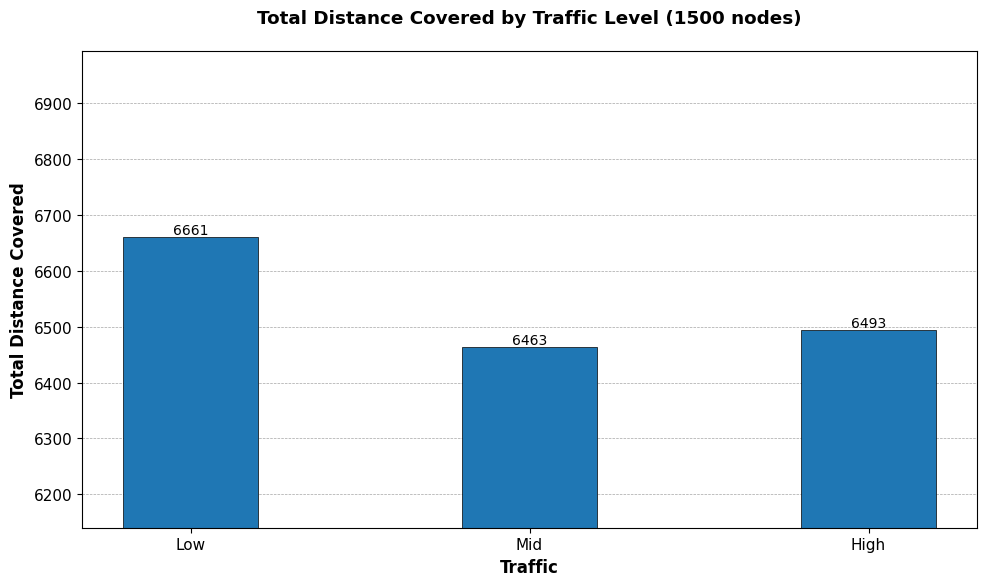

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Traffic Level (1500 nodes)'}, xlabel='Traffic', ylabel='Total Distance Covered'>)

In [114]:
create_simple_bar_chart(
    df_1500_traffic,
    'Traffic',
    'Total Distance Covered',
    title='Total Distance Covered by Traffic Level (1500 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


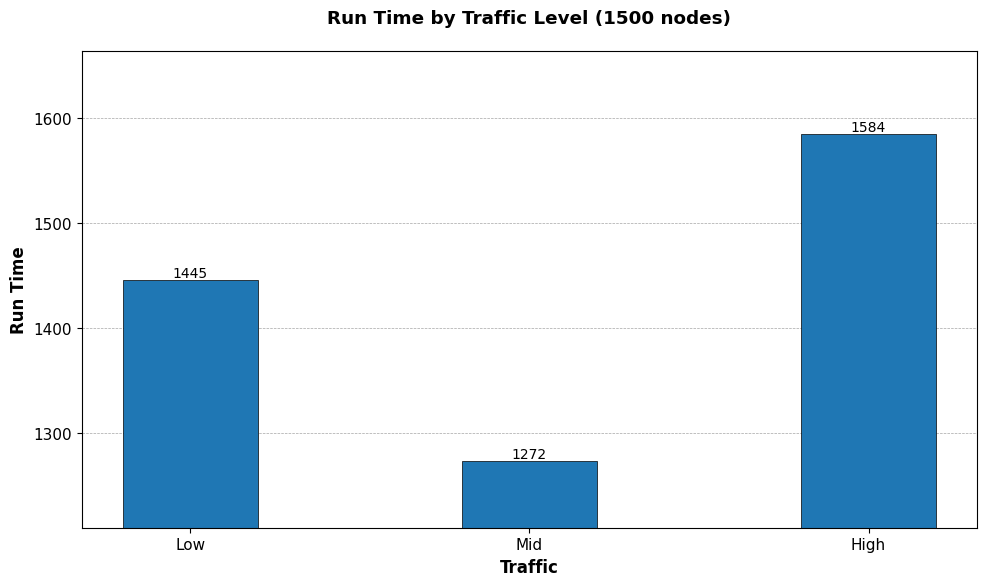

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Traffic Level (1500 nodes)'}, xlabel='Traffic', ylabel='Run Time'>)

In [115]:
create_simple_bar_chart(
    df_1500_traffic,
    'Traffic',
    'Run Time',
    title='Run Time by Traffic Level (1500 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


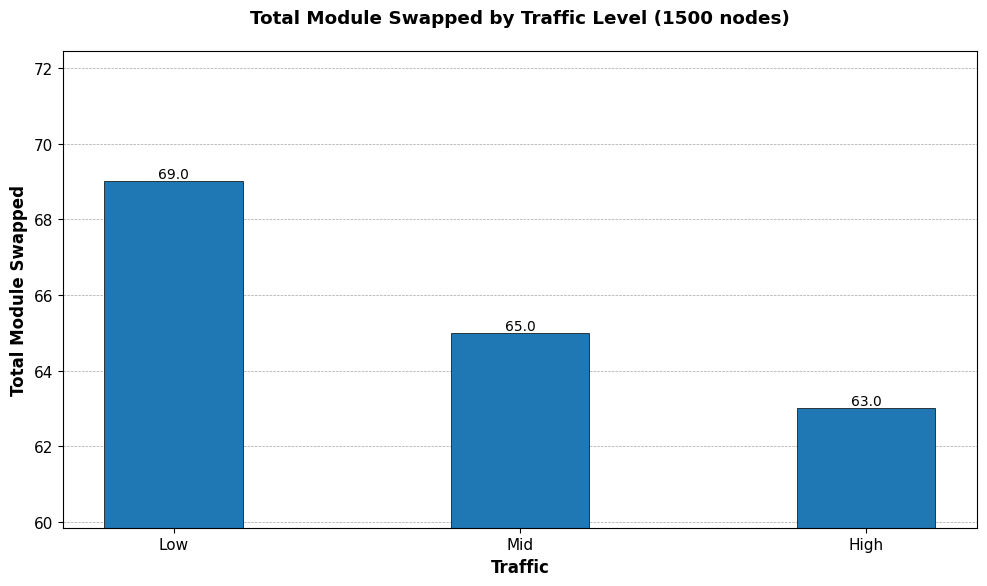

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Traffic Level (1500 nodes)'}, xlabel='Traffic', ylabel='Total Module Swapped'>)

In [116]:
create_simple_bar_chart(
    df_1500_traffic,
    'Traffic',
    'Total Module Swapped',
    title='Total Module Swapped by Traffic Level (1500 nodes)',
    ylabel='Total Module Swapped'
)


# 2000 nodes Module Change


In [117]:
# Load 2000 nodes Module Change data
df_2000_module = load_heuristic_data(2000, 'ModuleChange')
print("2000 nodes Module Change Data:")
print(df_2000_module)


2000 nodes Module Change Data:
   Modules  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0        4           14159.32               2154.006                 9234.69   
1        5           13381.98               2057.455                 8652.17   
2        6           13525.31               2066.418                 8826.26   
3        7           13169.12               2030.721                 8588.97   

   Run Time  Total Module Swapped  
0  1545.515                   106  
1  1236.336                   100  
2  1371.109                    99  
3  1477.456                    97  


## (a) Travel time bar chart


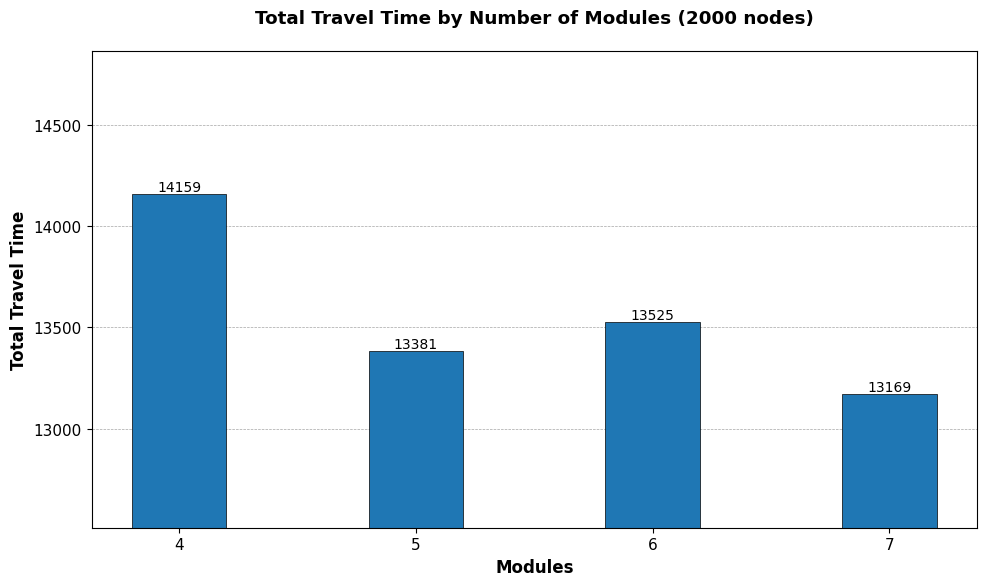

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Modules (2000 nodes)'}, xlabel='Modules', ylabel='Total Travel Time'>)

In [118]:
create_simple_bar_chart(
    df_2000_module,
    'Modules',
    'Total Travel Time',
    title='Total Travel Time by Number of Modules (2000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


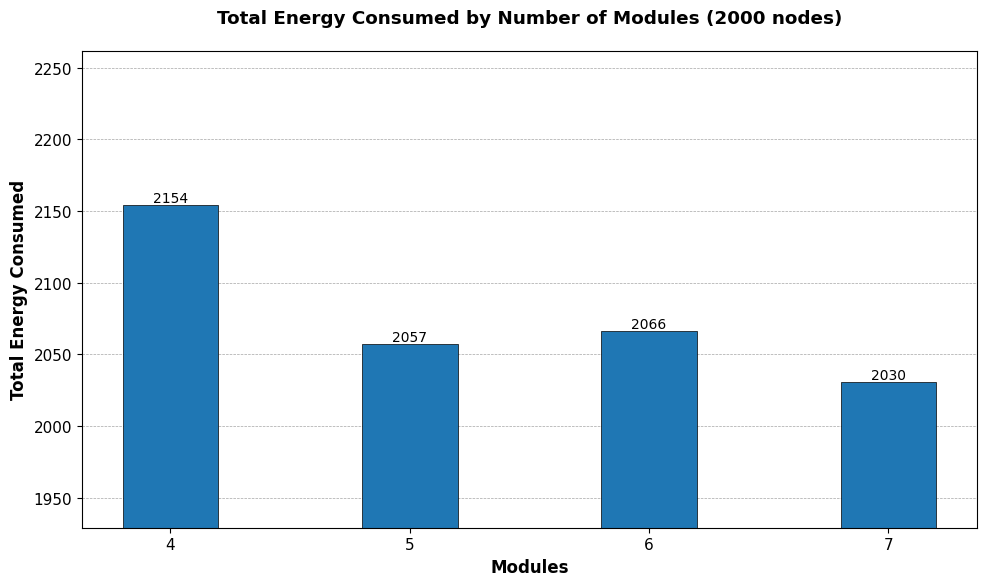

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Modules (2000 nodes)'}, xlabel='Modules', ylabel='Total Energy Consumed'>)

In [119]:
create_simple_bar_chart(
    df_2000_module,
    'Modules',
    'Total Energy Consumed',
    title='Total Energy Consumed by Number of Modules (2000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


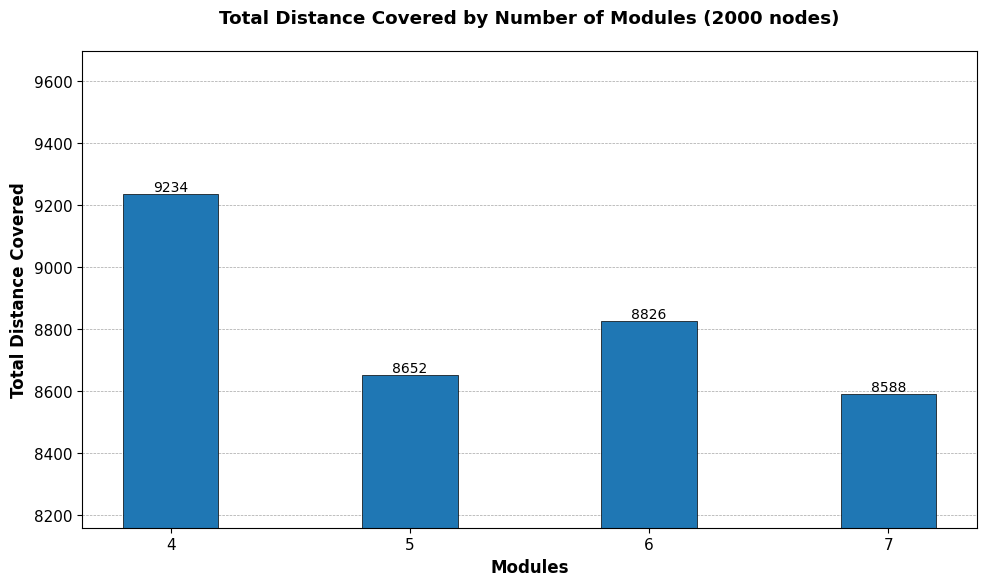

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Modules (2000 nodes)'}, xlabel='Modules', ylabel='Total Distance Covered'>)

In [120]:
create_simple_bar_chart(
    df_2000_module,
    'Modules',
    'Total Distance Covered',
    title='Total Distance Covered by Number of Modules (2000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


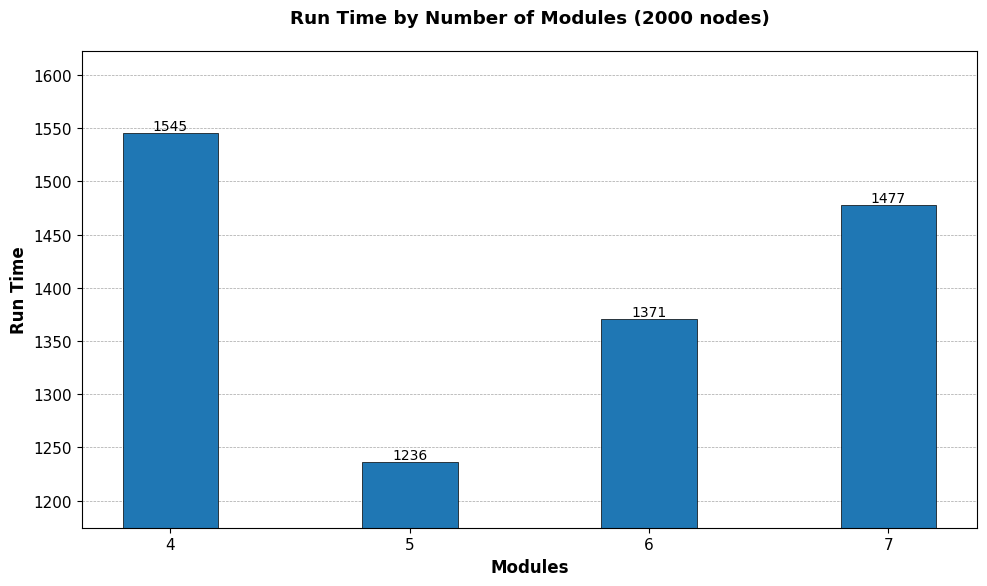

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Modules (2000 nodes)'}, xlabel='Modules', ylabel='Run Time'>)

In [121]:
create_simple_bar_chart(
    df_2000_module,
    'Modules',
    'Run Time',
    title='Run Time by Number of Modules (2000 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


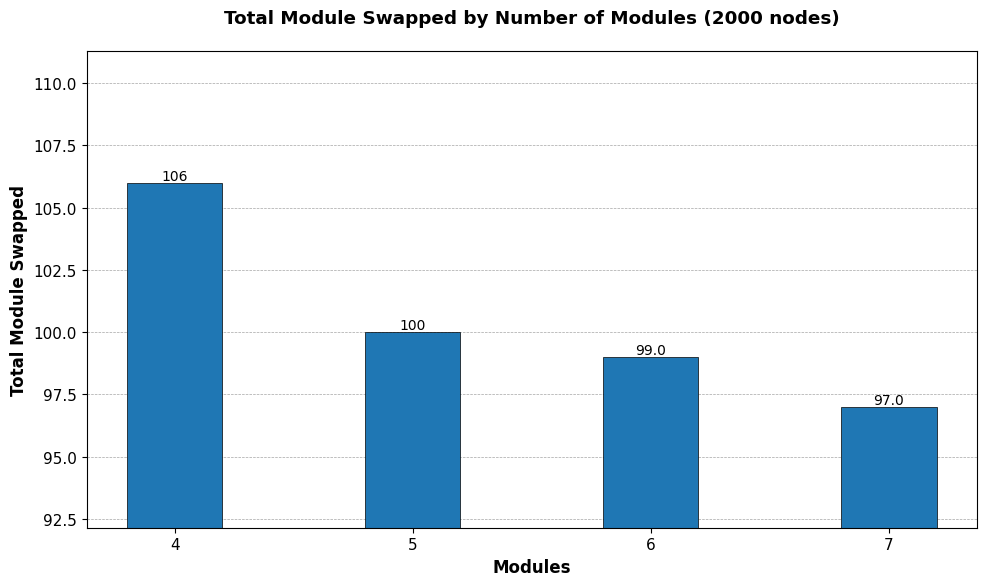

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Modules (2000 nodes)'}, xlabel='Modules', ylabel='Total Module Swapped'>)

In [122]:
create_simple_bar_chart(
    df_2000_module,
    'Modules',
    'Total Module Swapped',
    title='Total Module Swapped by Number of Modules (2000 nodes)',
    ylabel='Total Module Swapped'
)


# 2000 nodes Swapping Time


In [123]:
# Load 2000 nodes Swapping Time data
df_2000_swappingtime = load_heuristic_data(2000, 'SwappingTimeChange')
# Handle '1min', '2min' format - extract numeric part (only if string type)
if 'Swapping Time' in df_2000_swappingtime.columns:
    if df_2000_swappingtime['Swapping Time'].dtype == 'object':
        df_2000_swappingtime['Swapping Time'] = df_2000_swappingtime['Swapping Time'].str.replace('min', '').astype(int)
    else:
        # Already numeric, just ensure it's int
        df_2000_swappingtime['Swapping Time'] = df_2000_swappingtime['Swapping Time'].astype(int)
print("2000 nodes Swapping Time Data:")
print(df_2000_swappingtime)


2000 nodes Swapping Time Data:
   Swapping Time  Total Travel Time  Total Energy Consumed  \
0              1           13181.25               2057.197   
1              2           13381.98               2057.455   
2              3           13381.98               2057.455   
3              4           13540.28               2062.478   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 8650.95  1033.079                   100  
1                 8652.17  1236.336                   100  
2                 8652.17  1236.336                   100  
3                 8701.15  1137.963                   100  


## (a) Travel time bar chart


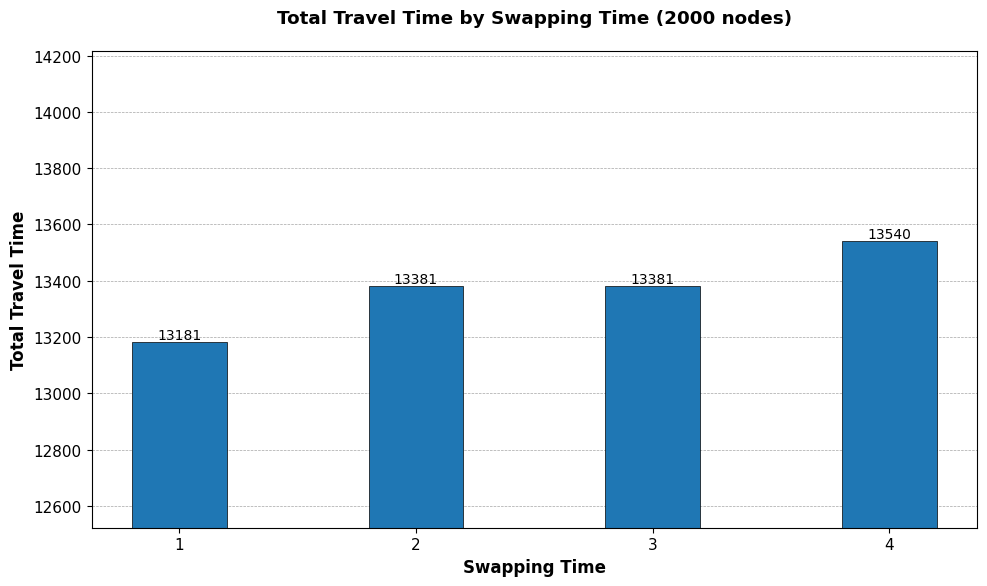

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Swapping Time (2000 nodes)'}, xlabel='Swapping Time', ylabel='Total Travel Time'>)

In [124]:
create_simple_bar_chart(
    df_2000_swappingtime,
    'Swapping Time',
    'Total Travel Time',
    title='Total Travel Time by Swapping Time (2000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


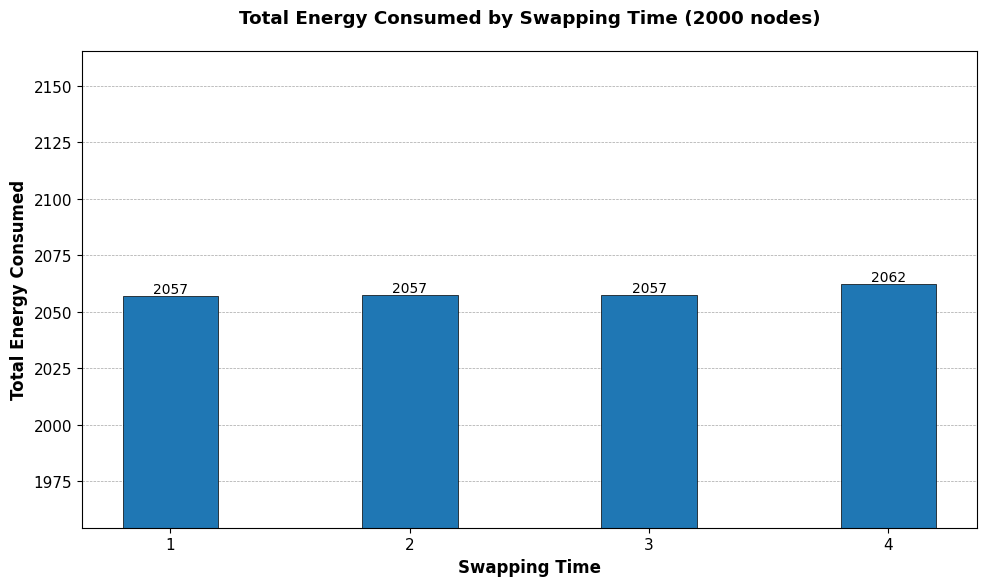

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Swapping Time (2000 nodes)'}, xlabel='Swapping Time', ylabel='Total Energy Consumed'>)

In [125]:
create_simple_bar_chart(
    df_2000_swappingtime,
    'Swapping Time',
    'Total Energy Consumed',
    title='Total Energy Consumed by Swapping Time (2000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


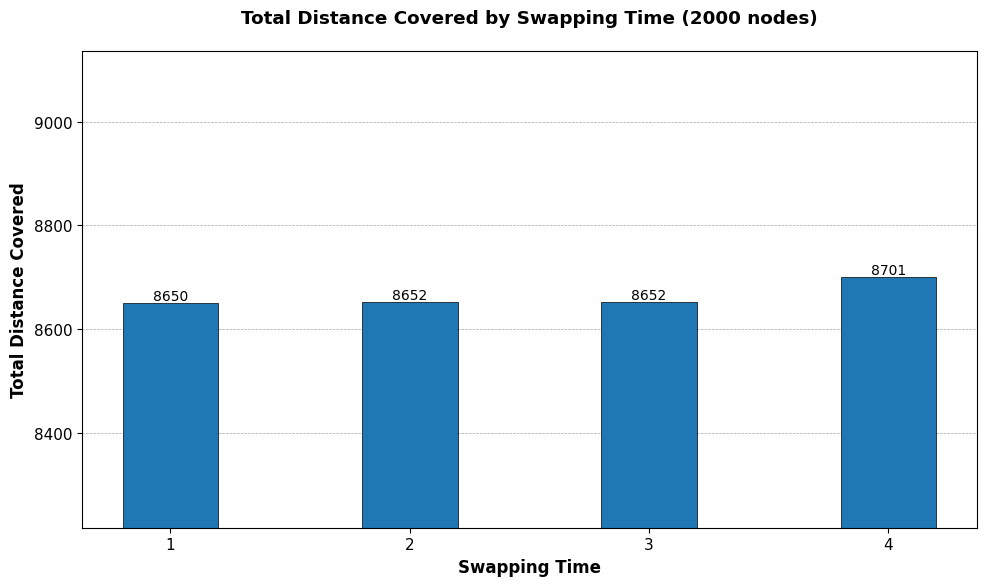

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Swapping Time (2000 nodes)'}, xlabel='Swapping Time', ylabel='Total Distance Covered'>)

In [126]:
create_simple_bar_chart(
    df_2000_swappingtime,
    'Swapping Time',
    'Total Distance Covered',
    title='Total Distance Covered by Swapping Time (2000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


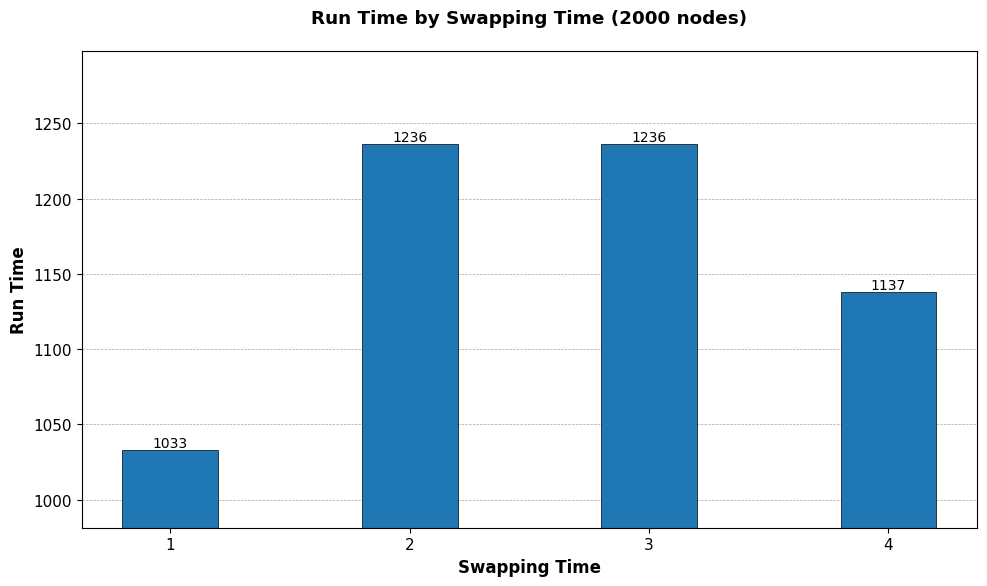

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Swapping Time (2000 nodes)'}, xlabel='Swapping Time', ylabel='Run Time'>)

In [127]:
create_simple_bar_chart(
    df_2000_swappingtime,
    'Swapping Time',
    'Run Time',
    title='Run Time by Swapping Time (2000 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


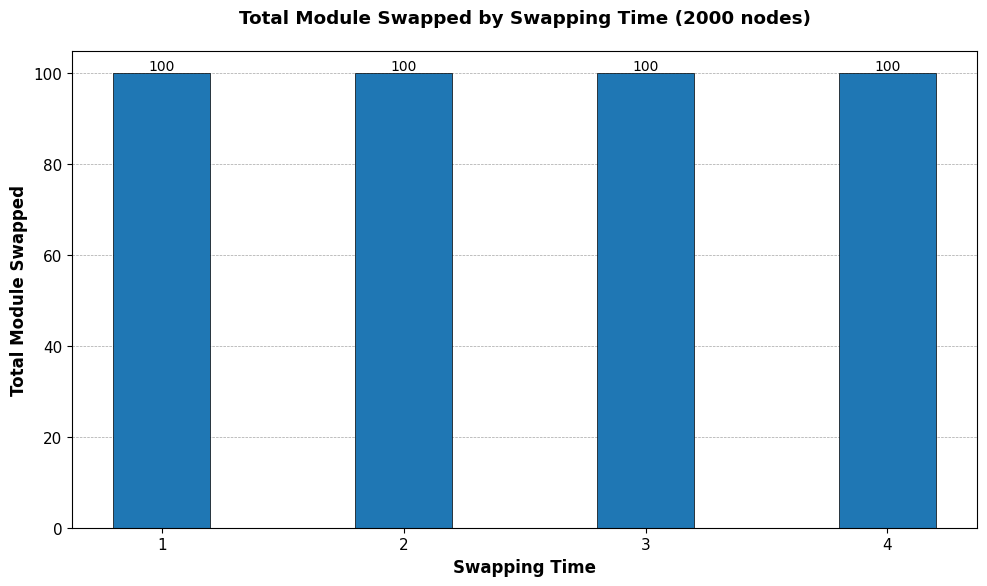

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Swapping Time (2000 nodes)'}, xlabel='Swapping Time', ylabel='Total Module Swapped'>)

In [128]:
create_simple_bar_chart(
    df_2000_swappingtime,
    'Swapping Time',
    'Total Module Swapped',
    title='Total Module Swapped by Swapping Time (2000 nodes)',
    ylabel='Total Module Swapped'
)


# 2000 nodes Threshold


In [129]:
# Load 2000 nodes Threshold data
df_2000_threshold = load_heuristic_data(2000, 'ThresholdChange')
print("2000 nodes Threshold Data:")
print(df_2000_threshold)


2000 nodes Threshold Data:
   Threshold  Total Travel Time  Total Energy Consumed  \
0          5           13059.88               2027.673   
1         10           13320.95               2057.783   
2         15           13157.49               2020.238   
3         20           13381.98               2057.455   

   Total Distance Covered  Run Time  Total Module Swapped  
0                 8527.92   820.342                    98  
1                 8685.62  1052.892                    99  
2                 8585.63  1023.548                    97  
3                 8652.17  1236.336                   100  


## (a) Travel time bar chart


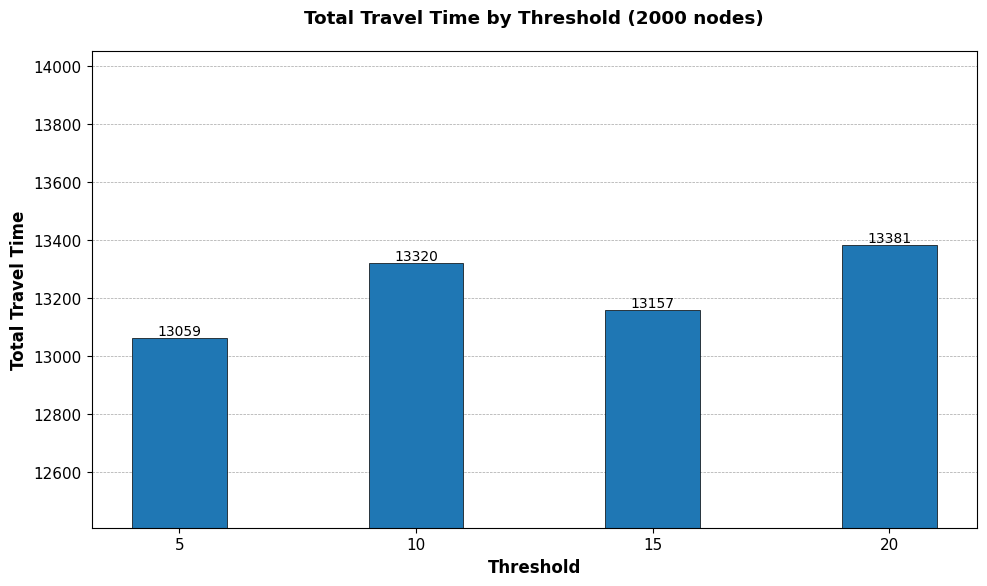

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Threshold (2000 nodes)'}, xlabel='Threshold', ylabel='Total Travel Time'>)

In [130]:
create_simple_bar_chart(
    df_2000_threshold,
    'Threshold',
    'Total Travel Time',
    title='Total Travel Time by Threshold (2000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


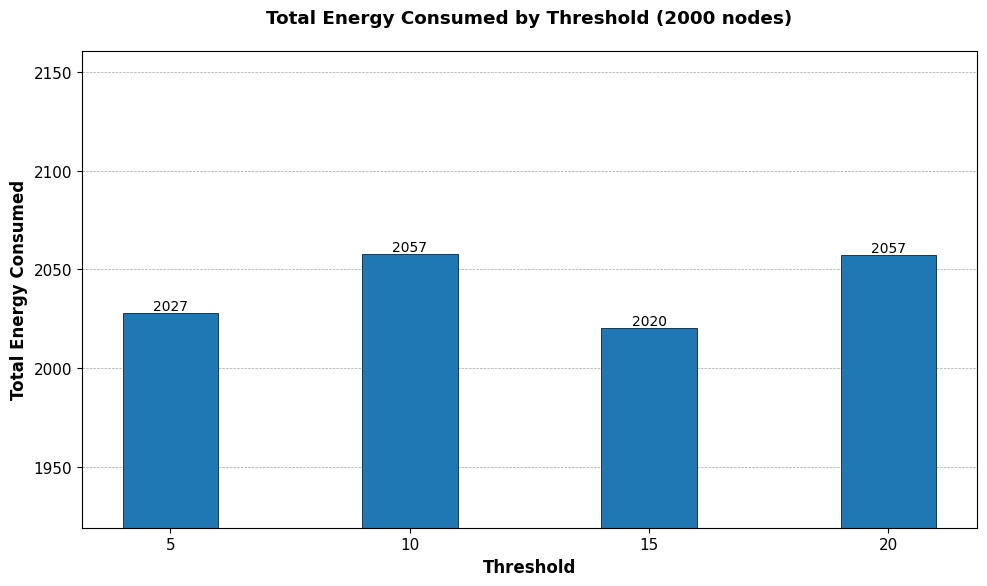

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Threshold (2000 nodes)'}, xlabel='Threshold', ylabel='Total Energy Consumed'>)

In [131]:
create_simple_bar_chart(
    df_2000_threshold,
    'Threshold',
    'Total Energy Consumed',
    title='Total Energy Consumed by Threshold (2000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


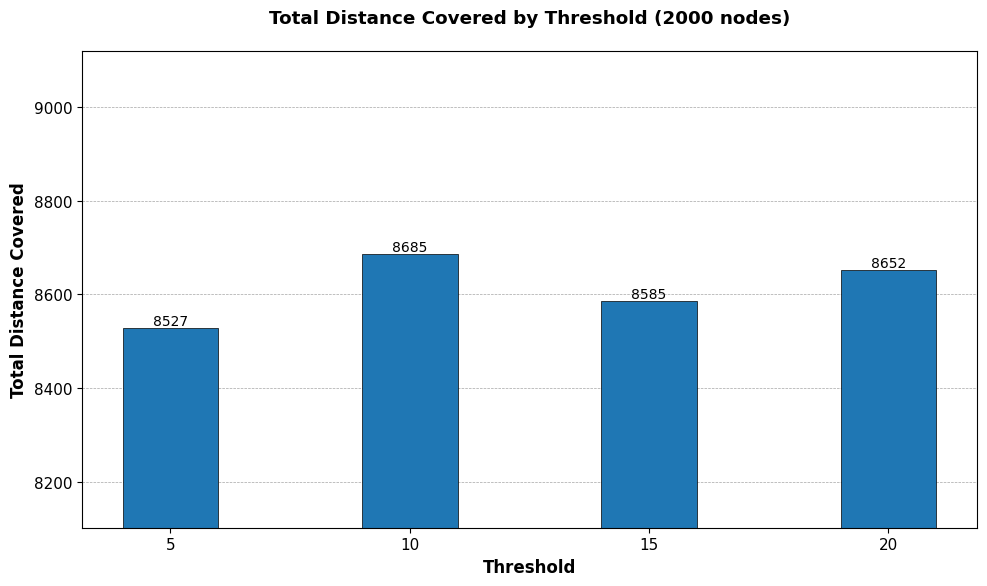

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Threshold (2000 nodes)'}, xlabel='Threshold', ylabel='Total Distance Covered'>)

In [132]:
create_simple_bar_chart(
    df_2000_threshold,
    'Threshold',
    'Total Distance Covered',
    title='Total Distance Covered by Threshold (2000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


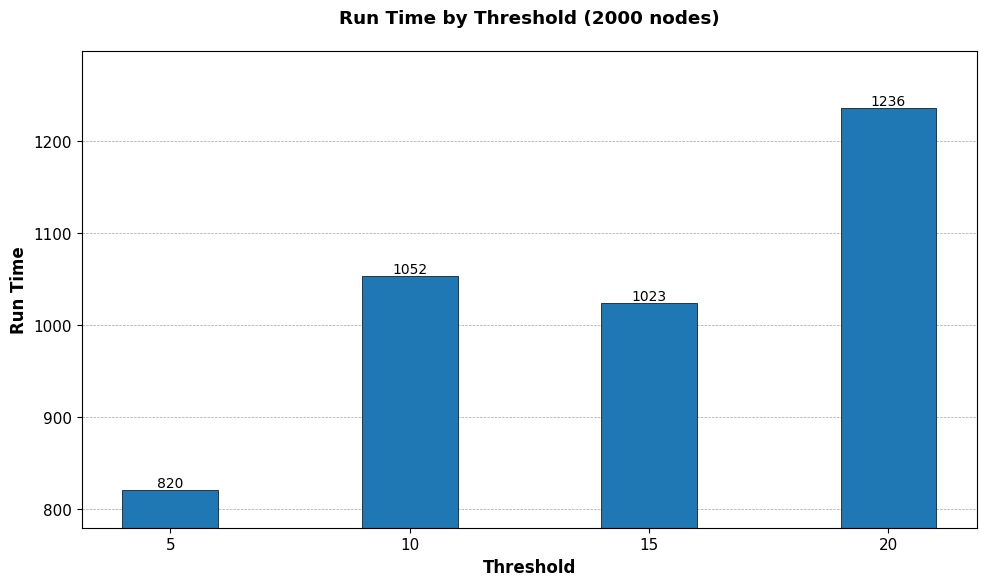

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Threshold (2000 nodes)'}, xlabel='Threshold', ylabel='Run Time'>)

In [133]:
create_simple_bar_chart(
    df_2000_threshold,
    'Threshold',
    'Run Time',
    title='Run Time by Threshold (2000 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


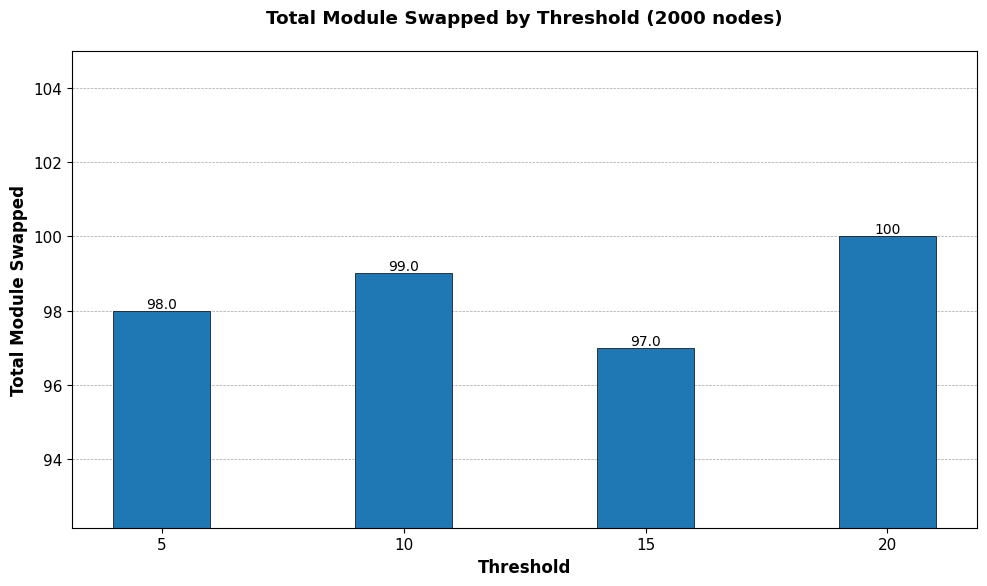

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Threshold (2000 nodes)'}, xlabel='Threshold', ylabel='Total Module Swapped'>)

In [134]:
create_simple_bar_chart(
    df_2000_threshold,
    'Threshold',
    'Total Module Swapped',
    title='Total Module Swapped by Threshold (2000 nodes)',
    ylabel='Total Module Swapped'
)


# 2000 nodes Traffic


In [135]:
# Load 2000 nodes Traffic data
df_2000_traffic = load_heuristic_data(2000, 'TrafficChange')
print("2000 nodes Traffic Data:")
print(df_2000_traffic)


2000 nodes Traffic Data:
  Traffic  Total Travel Time  Total Energy Consumed  Total Distance Covered  \
0    High           15961.57               1975.637                 8689.81   
1     Mid           13268.48               1974.446                 8698.94   
2     Low           11773.91               2187.707                 8994.35   

   Run Time  Total Module Swapped  
0  2491.948                    96  
1  1505.956                    96  
2  1826.235                   107  


## (a) Travel time bar chart


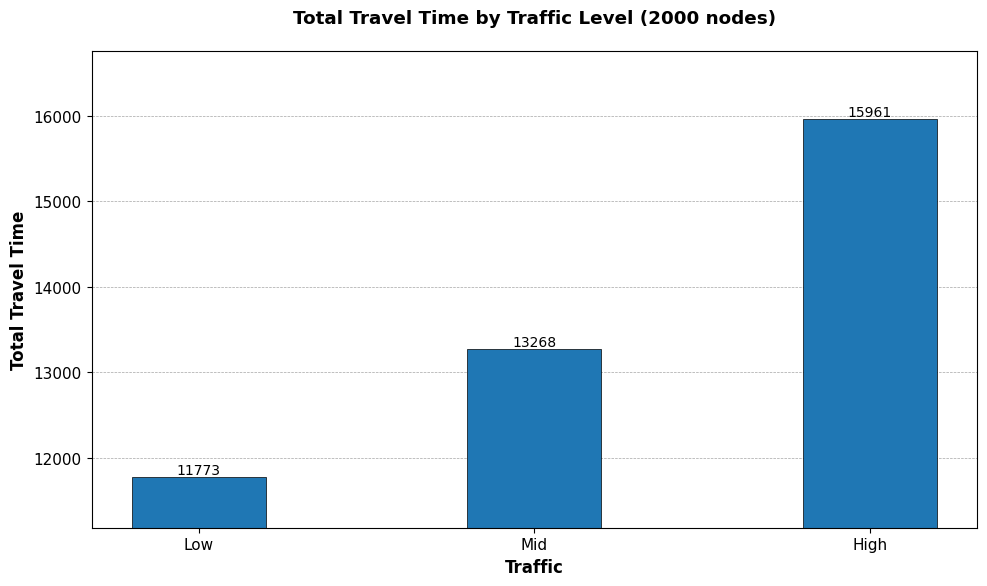

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Traffic Level (2000 nodes)'}, xlabel='Traffic', ylabel='Total Travel Time'>)

In [136]:
create_simple_bar_chart(
    df_2000_traffic,
    'Traffic',
    'Total Travel Time',
    title='Total Travel Time by Traffic Level (2000 nodes)',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


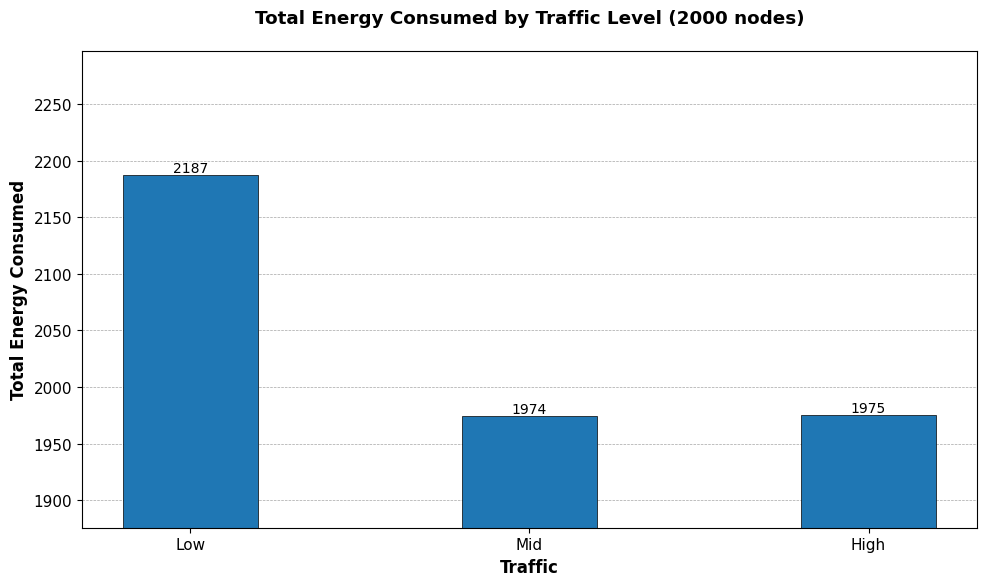

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Traffic Level (2000 nodes)'}, xlabel='Traffic', ylabel='Total Energy Consumed'>)

In [137]:
create_simple_bar_chart(
    df_2000_traffic,
    'Traffic',
    'Total Energy Consumed',
    title='Total Energy Consumed by Traffic Level (2000 nodes)',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


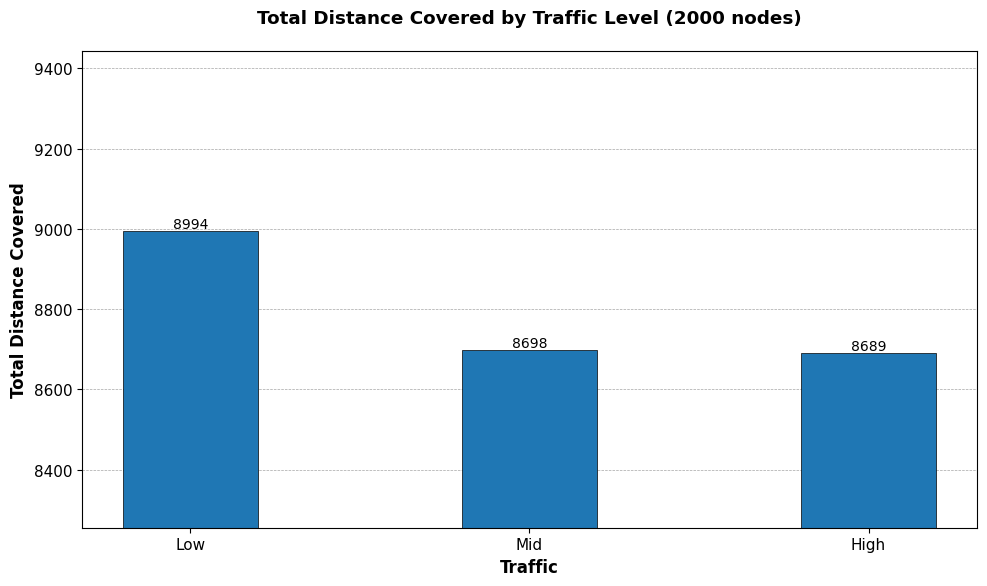

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Traffic Level (2000 nodes)'}, xlabel='Traffic', ylabel='Total Distance Covered'>)

In [138]:
create_simple_bar_chart(
    df_2000_traffic,
    'Traffic',
    'Total Distance Covered',
    title='Total Distance Covered by Traffic Level (2000 nodes)',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


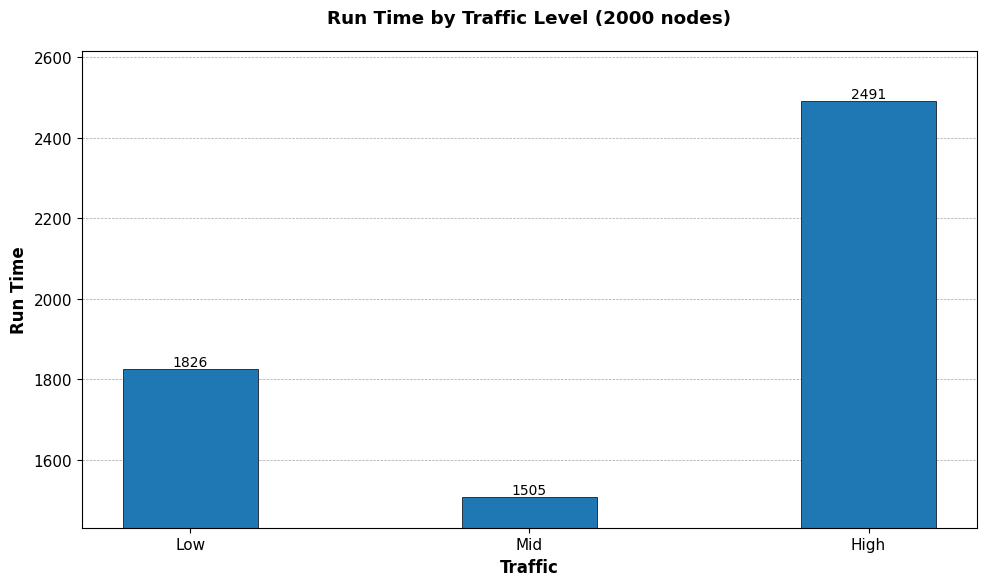

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Traffic Level (2000 nodes)'}, xlabel='Traffic', ylabel='Run Time'>)

In [139]:
create_simple_bar_chart(
    df_2000_traffic,
    'Traffic',
    'Run Time',
    title='Run Time by Traffic Level (2000 nodes)',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


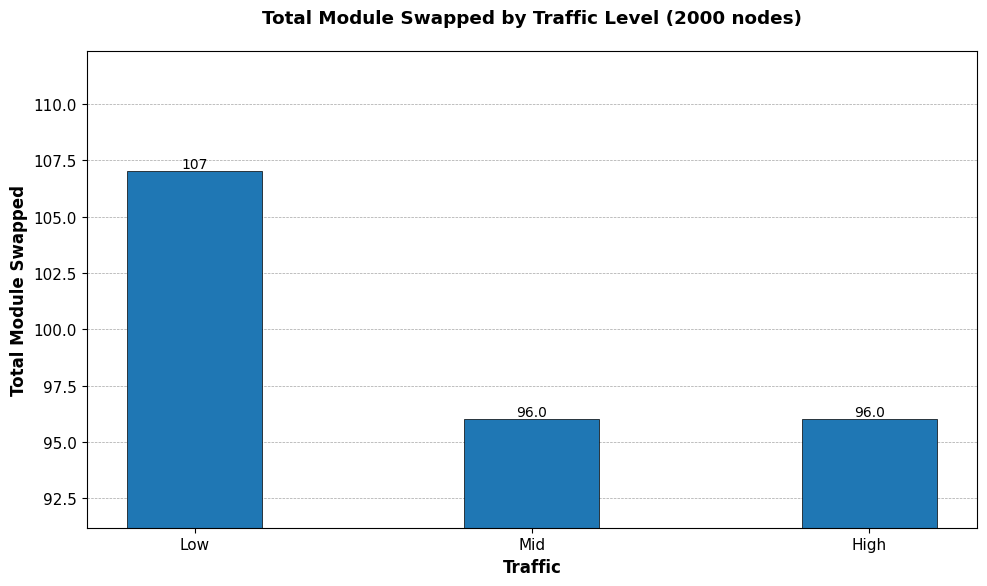

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Traffic Level (2000 nodes)'}, xlabel='Traffic', ylabel='Total Module Swapped'>)

In [140]:
create_simple_bar_chart(
    df_2000_traffic,
    'Traffic',
    'Total Module Swapped',
    title='Total Module Swapped by Traffic Level (2000 nodes)',
    ylabel='Total Module Swapped'
)


# MT2TE Node Change

In [141]:
# Load data for Node Change charts
# Using default parameter values: Modules=5, Threshold=10, Swapping Time=2, Traffic=Mid
node_counts_list = [500, 1000, 1500, 2000]

# Module Change - use Modules=5
node_change_module = []
for nc in node_counts_list:
    df = load_heuristic_data(nc, 'ModuleChange')
    val = df[df['Modules'] == 5]['Total Travel Time'].values
    if len(val) > 0:
        node_change_module.append(val[0])
    else:
        # Use first available value
        node_change_module.append(df.iloc[0]['Total Travel Time'])

# Threshold - use Threshold=10
node_change_threshold = []
for nc in node_counts_list:
    df = load_heuristic_data(nc, 'ThresholdChange')
    val = df[df['Threshold'] == 10]['Total Travel Time'].values
    if len(val) > 0:
        node_change_threshold.append(val[0])
    else:
        node_change_threshold.append(df.iloc[0]['Total Travel Time'])

# Swapping Time - use Swapping Time=2
node_change_swap = []
for nc in node_counts_list:
    df = load_heuristic_data(nc, 'SwappingTimeChange')
    # Handle format differences
    if 'Swapping Time' in df.columns:
        if df['Swapping Time'].dtype == 'object':
            df['Swapping Time'] = df['Swapping Time'].str.replace('min', '').astype(int)
    val = df[df['Swapping Time'] == 2]['Total Travel Time'].values
    if len(val) > 0:
        node_change_swap.append(val[0])
    else:
        node_change_swap.append(df.iloc[0]['Total Travel Time'])

# Traffic - use Traffic=Mid
node_change_traffic = []
for nc in node_counts_list:
    df = load_heuristic_data(nc, 'TrafficChange')
    # Handle column name inconsistency
    if 'Traffic' not in df.columns:
        first_col = df.columns[0]
        if set(df[first_col].values).issubset({'High', 'Mid', 'Low'}):
            df = df.rename(columns={first_col: 'Traffic'})
    val = df[df['Traffic'] == 'Mid']['Total Travel Time'].values
    if len(val) > 0:
        node_change_traffic.append(val[0])
    else:
        node_change_traffic.append(df.iloc[0]['Total Travel Time'])

# Use average of all experiment types for Node Change
node_change_travel_time = [(a+b+c+d)/4 for a,b,c,d in zip(node_change_module, node_change_threshold, node_change_swap, node_change_traffic)]

print("Node Change Travel Time values:", node_change_travel_time)



Node Change Travel Time values: [np.float64(3228.1375), np.float64(6864.82), np.float64(10060.405), np.float64(13338.3475)]


## (a) Travel time bar chart


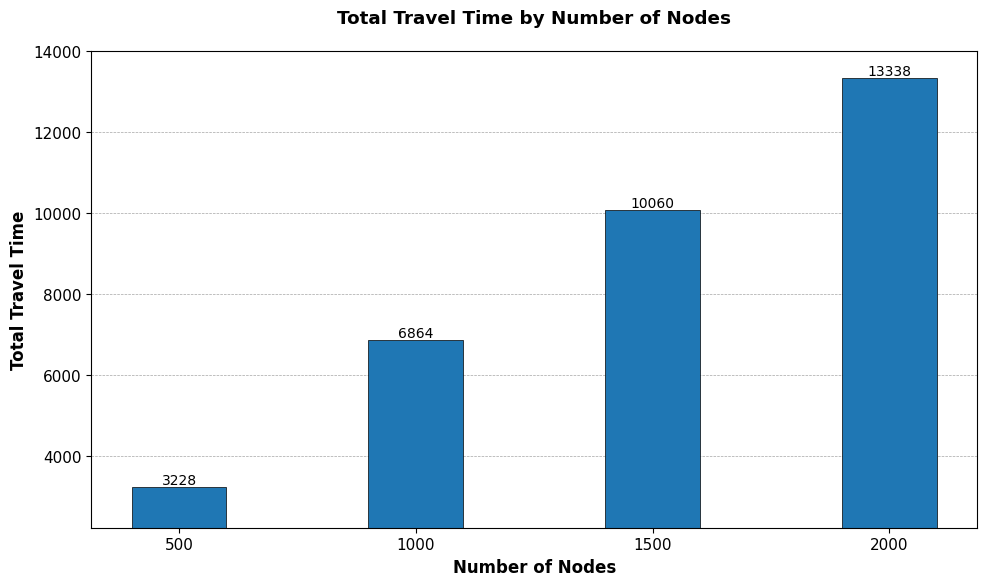

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Nodes'}, xlabel='Number of Nodes', ylabel='Total Travel Time'>)

In [142]:
# Aggregate Total Travel Time across node counts
node_change_data = []
for nc in node_counts_list:
    # Get from Module Change (Modules=5)
    df_mod = load_heuristic_data(nc, 'ModuleChange')
    val_mod = df_mod[df_mod['Modules'] == 5]['Total Travel Time'].values
    if len(val_mod) == 0:
        val_mod = [df_mod.iloc[0]['Total Travel Time']]
    
    # Get from Threshold (Threshold=10)
    df_th = load_heuristic_data(nc, 'ThresholdChange')
    val_th = df_th[df_th['Threshold'] == 10]['Total Travel Time'].values
    if len(val_th) == 0:
        val_th = [df_th.iloc[0]['Total Travel Time']]
    
    # Get from Swapping Time (Swapping Time=2)
    df_swap = load_heuristic_data(nc, 'SwappingTimeChange')
    if 'Swapping Time' in df_swap.columns and df_swap['Swapping Time'].dtype == 'object':
        df_swap['Swapping Time'] = df_swap['Swapping Time'].str.replace('min', '').astype(int)
    val_swap = df_swap[df_swap['Swapping Time'] == 2]['Total Travel Time'].values
    if len(val_swap) == 0:
        val_swap = [df_swap.iloc[0]['Total Travel Time']]
    
    # Get from Traffic (Traffic=Mid)
    df_traf = load_heuristic_data(nc, 'TrafficChange')
    if 'Traffic' not in df_traf.columns:
        first_col = df_traf.columns[0]
        if set(df_traf[first_col].values).issubset({'High', 'Mid', 'Low'}):
            df_traf = df_traf.rename(columns={first_col: 'Traffic'})
    val_traf = df_traf[df_traf['Traffic'] == 'Mid']['Total Travel Time'].values
    if len(val_traf) == 0:
        val_traf = [df_traf.iloc[0]['Total Travel Time']]
    
    # Average across experiment types
    node_change_data.append((val_mod[0] + val_th[0] + val_swap[0] + val_traf[0]) / 4)

# Create DataFrame for chart
import pandas as pd
df_node_change = pd.DataFrame({
    'Number of Nodes': node_counts_list,
    'Total Travel Time': node_change_data
})

create_simple_bar_chart(
    df_node_change,
    'Number of Nodes',
    'Total Travel Time',
    title='Total Travel Time by Number of Nodes',
    ylabel='Total Travel Time'
)


## (b) Energy consumed bar chart


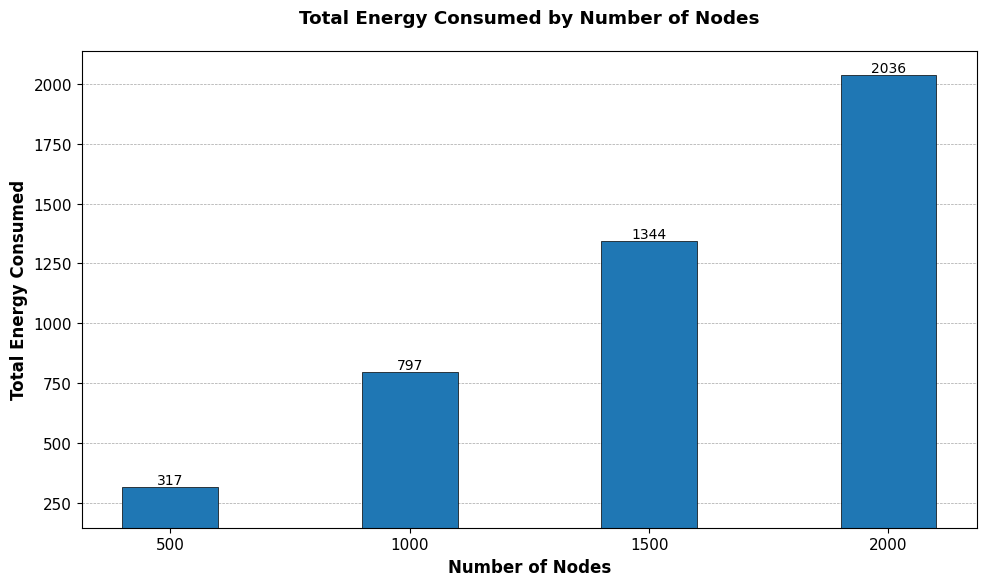

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Nodes'}, xlabel='Number of Nodes', ylabel='Total Energy Consumed'>)

In [143]:
# Aggregate Total Energy Consumed across node counts
node_change_data = []
for nc in node_counts_list:
    # Get from Module Change (Modules=5)
    df_mod = load_heuristic_data(nc, 'ModuleChange')
    val_mod = df_mod[df_mod['Modules'] == 5]['Total Energy Consumed'].values
    if len(val_mod) == 0:
        val_mod = [df_mod.iloc[0]['Total Energy Consumed']]
    
    # Get from Threshold (Threshold=10)
    df_th = load_heuristic_data(nc, 'ThresholdChange')
    val_th = df_th[df_th['Threshold'] == 10]['Total Energy Consumed'].values
    if len(val_th) == 0:
        val_th = [df_th.iloc[0]['Total Energy Consumed']]
    
    # Get from Swapping Time (Swapping Time=2)
    df_swap = load_heuristic_data(nc, 'SwappingTimeChange')
    if 'Swapping Time' in df_swap.columns and df_swap['Swapping Time'].dtype == 'object':
        df_swap['Swapping Time'] = df_swap['Swapping Time'].str.replace('min', '').astype(int)
    val_swap = df_swap[df_swap['Swapping Time'] == 2]['Total Energy Consumed'].values
    if len(val_swap) == 0:
        val_swap = [df_swap.iloc[0]['Total Energy Consumed']]
    
    # Get from Traffic (Traffic=Mid)
    df_traf = load_heuristic_data(nc, 'TrafficChange')
    if 'Traffic' not in df_traf.columns:
        first_col = df_traf.columns[0]
        if set(df_traf[first_col].values).issubset({'High', 'Mid', 'Low'}):
            df_traf = df_traf.rename(columns={first_col: 'Traffic'})
    val_traf = df_traf[df_traf['Traffic'] == 'Mid']['Total Energy Consumed'].values
    if len(val_traf) == 0:
        val_traf = [df_traf.iloc[0]['Total Energy Consumed']]
    
    # Average across experiment types
    node_change_data.append((val_mod[0] + val_th[0] + val_swap[0] + val_traf[0]) / 4)

# Create DataFrame for chart
import pandas as pd
df_node_change = pd.DataFrame({
    'Number of Nodes': node_counts_list,
    'Total Energy Consumed': node_change_data
})

create_simple_bar_chart(
    df_node_change,
    'Number of Nodes',
    'Total Energy Consumed',
    title='Total Energy Consumed by Number of Nodes',
    ylabel='Total Energy Consumed'
)


## (c) Distance covered bar chart


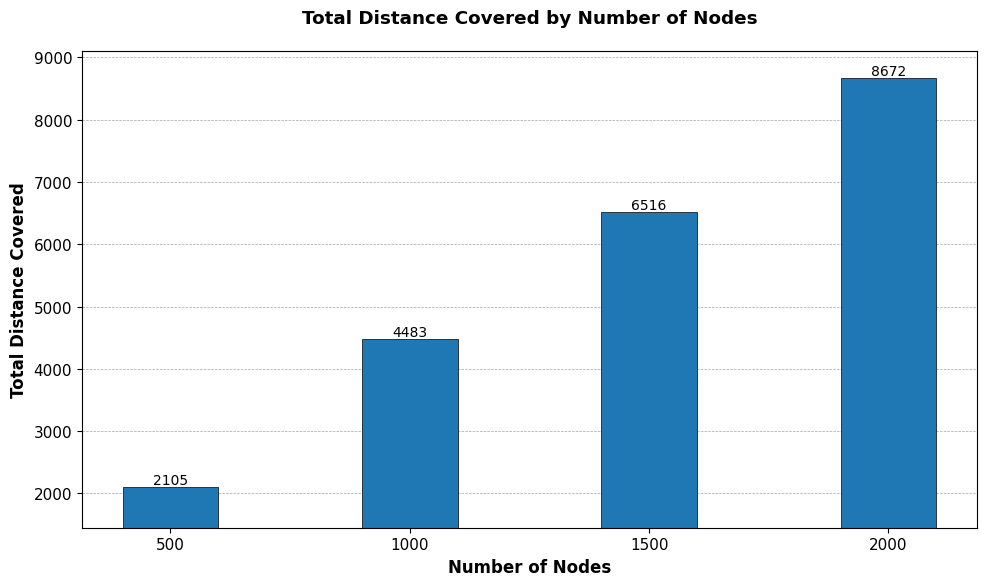

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Nodes'}, xlabel='Number of Nodes', ylabel='Total Distance Covered'>)

In [144]:
# Aggregate Total Distance Covered across node counts
node_change_data = []
for nc in node_counts_list:
    # Get from Module Change (Modules=5)
    df_mod = load_heuristic_data(nc, 'ModuleChange')
    val_mod = df_mod[df_mod['Modules'] == 5]['Total Distance Covered'].values
    if len(val_mod) == 0:
        val_mod = [df_mod.iloc[0]['Total Distance Covered']]
    
    # Get from Threshold (Threshold=10)
    df_th = load_heuristic_data(nc, 'ThresholdChange')
    val_th = df_th[df_th['Threshold'] == 10]['Total Distance Covered'].values
    if len(val_th) == 0:
        val_th = [df_th.iloc[0]['Total Distance Covered']]
    
    # Get from Swapping Time (Swapping Time=2)
    df_swap = load_heuristic_data(nc, 'SwappingTimeChange')
    if 'Swapping Time' in df_swap.columns and df_swap['Swapping Time'].dtype == 'object':
        df_swap['Swapping Time'] = df_swap['Swapping Time'].str.replace('min', '').astype(int)
    val_swap = df_swap[df_swap['Swapping Time'] == 2]['Total Distance Covered'].values
    if len(val_swap) == 0:
        val_swap = [df_swap.iloc[0]['Total Distance Covered']]
    
    # Get from Traffic (Traffic=Mid)
    df_traf = load_heuristic_data(nc, 'TrafficChange')
    if 'Traffic' not in df_traf.columns:
        first_col = df_traf.columns[0]
        if set(df_traf[first_col].values).issubset({'High', 'Mid', 'Low'}):
            df_traf = df_traf.rename(columns={first_col: 'Traffic'})
    val_traf = df_traf[df_traf['Traffic'] == 'Mid']['Total Distance Covered'].values
    if len(val_traf) == 0:
        val_traf = [df_traf.iloc[0]['Total Distance Covered']]
    
    # Average across experiment types
    node_change_data.append((val_mod[0] + val_th[0] + val_swap[0] + val_traf[0]) / 4)

# Create DataFrame for chart
import pandas as pd
df_node_change = pd.DataFrame({
    'Number of Nodes': node_counts_list,
    'Total Distance Covered': node_change_data
})

create_simple_bar_chart(
    df_node_change,
    'Number of Nodes',
    'Total Distance Covered',
    title='Total Distance Covered by Number of Nodes',
    ylabel='Total Distance Covered'
)


## (d) Run time bar chart


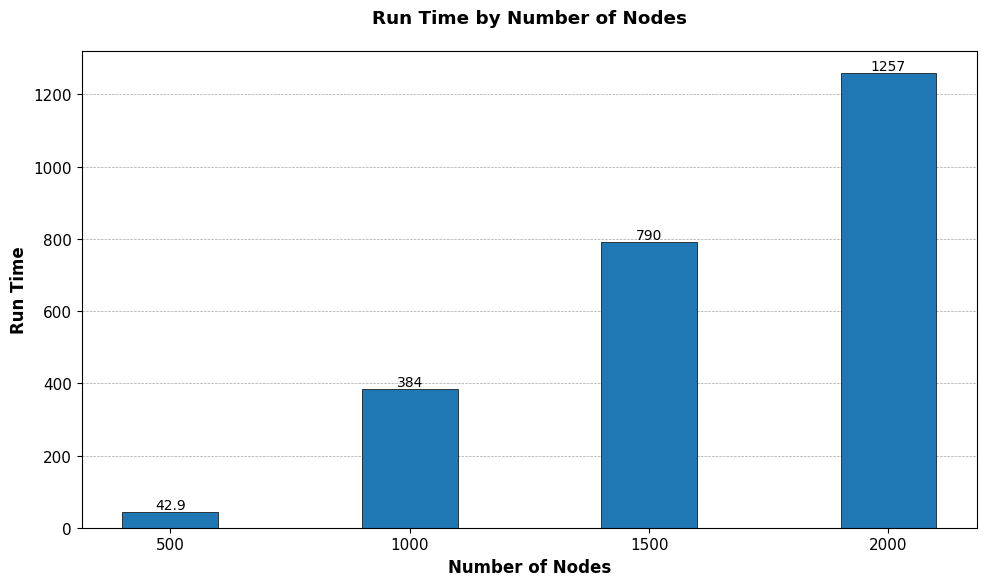

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Nodes'}, xlabel='Number of Nodes', ylabel='Run Time'>)

In [145]:
# Aggregate Run Time across node counts
node_change_data = []
for nc in node_counts_list:
    # Get from Module Change (Modules=5)
    df_mod = load_heuristic_data(nc, 'ModuleChange')
    val_mod = df_mod[df_mod['Modules'] == 5]['Run Time'].values
    if len(val_mod) == 0:
        val_mod = [df_mod.iloc[0]['Run Time']]
    
    # Get from Threshold (Threshold=10)
    df_th = load_heuristic_data(nc, 'ThresholdChange')
    val_th = df_th[df_th['Threshold'] == 10]['Run Time'].values
    if len(val_th) == 0:
        val_th = [df_th.iloc[0]['Run Time']]
    
    # Get from Swapping Time (Swapping Time=2)
    df_swap = load_heuristic_data(nc, 'SwappingTimeChange')
    if 'Swapping Time' in df_swap.columns and df_swap['Swapping Time'].dtype == 'object':
        df_swap['Swapping Time'] = df_swap['Swapping Time'].str.replace('min', '').astype(int)
    val_swap = df_swap[df_swap['Swapping Time'] == 2]['Run Time'].values
    if len(val_swap) == 0:
        val_swap = [df_swap.iloc[0]['Run Time']]
    
    # Get from Traffic (Traffic=Mid)
    df_traf = load_heuristic_data(nc, 'TrafficChange')
    if 'Traffic' not in df_traf.columns:
        first_col = df_traf.columns[0]
        if set(df_traf[first_col].values).issubset({'High', 'Mid', 'Low'}):
            df_traf = df_traf.rename(columns={first_col: 'Traffic'})
    val_traf = df_traf[df_traf['Traffic'] == 'Mid']['Run Time'].values
    if len(val_traf) == 0:
        val_traf = [df_traf.iloc[0]['Run Time']]
    
    # Average across experiment types
    node_change_data.append((val_mod[0] + val_th[0] + val_swap[0] + val_traf[0]) / 4)

# Create DataFrame for chart
import pandas as pd
df_node_change = pd.DataFrame({
    'Number of Nodes': node_counts_list,
    'Run Time': node_change_data
})

create_simple_bar_chart(
    df_node_change,
    'Number of Nodes',
    'Run Time',
    title='Run Time by Number of Nodes',
    ylabel='Run Time'
)


## (e) Module swapped bar chart


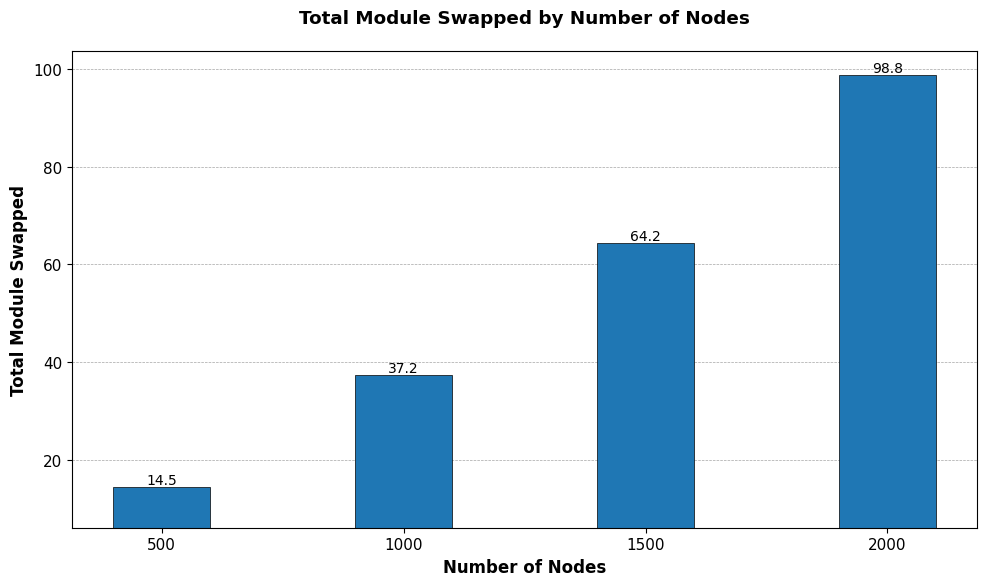

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Nodes'}, xlabel='Number of Nodes', ylabel='Total Module Swapped'>)

In [146]:
# Aggregate Total Module Swapped across node counts
node_change_data = []
for nc in node_counts_list:
    # Get from Module Change (Modules=5)
    df_mod = load_heuristic_data(nc, 'ModuleChange')
    val_mod = df_mod[df_mod['Modules'] == 5]['Total Module Swapped'].values
    if len(val_mod) == 0:
        val_mod = [df_mod.iloc[0]['Total Module Swapped']]
    
    # Get from Threshold (Threshold=10)
    df_th = load_heuristic_data(nc, 'ThresholdChange')
    val_th = df_th[df_th['Threshold'] == 10]['Total Module Swapped'].values
    if len(val_th) == 0:
        val_th = [df_th.iloc[0]['Total Module Swapped']]
    
    # Get from Swapping Time (Swapping Time=2)
    df_swap = load_heuristic_data(nc, 'SwappingTimeChange')
    if 'Swapping Time' in df_swap.columns and df_swap['Swapping Time'].dtype == 'object':
        df_swap['Swapping Time'] = df_swap['Swapping Time'].str.replace('min', '').astype(int)
    val_swap = df_swap[df_swap['Swapping Time'] == 2]['Total Module Swapped'].values
    if len(val_swap) == 0:
        val_swap = [df_swap.iloc[0]['Total Module Swapped']]
    
    # Get from Traffic (Traffic=Mid)
    df_traf = load_heuristic_data(nc, 'TrafficChange')
    if 'Traffic' not in df_traf.columns:
        first_col = df_traf.columns[0]
        if set(df_traf[first_col].values).issubset({'High', 'Mid', 'Low'}):
            df_traf = df_traf.rename(columns={first_col: 'Traffic'})
    val_traf = df_traf[df_traf['Traffic'] == 'Mid']['Total Module Swapped'].values
    if len(val_traf) == 0:
        val_traf = [df_traf.iloc[0]['Total Module Swapped']]
    
    # Average across experiment types
    node_change_data.append((val_mod[0] + val_th[0] + val_swap[0] + val_traf[0]) / 4)

# Create DataFrame for chart
import pandas as pd
df_node_change = pd.DataFrame({
    'Number of Nodes': node_counts_list,
    'Total Module Swapped': node_change_data
})

create_simple_bar_chart(
    df_node_change,
    'Number of Nodes',
    'Total Module Swapped',
    title='Total Module Swapped by Number of Nodes',
    ylabel='Total Module Swapped'
)


# MT2TE Multi-Line Charts

## (a) Travel Time - Module Change

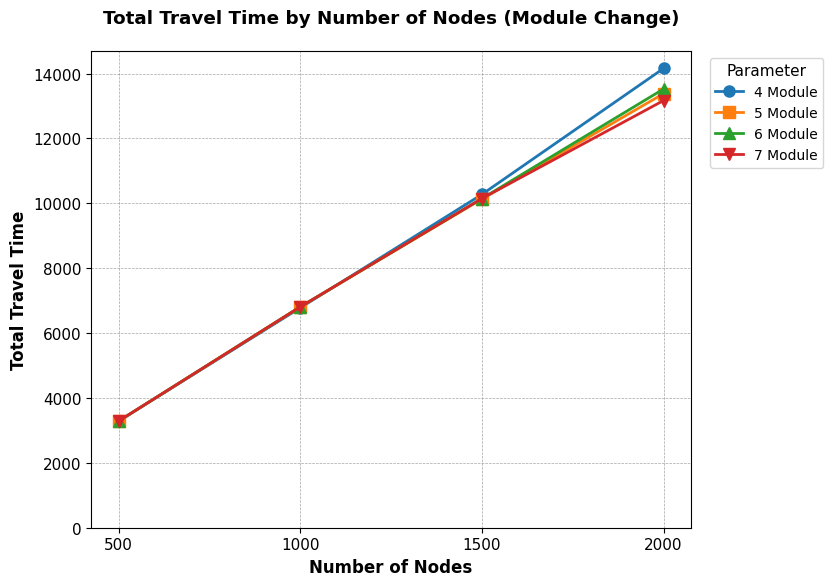

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Nodes (Module Change)'}, xlabel='Number of Nodes', ylabel='Total Travel Time'>)

In [147]:
METRIC = 'Total Travel Time'
data_dict = {}
for val in [4, 5, 6, 7]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ModuleChange')
        row = df[df['Modules'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Module'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Module Change)',
    ylabel=METRIC,
)


## (b) Travel Time - Threshold

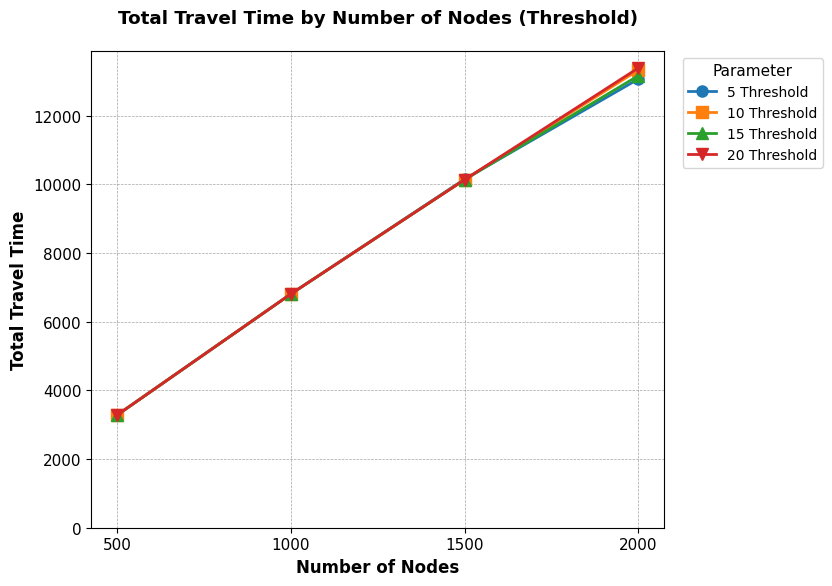

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Nodes (Threshold)'}, xlabel='Number of Nodes', ylabel='Total Travel Time'>)

In [148]:
METRIC = 'Total Travel Time'
data_dict = {}
for val in [5, 10, 15, 20]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ThresholdChange')
        row = df[df['Threshold'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Threshold'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Threshold)',
    ylabel=METRIC,
)


## (c) Travel Time - Swapping Time

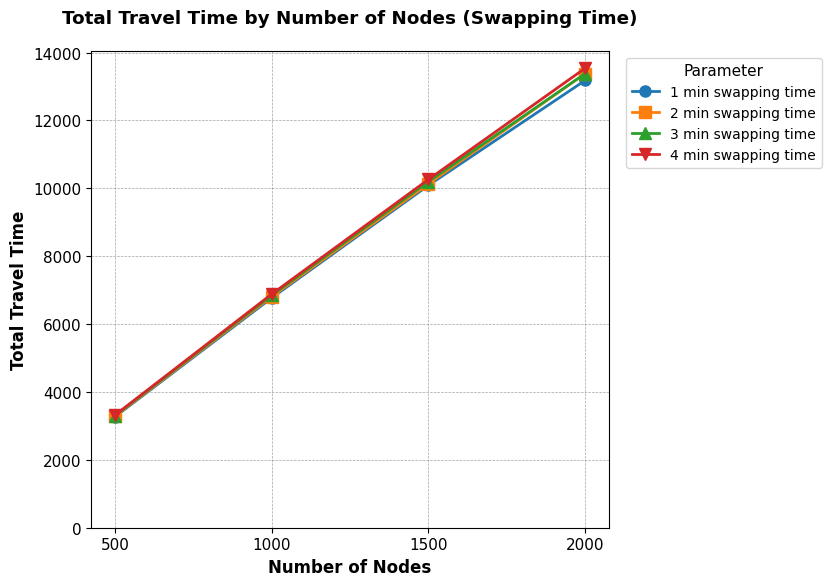

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Nodes (Swapping Time)'}, xlabel='Number of Nodes', ylabel='Total Travel Time'>)

In [149]:
METRIC = 'Total Travel Time'
data_dict = {}
for val in [1, 2, 3, 4]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'SwappingTimeChange')
        if 'Swapping Time' in df.columns and df['Swapping Time'].dtype == 'object':
            df['Swapping Time'] = df['Swapping Time'].str.replace('min', '').astype(int)
        row = df[df['Swapping Time'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} min swapping time'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Swapping Time)',
    ylabel=METRIC,
)


## (d) Travel Time - Traffic

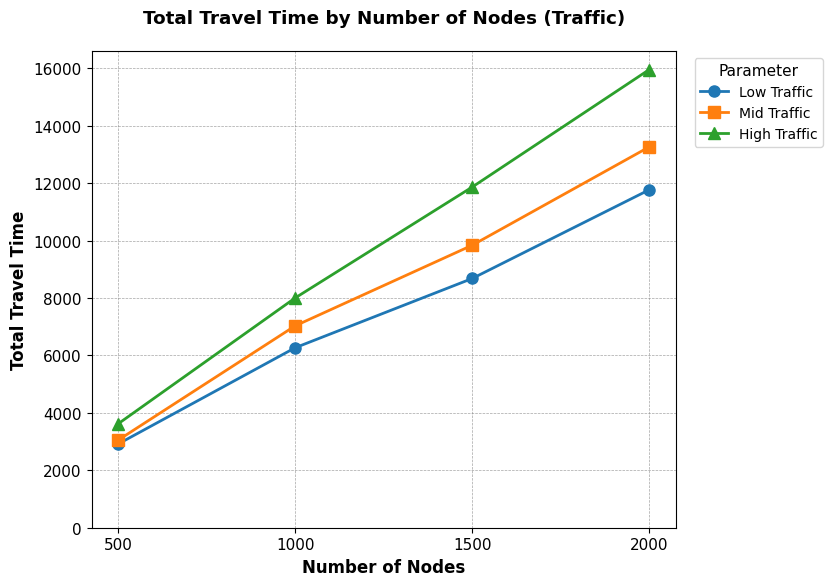

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Travel Time by Number of Nodes (Traffic)'}, xlabel='Number of Nodes', ylabel='Total Travel Time'>)

In [150]:
METRIC = 'Total Travel Time'
data_dict = {}
for val in ['Low', 'Mid', 'High']:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'TrafficChange')
        if 'Traffic' not in df.columns:
            first_col = df.columns[0]
            if set(df[first_col].values).issubset({'High', 'Mid', 'Low'}):
                df = df.rename(columns={first_col: 'Traffic'})
        row = df[df['Traffic'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Traffic'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Traffic)',
    ylabel=METRIC,
)


## (e) Energy Consumed - Module Change

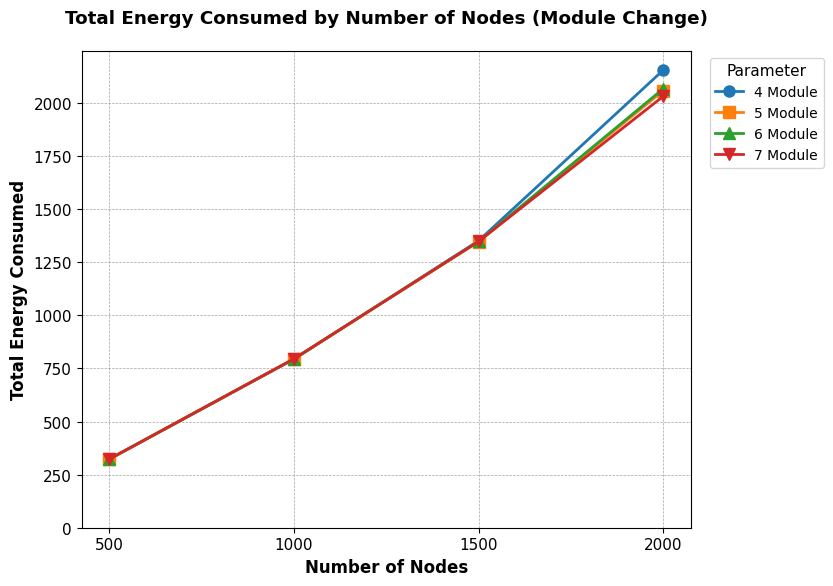

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Nodes (Module Change)'}, xlabel='Number of Nodes', ylabel='Total Energy Consumed'>)

In [151]:
METRIC = 'Total Energy Consumed'
data_dict = {}
for val in [4, 5, 6, 7]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ModuleChange')
        row = df[df['Modules'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Module'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Module Change)',
    ylabel=METRIC,
)


## (f) Energy Consumed - Threshold

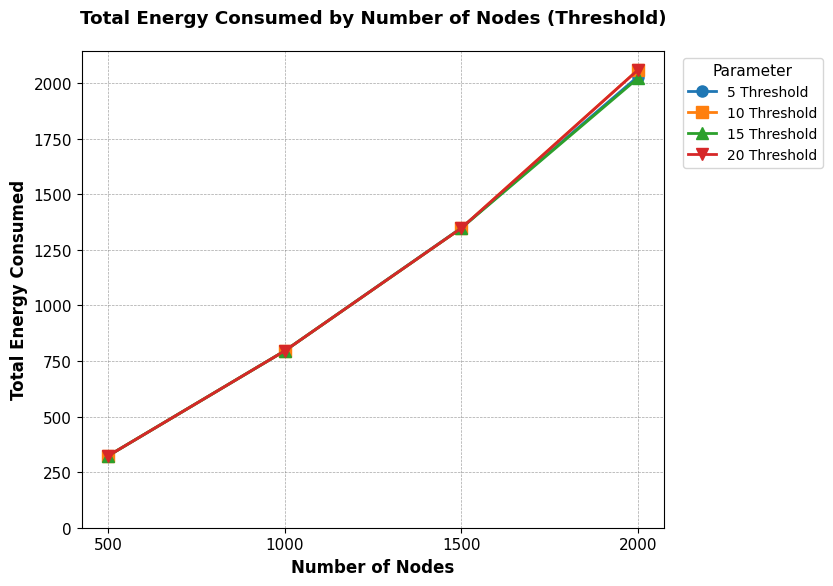

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Nodes (Threshold)'}, xlabel='Number of Nodes', ylabel='Total Energy Consumed'>)

In [152]:
METRIC = 'Total Energy Consumed'
data_dict = {}
for val in [5, 10, 15, 20]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ThresholdChange')
        row = df[df['Threshold'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Threshold'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Threshold)',
    ylabel=METRIC,
)


## (g) Energy Consumed - Swapping Time

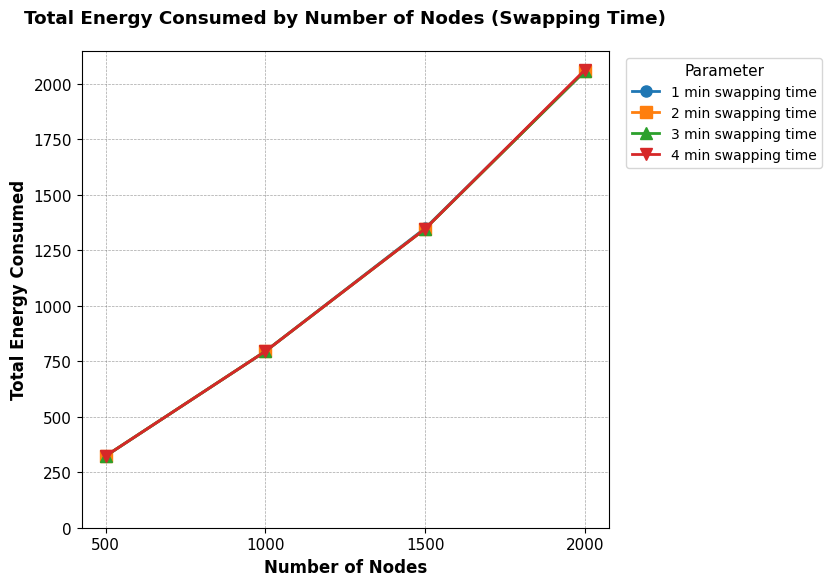

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Nodes (Swapping Time)'}, xlabel='Number of Nodes', ylabel='Total Energy Consumed'>)

In [153]:
METRIC = 'Total Energy Consumed'
data_dict = {}
for val in [1, 2, 3, 4]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'SwappingTimeChange')
        if 'Swapping Time' in df.columns and df['Swapping Time'].dtype == 'object':
            df['Swapping Time'] = df['Swapping Time'].str.replace('min', '').astype(int)
        row = df[df['Swapping Time'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} min swapping time'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Swapping Time)',
    ylabel=METRIC,
)


## (h) Energy Consumed - Traffic

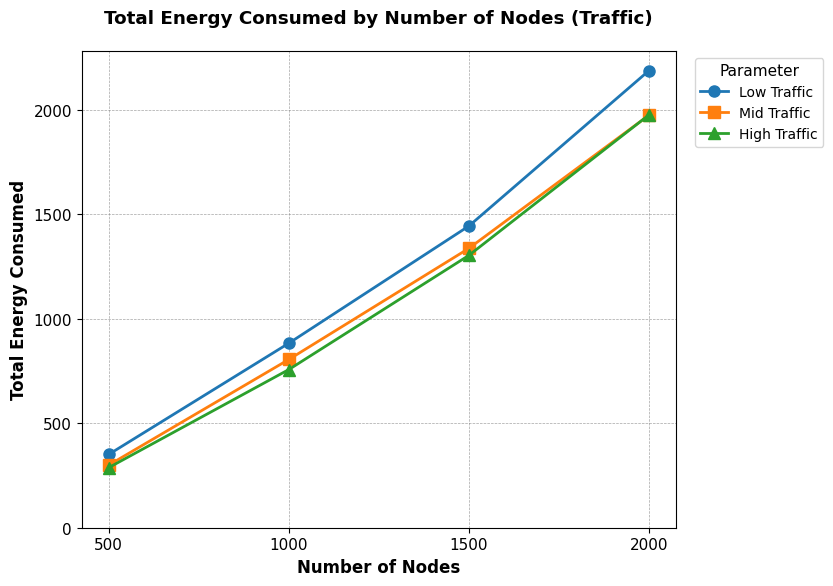

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Energy Consumed by Number of Nodes (Traffic)'}, xlabel='Number of Nodes', ylabel='Total Energy Consumed'>)

In [154]:
METRIC = 'Total Energy Consumed'
data_dict = {}
for val in ['Low', 'Mid', 'High']:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'TrafficChange')
        if 'Traffic' not in df.columns:
            first_col = df.columns[0]
            if set(df[first_col].values).issubset({'High', 'Mid', 'Low'}):
                df = df.rename(columns={first_col: 'Traffic'})
        row = df[df['Traffic'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Traffic'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Traffic)',
    ylabel=METRIC,
)


## (i) Distance Covered - Module Change

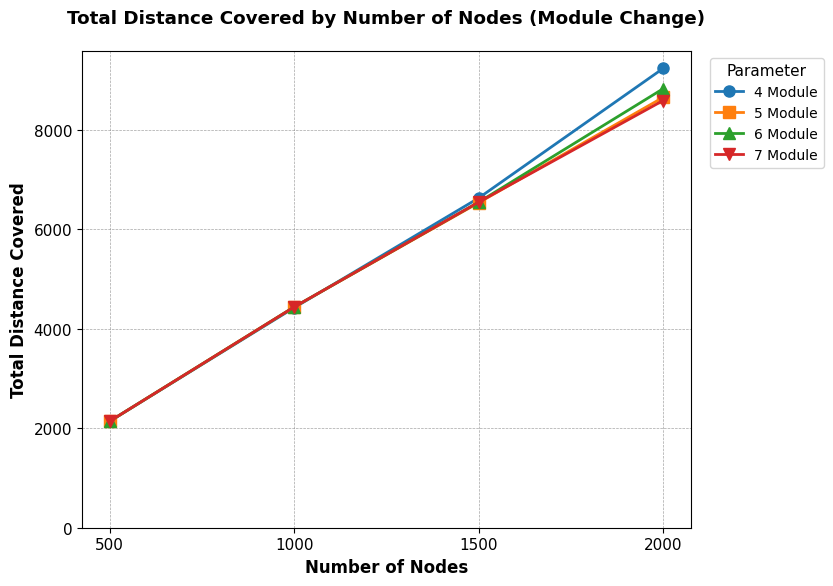

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Nodes (Module Change)'}, xlabel='Number of Nodes', ylabel='Total Distance Covered'>)

In [155]:
METRIC = 'Total Distance Covered'
data_dict = {}
for val in [4, 5, 6, 7]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ModuleChange')
        row = df[df['Modules'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Module'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Module Change)',
    ylabel=METRIC,
)


## (j) Distance Covered - Threshold

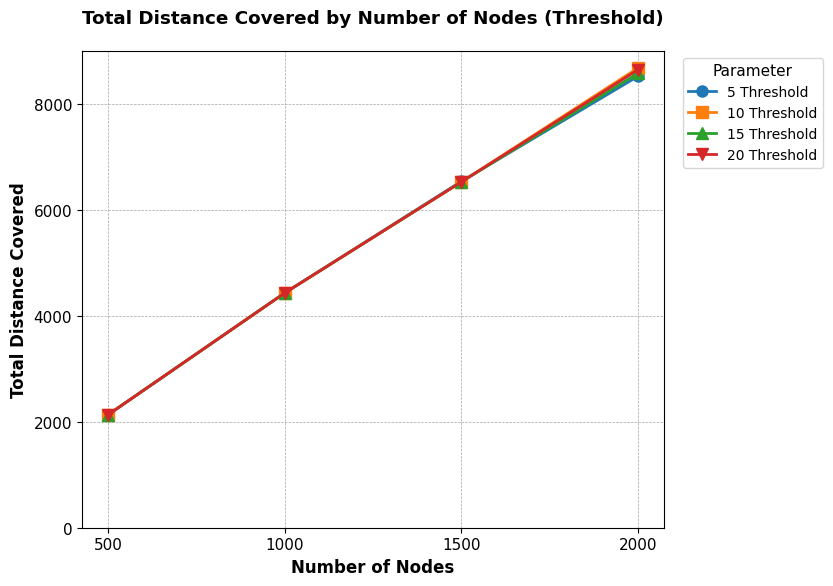

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Nodes (Threshold)'}, xlabel='Number of Nodes', ylabel='Total Distance Covered'>)

In [156]:
METRIC = 'Total Distance Covered'
data_dict = {}
for val in [5, 10, 15, 20]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ThresholdChange')
        row = df[df['Threshold'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Threshold'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Threshold)',
    ylabel=METRIC,
)


## (k) Distance Covered - Swapping Time

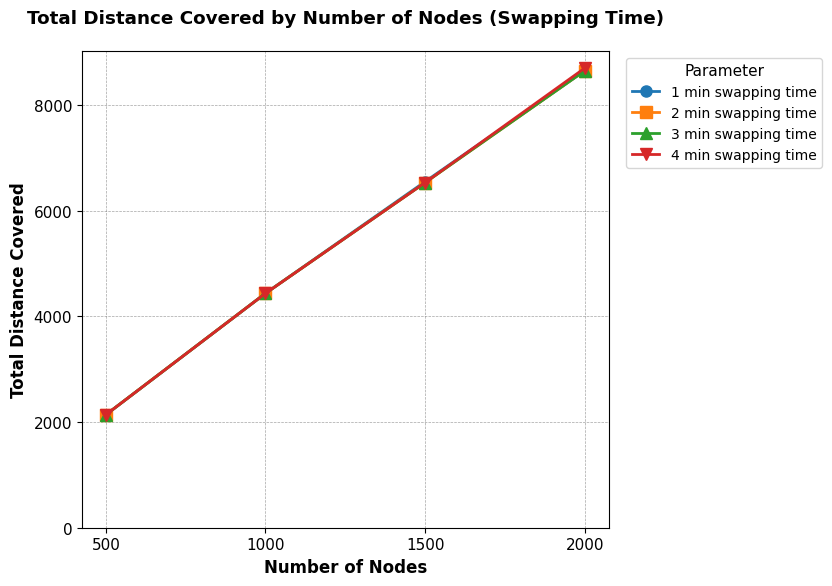

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Nodes (Swapping Time)'}, xlabel='Number of Nodes', ylabel='Total Distance Covered'>)

In [157]:
METRIC = 'Total Distance Covered'
data_dict = {}
for val in [1, 2, 3, 4]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'SwappingTimeChange')
        if 'Swapping Time' in df.columns and df['Swapping Time'].dtype == 'object':
            df['Swapping Time'] = df['Swapping Time'].str.replace('min', '').astype(int)
        row = df[df['Swapping Time'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} min swapping time'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Swapping Time)',
    ylabel=METRIC,
)


## (l) Distance Covered - Traffic

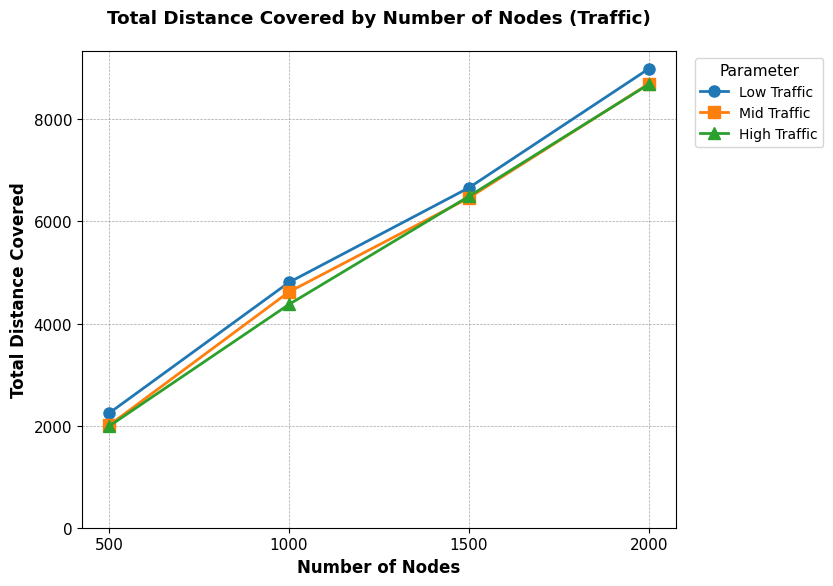

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Distance Covered by Number of Nodes (Traffic)'}, xlabel='Number of Nodes', ylabel='Total Distance Covered'>)

In [158]:
METRIC = 'Total Distance Covered'
data_dict = {}
for val in ['Low', 'Mid', 'High']:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'TrafficChange')
        if 'Traffic' not in df.columns:
            first_col = df.columns[0]
            if set(df[first_col].values).issubset({'High', 'Mid', 'Low'}):
                df = df.rename(columns={first_col: 'Traffic'})
        row = df[df['Traffic'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Traffic'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Traffic)',
    ylabel=METRIC,
)


## (m) Run Time - Module Change

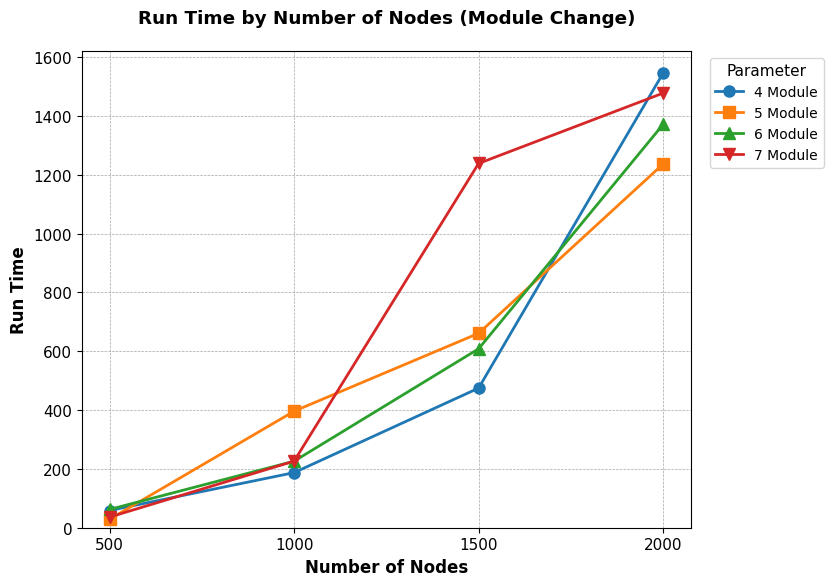

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Nodes (Module Change)'}, xlabel='Number of Nodes', ylabel='Run Time'>)

In [159]:
METRIC = 'Run Time'
data_dict = {}
for val in [4, 5, 6, 7]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ModuleChange')
        row = df[df['Modules'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Module'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Module Change)',
    ylabel=METRIC,
)


## (n) Run Time - Threshold

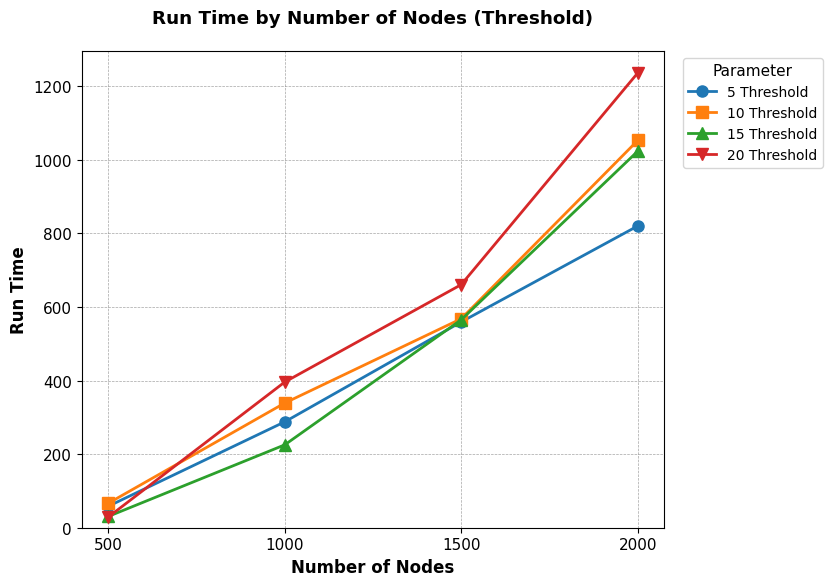

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Nodes (Threshold)'}, xlabel='Number of Nodes', ylabel='Run Time'>)

In [160]:
METRIC = 'Run Time'
data_dict = {}
for val in [5, 10, 15, 20]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ThresholdChange')
        row = df[df['Threshold'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Threshold'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Threshold)',
    ylabel=METRIC,
)


## (o) Run Time - Swapping Time

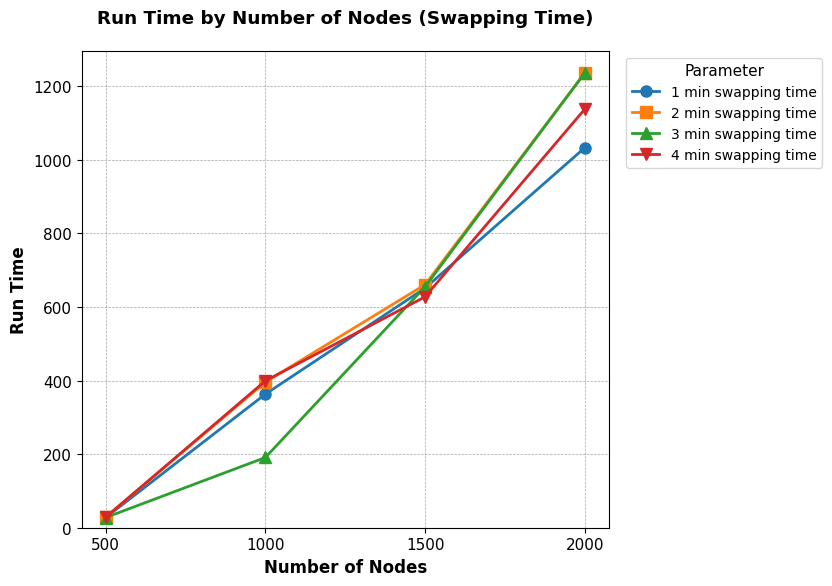

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Nodes (Swapping Time)'}, xlabel='Number of Nodes', ylabel='Run Time'>)

In [161]:
METRIC = 'Run Time'
data_dict = {}
for val in [1, 2, 3, 4]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'SwappingTimeChange')
        if 'Swapping Time' in df.columns and df['Swapping Time'].dtype == 'object':
            df['Swapping Time'] = df['Swapping Time'].str.replace('min', '').astype(int)
        row = df[df['Swapping Time'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} min swapping time'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Swapping Time)',
    ylabel=METRIC,
)


## (p) Run Time - Traffic

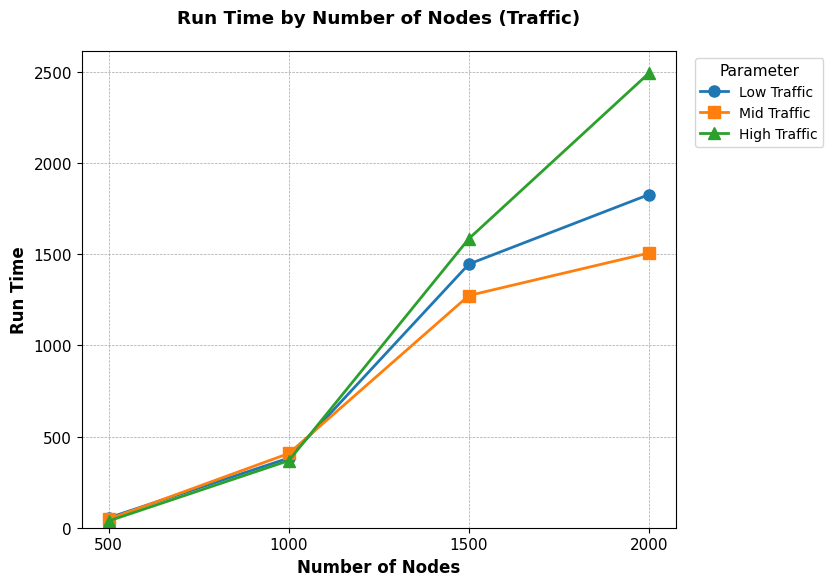

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Run Time by Number of Nodes (Traffic)'}, xlabel='Number of Nodes', ylabel='Run Time'>)

In [162]:
METRIC = 'Run Time'
data_dict = {}
for val in ['Low', 'Mid', 'High']:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'TrafficChange')
        if 'Traffic' not in df.columns:
            first_col = df.columns[0]
            if set(df[first_col].values).issubset({'High', 'Mid', 'Low'}):
                df = df.rename(columns={first_col: 'Traffic'})
        row = df[df['Traffic'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Traffic'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Traffic)',
    ylabel=METRIC,
)


## (q) Module Swapped - Module Change

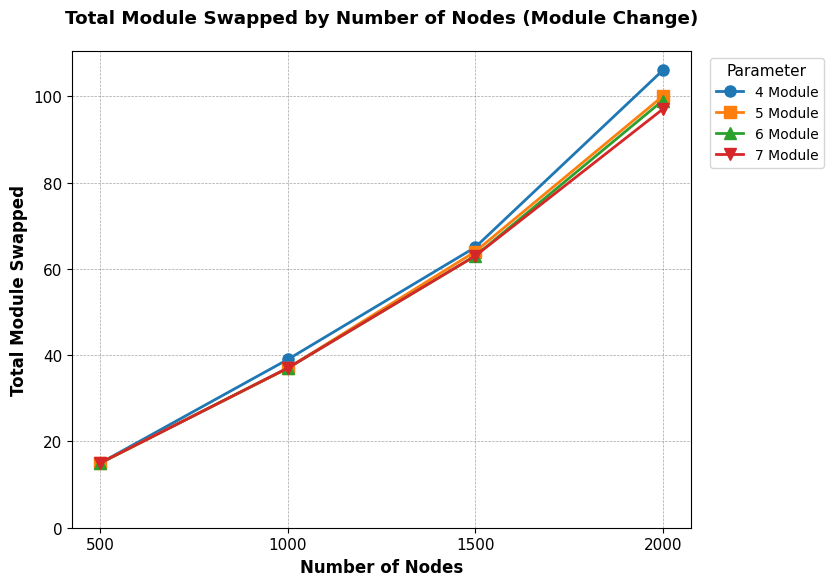

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Nodes (Module Change)'}, xlabel='Number of Nodes', ylabel='Total Module Swapped'>)

In [163]:
METRIC = 'Total Module Swapped'
data_dict = {}
for val in [4, 5, 6, 7]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ModuleChange')
        row = df[df['Modules'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Module'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Module Change)',
    ylabel=METRIC,
)


## (r) Module Swapped - Threshold

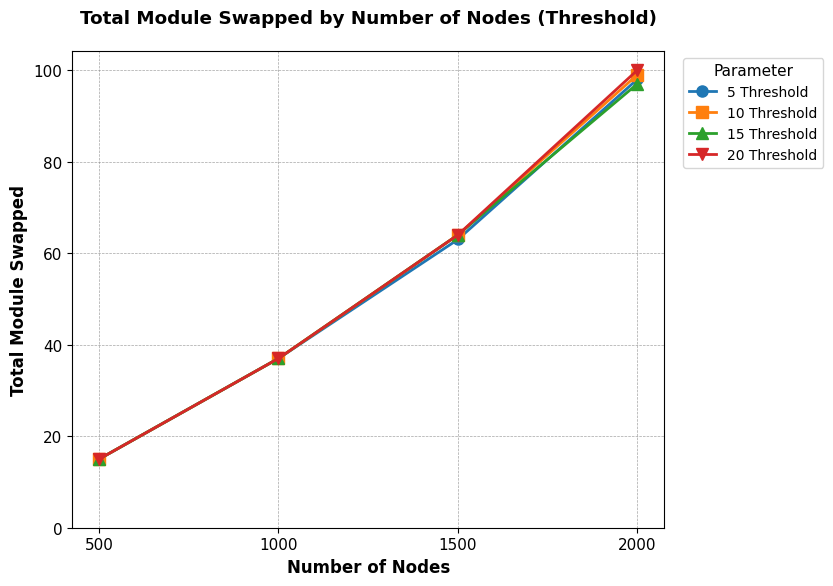

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Nodes (Threshold)'}, xlabel='Number of Nodes', ylabel='Total Module Swapped'>)

In [164]:
METRIC = 'Total Module Swapped'
data_dict = {}
for val in [5, 10, 15, 20]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'ThresholdChange')
        row = df[df['Threshold'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Threshold'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Threshold)',
    ylabel=METRIC,
)


## (s) Module Swapped - Swapping Time

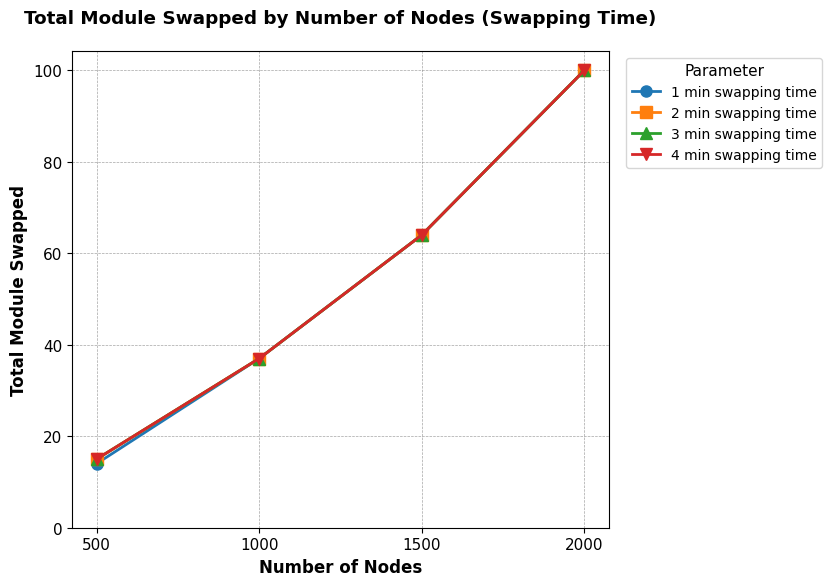

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Nodes (Swapping Time)'}, xlabel='Number of Nodes', ylabel='Total Module Swapped'>)

In [165]:
METRIC = 'Total Module Swapped'
data_dict = {}
for val in [1, 2, 3, 4]:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'SwappingTimeChange')
        if 'Swapping Time' in df.columns and df['Swapping Time'].dtype == 'object':
            df['Swapping Time'] = df['Swapping Time'].str.replace('min', '').astype(int)
        row = df[df['Swapping Time'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} min swapping time'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Swapping Time)',
    ylabel=METRIC,
)


## (t) Module Swapped - Traffic

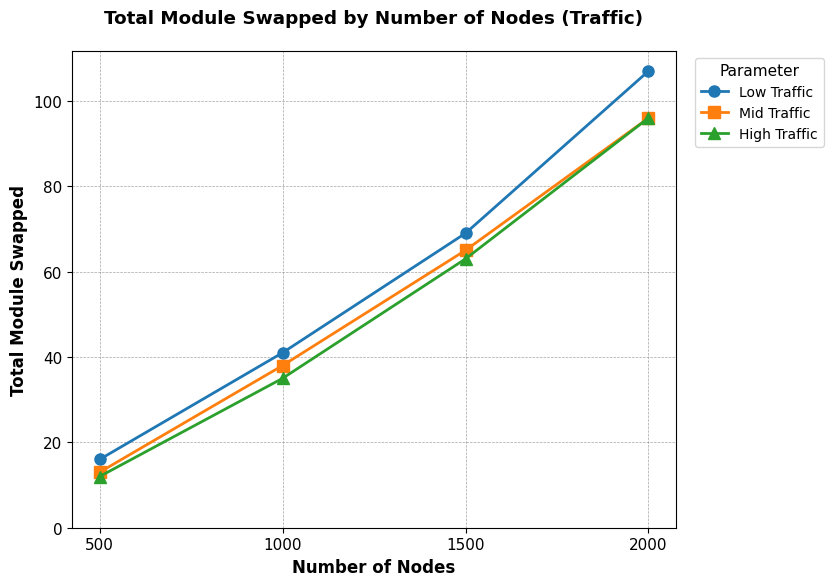

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Total Module Swapped by Number of Nodes (Traffic)'}, xlabel='Number of Nodes', ylabel='Total Module Swapped'>)

In [166]:
METRIC = 'Total Module Swapped'
data_dict = {}
for val in ['Low', 'Mid', 'High']:
    values_list = []
    for nc in [500, 1000, 1500, 2000]:
        df = load_heuristic_data(nc, 'TrafficChange')
        if 'Traffic' not in df.columns:
            first_col = df.columns[0]
            if set(df[first_col].values).issubset({'High', 'Mid', 'Low'}):
                df = df.rename(columns={first_col: 'Traffic'})
        row = df[df['Traffic'] == val][METRIC].values
        values_list.append(row[0] if len(row) > 0 else df.iloc[0][METRIC])
    data_dict[f'{val} Traffic'] = values_list

create_multi_line_chart(
    data_dict,
    METRIC,
    title=f'{METRIC} by Number of Nodes (Traffic)',
    ylabel=METRIC,
)
